# **===========================================================================================================================================================** #
# **Incremental Capstone 5 Notebook - Florida Bike Rentals** #
# **===========================================================================================================================================================** #

## <u>**Notebook Setup**</u> ##

In [1]:
# Import Libraries
import numpy as np
import pandas as pd
from scipy import stats
from scipy.stats import t
from scipy.stats import boxcox, yeojohnson, shapiro
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.metrics import mean_absolute_error
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest

from sklearn.preprocessing import (
    KBinsDiscretizer,
    PowerTransformer,
    QuantileTransformer,
    MinMaxScaler,
    StandardScaler,
    OrdinalEncoder,
    OneHotEncoder,
    LabelEncoder,
    PolynomialFeatures
)

from sklearn.linear_model import (
    LinearRegression,
    Ridge, 
    Lasso,
    ElasticNet
)

from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import(
    train_test_split,
    GridSearchCV,
    cross_val_score,
    KFold
)
from sklearn.metrics import mean_squared_error, root_mean_squared_error, r2_score
from scipy.interpolate import griddata
from statsmodels.nonparametric.smoothers_lowess import lowess

import platform
import sys

# How to tell python version
#print (sys.version_info)
#print (platform.python_version())

# How to pip install from Terminal window:
# python -m pip install seaborn

# Put this at the top of your notebook
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', 1000)  # Set a large number
pd.set_option('display.max_colwidth', None)

# Set random seed for reproducibility
np.random.seed(315)


## <u>**1. Data Import and Initial Exploratory Data Analysis**</u> ##

In [2]:
# Import data into DataFrame
# Renamed CSV file is assumed to live in same folder as my notebook
df_floridabikerentals = pd.read_csv("FloridaBikeRentals.csv")

# Make a copy of the dataframe to contain the modifications completed in this workbook
df_floridabikerentals_new = df_floridabikerentals.copy(deep=True)

# Let's look at what we just imported and get some more info
# I like to delineate output to make it more readable

def PrintDataFrameStatus(df_target):
    # Print Stats
    print("***********************************")
    print("Description Stats")
    print("***********************************")
    print()
    print(df_target.describe(include='all').T)
    print()

    # Print df Column Info
    print("***********************************")
    print("Basic Info of imported data set")
    print("***********************************")
    print()
    df_target.info()
    print()
    print()

    print(f'df_floridabikerentals Shape:{df_target.shape}')
    print()

    print('Do we have any features with null values?:')
    print(df_target.isnull().any().any())
    print()

    print('Feature Columns with that have null values:')
    print(df_target.isnull().sum()[df_target.isnull().sum() > 0])
    print()

    print('Do we have any features with nan values?:')
    print(df_target.isna().any().any())

    print("***********************************")
    print("First 20 rows of Data")
    print("***********************************")
    print()
    print(df_target.head(20))
    print()

    print("***********************************")
    print("First 20 rows of Random Sample Data")
    print("***********************************")
    print()
    print(df_target.sample(20))
    print

PrintDataFrameStatus(df_floridabikerentals)

***********************************
Description Stats
***********************************

                           count unique         top  freq         mean         std   min    25%     50%      75%     max
Date                        8760    365  01/12/2017    24          NaN         NaN   NaN    NaN     NaN      NaN     NaN
Rented Bike Count         8760.0    NaN         NaN   NaN   704.602055  644.997468   0.0  191.0   504.5  1065.25  3556.0
Hour                      8760.0    NaN         NaN   NaN         11.5    6.922582   0.0   5.75    11.5    17.25    23.0
Temperature(C)            8760.0    NaN         NaN   NaN    12.882922   11.944825 -17.8    3.5    13.7     22.5    39.4
Humidity(%)               8760.0    NaN         NaN   NaN    58.226256   20.362413   0.0   42.0    57.0     74.0    98.0
Wind speed (m/s)          8760.0    NaN         NaN   NaN     1.724909      1.0363   0.0    0.9     1.5      2.3     7.4
Visibility (10m)          8760.0    NaN         NaN   NaN  143

#### <b>Results of Initial Investigation</b> ####
    - We have 8.760 rows of data
    - The dataset contains 13 columns (features)
    - Initial testing reveals that we don't have any missing data/empty values
    - The column types look correct (as what we'd expect) except for Date and Time
      We should investigate translating these into Date data type:
        - Date (object) => Date datatype
    - For more of potential trend revealing views we probably want to investigate binning
      these values into:
        - Hour => TimeOfDay (Morning, Afternoon, Evening, Night)
    - For efficency/performance we should consider the following features from float64 to ints
      Rented Bike Count
      Hour 
      Humidity
      Visibility
    - Since we know that Date will be translated into DateTime, we'll omit it from our categoric columns list
    


#### <b>Initial Prep - Separate Numeric/Categoric Feature names</b> ####

In [3]:
# Figure out the numeric columns
numeric_cols = df_floridabikerentals.select_dtypes(include=['number']).columns
number_of_numeric_cols = len(numeric_cols)

print(f'Number of Numeric Columns: {number_of_numeric_cols}')
print(numeric_cols)

# Figure out the categoric (object/string) columns
original_categoric_cols = df_floridabikerentals.select_dtypes(include='object').columns.tolist()
number_of_original_categoric_cols = len(original_categoric_cols)

print(f'Number of Categoric Columns: {number_of_original_categoric_cols}')
print(number_of_original_categoric_cols)

# Remove 'Date' from Categoric Columns
categoric_cols = original_categoric_cols.copy()
categoric_cols.remove('Date')
number_of_categoric_cols = len(numeric_cols)

print(f'Number of Categoric Columns (without Date): {number_of_categoric_cols}')
print(categoric_cols)

Number of Numeric Columns: 10
Index(['Rented Bike Count', 'Hour', 'Temperature(C)', 'Humidity(%)', 'Wind speed (m/s)', 'Visibility (10m)', 'Dew point temperature(C)', 'Solar Radiation (MJ/m2)', 'Rainfall(mm)', 'Snowfall (cm)'], dtype='object')
Number of Categoric Columns: 4
4
Number of Categoric Columns (without Date): 10
['Seasons', 'Holiday', 'Functioning Day']


#### <b>Initial Histograms of Raw Numeric Features</b> ####

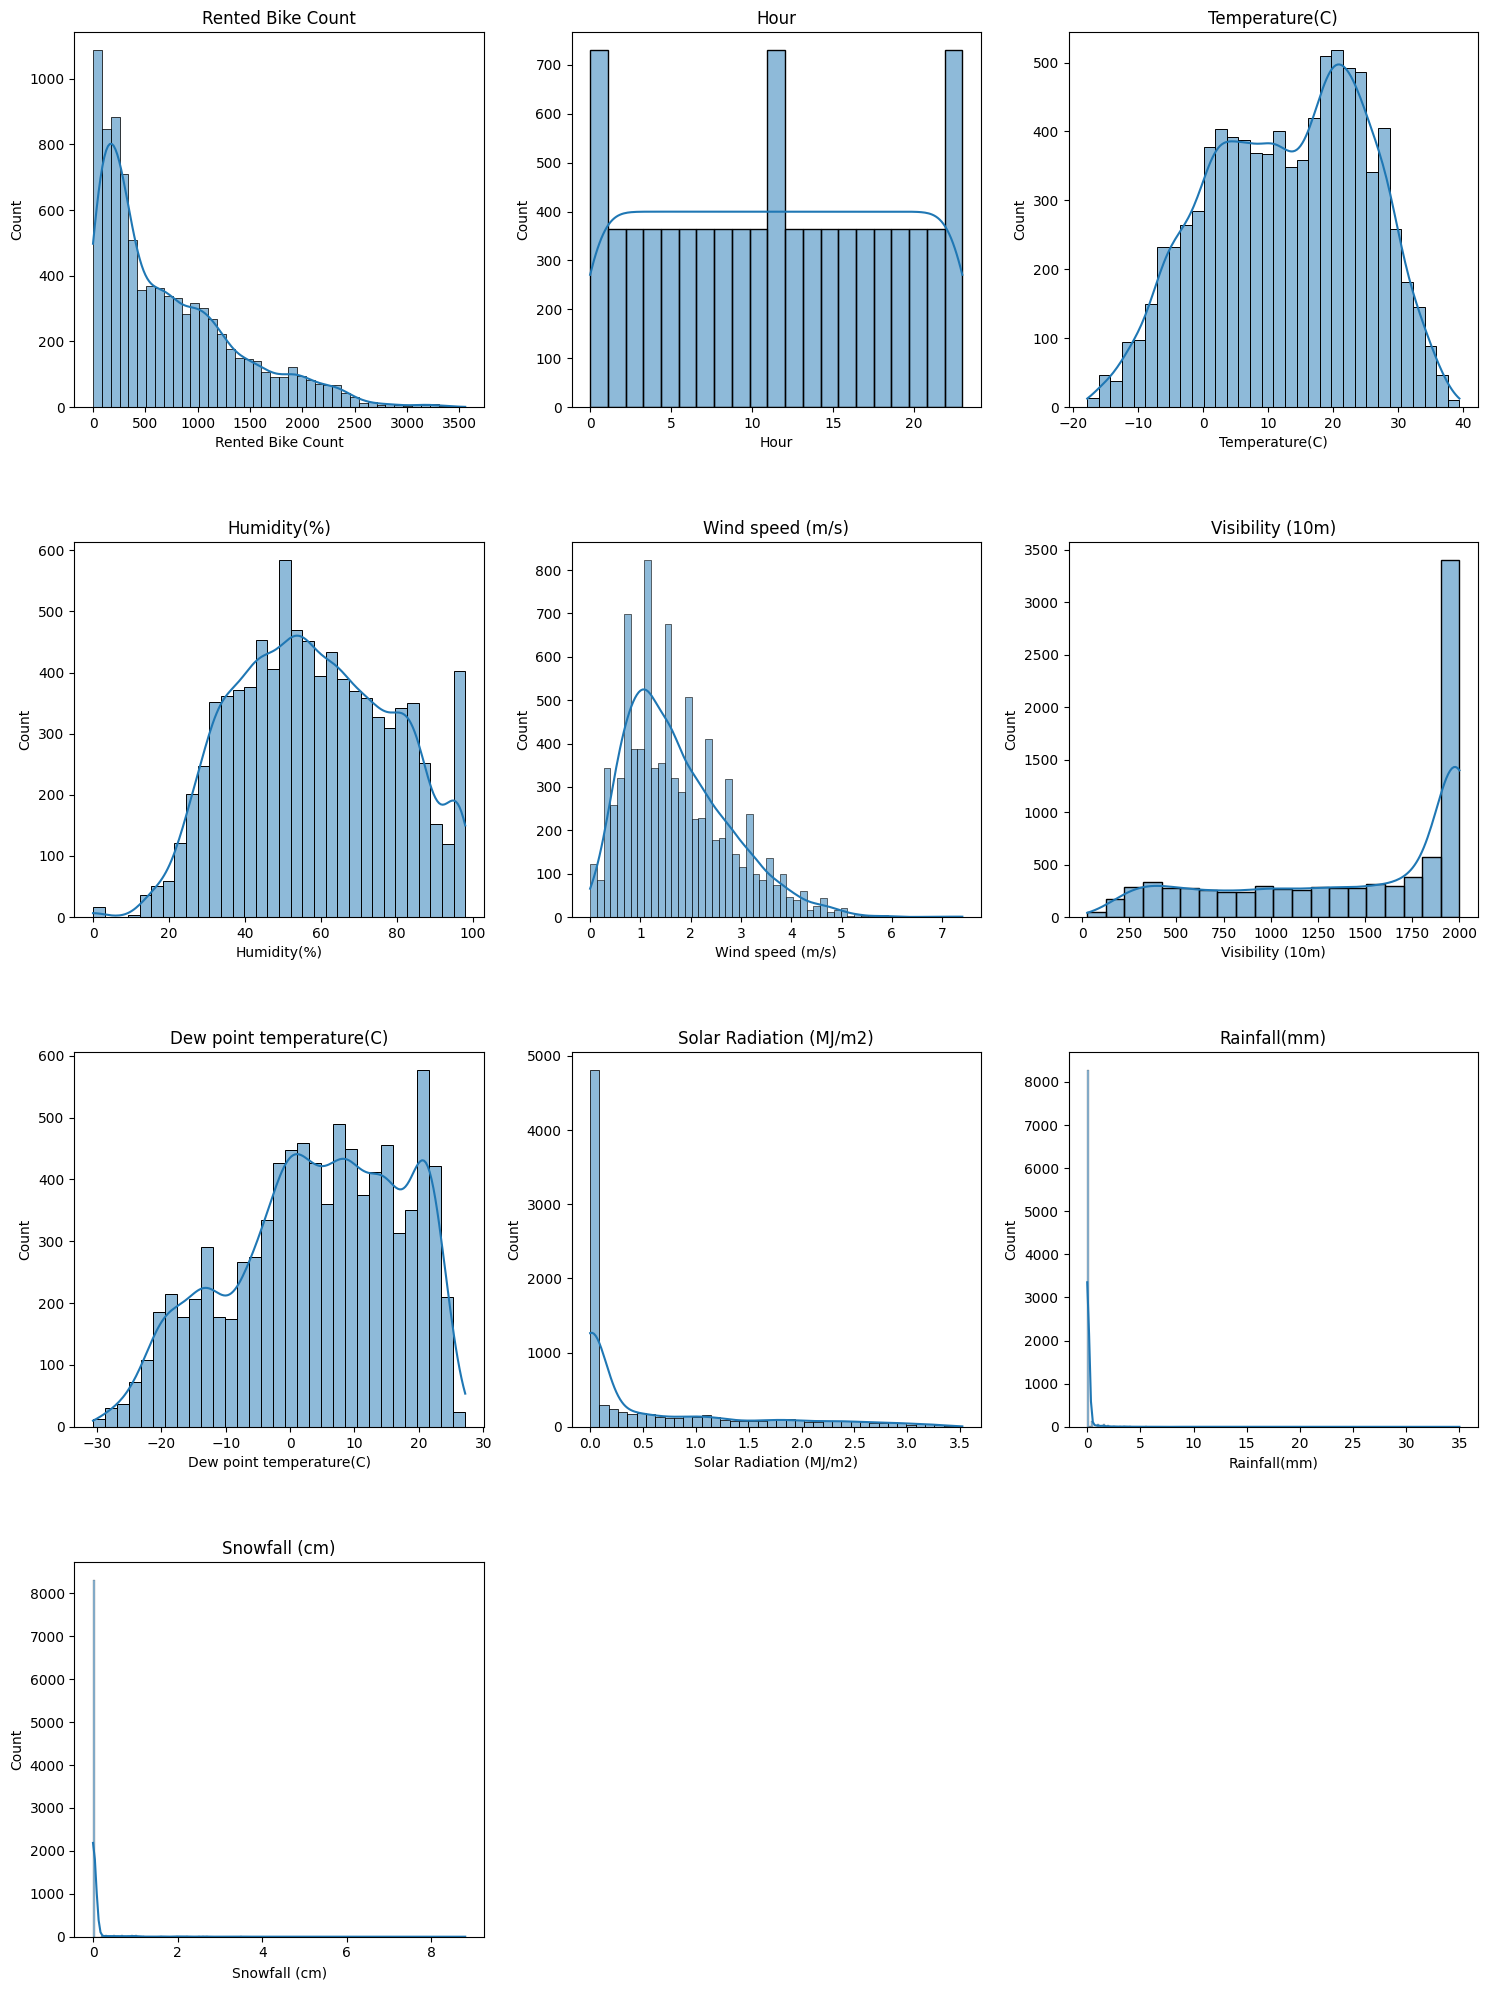

In [4]:
# I need a 3X4 plot to display 10 histograms
fig, axes = plt.subplots(nrows=(number_of_numeric_cols + 2) // 3, ncols=3, figsize=(15, 5 * ((number_of_numeric_cols + 2) // 3)))
axes = axes.flatten()

# Iterate over each numeric column and plot a historbram
for i, col in enumerate(numeric_cols):
    sns.histplot(data=df_floridabikerentals, x=col, ax=axes[i], kde=True)
    axes[i].set_title(col)

# Hide the blank/empty graphs
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

# Make plots more readable and add space
plt.tight_layout(h_pad=5)
plt.show()  

#### <b>Initial Observations Raw Numeric Feature Histograms</b> ####
    
    Rented Bike Count           - Right Skewed Distribution
    Hour                        - Looks like a Tri-Modal Distribution, as it has 3 peaks (1 at each end, and 1 in the middle)
                                - Possibly related to high use times (morning/evening rush hour/high demand, mid-day high demand)
    Temperature(C)              - Looks "like" a Normalish Distribution
    Humidity(%)                 - Looks "like" a Normalish Distribution - looks like it's got an outlier at the high end
                                - Could be considered Bimodal Distribution with 2 definite peaks
    Wind speed (m/s)            - Right Skewed Distribution
    Visibility (10m)            - Left Skewed Distribution
    Dew point temperature(C)    - Looks "like" a Normalish Distribution - or Bi/Tri-Modal (there's 2-3 peaks)
                                - Related to seasons?
    Solar Radiation (MJ/m2)     - Right Skewed Distribution
    Rainfall(mm)                - Right Skewed Distribution
    Snowfall (cm)               - Right Skewed Distribution

#### <b>Initial Bar Count plots of Raw Categoric (string) Features</b> ####

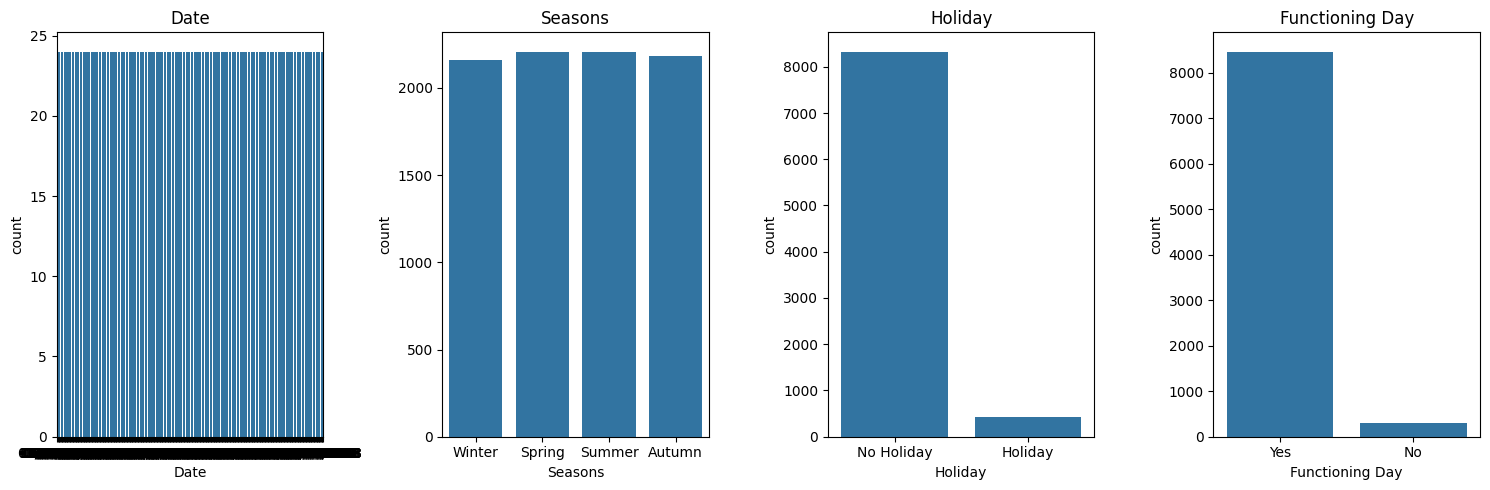

In [5]:
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(15, 5))

# Iterate over each categoric column and plot a bar count
for i, col in enumerate(original_categoric_cols):
    sns.countplot(data=df_floridabikerentals, x=col, ax=axes[i])
    axes[i].set_title(col)

plt.tight_layout()
plt.show()

#### <b>Initial Observations Raw Categoric Bar Counts</b> ####
    
    Date                        - There is an even distribution across all dates
    Seasons                     - Looks like there is an even distribution of seasons
    Holiday                     - Many more "No Holiday" days than "Holidays"
    Functioning Day             - Many more bikes rented on "Functioning Days" than non

#### <b>Create Baseline Linear Regression against the Raw Data</b> ####
    To start, I'd like to create a simple Linear Regression model using the "raw" feature data.
    Since Linear Regression requires numerical input features, categorical features will have to be encoded first.
        - Seasons                   - One-Hot Encoding - create a column for each season
        - Date                      - Break apart into Month, Year, and Day Of Week, then One-Hot-Encode    
                                    - Important note: Date is in day/month/year format    
        - Holiday, Functioning Day  - Binary Encoding, since both Features can only be 1 of 2 values

##### <b>Encode the Categorical Features</b> #####

In [6]:
#
# Encode Categorical Features
#

df_floridabikerentals_nonengineered = df_floridabikerentals.copy(deep=True)

def EncodeCategoricalFeatures(df_target):

    encoder = OneHotEncoder(sparse_output=False, drop='first')

    #
    # Encode Seasons
    #
    onehot_array = encoder.fit_transform(df_target[['Seasons']])

    # Create dataframe with proper column names
    df_onehot = pd.DataFrame(
        onehot_array,
        columns=encoder.get_feature_names_out(['Seasons']),
        index=df_target.index
    )

    # Join back to original and drop original column
    df_target = pd.concat([df_target, df_onehot], axis=1)
    df_target = df_target.drop('Seasons', axis=1)

    # Split Date into Day, Month, Year
    df_target['Date'] = pd.to_datetime(df_target['Date'], format='%d/%m/%Y')

    df_target['Month'] = df_target['Date'].dt.month
    df_target['DayOfWeek'] = df_target['Date'].dt.dayofweek    # 0=Monday, 6=Sunday
    df_target['Day'] = df_target['Date'].dt.day
    df_target['WeekOfYear'] = df_target['Date'].dt.isocalendar().week
    #df_target['DayOfYear'] = df_target['Date'].dt.dayofyear
    #df_target['Weekend'] = (df_target['Date'].dt.dayofweek >= 5).astype(int)
    df_target['Year'] = df_target['Date'].dt.year

    # Fix Year - Negatively Skewed Coeffs
    # Fix 1: Normalize Year
    df_target['Year'] = df_target['Year'] - df_target['Year'].min()
    df_target = df_target.drop('Date', axis=1)

    # print("Year min:", df_target['Year'].min())
    # print("Year max:", df_target['Year'].max())

    df_target['Holiday'] = df_target['Holiday'].map({'No Holiday': 0, 'Holiday': 1})
    df_target['Functioning Day'] = df_target['Functioning Day'].map({'No': 0, 'Yes': 1})

    return df_target

# Call Encoder function
df_floridabikerentals_nonengineered = EncodeCategoricalFeatures(df_floridabikerentals_nonengineered)
PrintDataFrameStatus(df_floridabikerentals_nonengineered)


***********************************
Description Stats
***********************************

                           count         mean         std   min    25%     50%      75%     max
Rented Bike Count         8760.0   704.602055  644.997468   0.0  191.0   504.5  1065.25  3556.0
Hour                      8760.0         11.5    6.922582   0.0   5.75    11.5    17.25    23.0
Temperature(C)            8760.0    12.882922   11.944825 -17.8    3.5    13.7     22.5    39.4
Humidity(%)               8760.0    58.226256   20.362413   0.0   42.0    57.0     74.0    98.0
Wind speed (m/s)          8760.0     1.724909      1.0363   0.0    0.9     1.5      2.3     7.4
Visibility (10m)          8760.0  1436.825799  608.298712  27.0  940.0  1698.0   2000.0  2000.0
Dew point temperature(C)  8760.0     4.073813   13.060369 -30.6   -4.7     5.1     14.8    27.2
Solar Radiation (MJ/m2)   8760.0     0.569111    0.868746   0.0    0.0    0.01     0.93    3.52
Rainfall(mm)              8760.0     0.148687

##### <b>Create Initial Linear Regression</b> #####
    - Create and run Linear Regression Model
    - Examine Statistics
    - Plot the results

Training RMSE: 425.2183

Testing RMSE: 449.3430




C:\Users\jxbma\AppData\Local\Temp\ipykernel_51536\1233388260.py:54: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[0].legend()
C:\Users\jxbma\AppData\Local\Temp\ipykernel_51536\1233388260.py:73: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[1].legend()


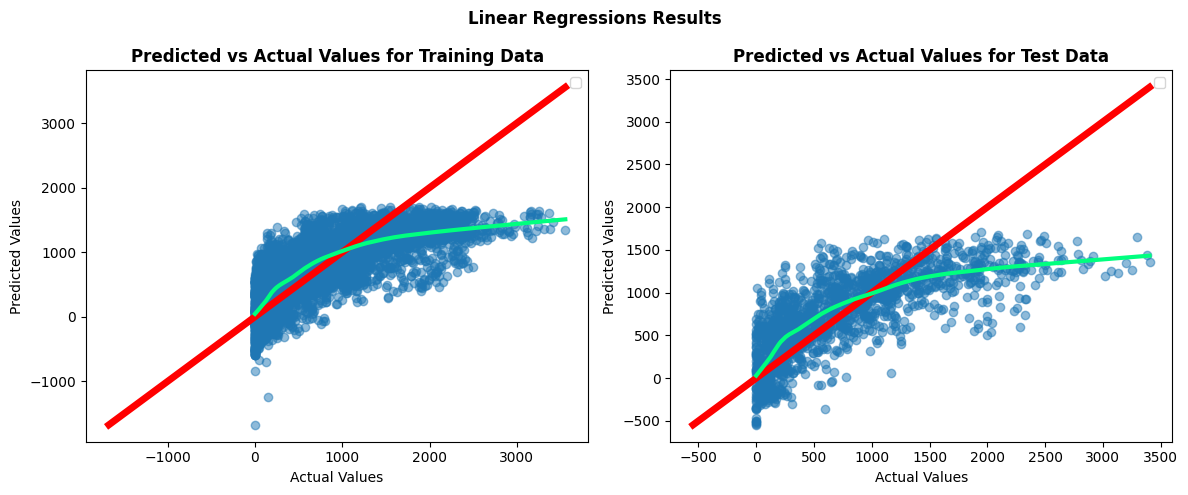

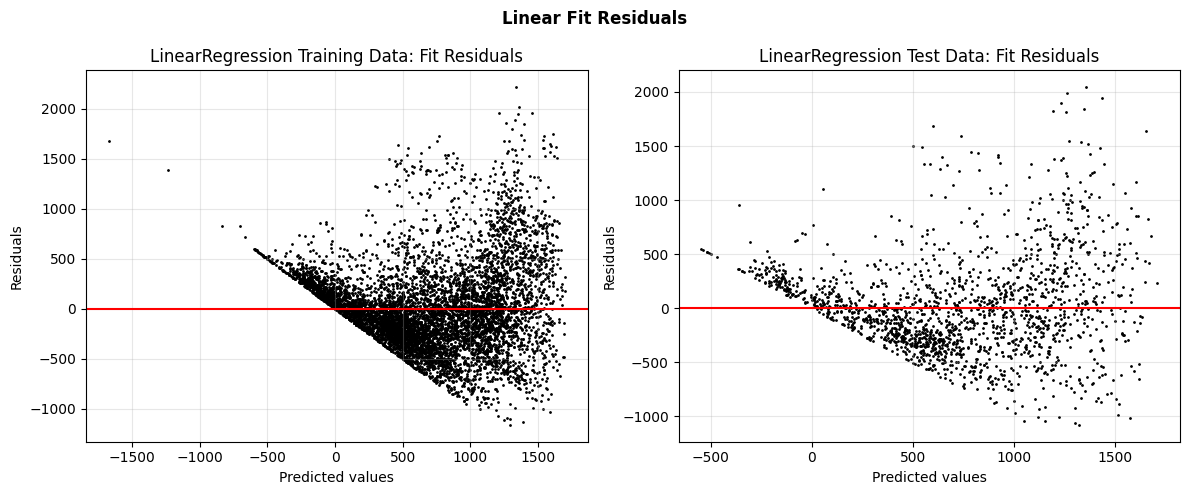



----------------------------------------------
Model Coefficients
[ 2.69015995e+01  1.88530111e+01 -1.05678024e+01  1.87661561e+01
  5.03982777e-03  8.55890950e+00 -8.20865317e+01 -5.60524332e+01
  3.35855557e+01 -1.17885407e+02  9.27762592e+02 -4.34524008e+02
 -2.96828377e+02 -7.92583802e+02  8.01952758e+01 -1.65743215e+01
  2.81182713e+00 -2.94586127e+01 -5.86960796e+02]
----------------------------------------------



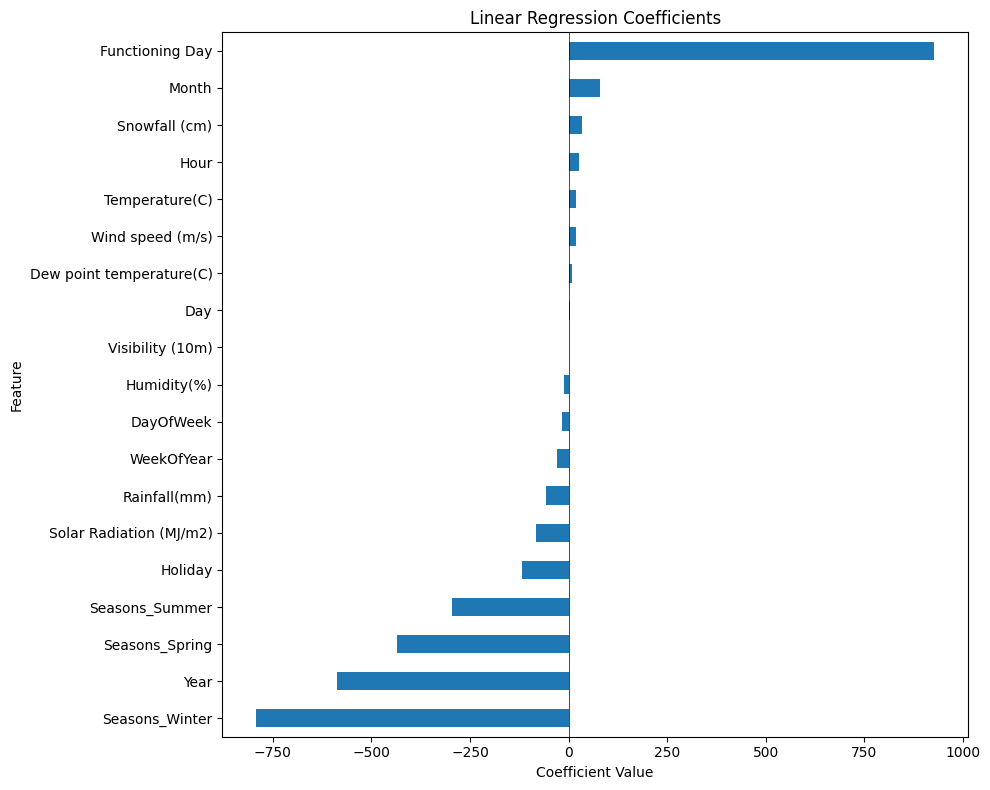


Training RMSE: 425.2183
Testing RMSE: 449.3430




In [7]:
#
# Create Linear Regression
#

def RunLinearRegression(df_target, target_label):

    X = df_target.drop(target_label, axis=1)  # DataFrame
    y = df_target[target_label]               # Series

    #
    # Split Data into Training/Test => 80/20
    #
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=315)


    linear_regression_model = LinearRegression()

    fit_result = linear_regression_model.fit( 
                                                X_train,
                                                y_train
                                            )

    train_predictions = linear_regression_model.predict(X_train)
    train_rmse = root_mean_squared_error(y_train, train_predictions)
    print(f'Training RMSE: {train_rmse:.4f}')
    print()

    test_predictions = linear_regression_model.predict(X_test)
    test_rmse = root_mean_squared_error(y_test, test_predictions)
    print(f'Testing RMSE: {test_rmse:.4f}')
    print()
    print()

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
    plt.suptitle('Linear Regressions Results', fontweight='bold')

    #
    # Train Data
    #
    # Plots
    axes[0].scatter(y_train, train_predictions, alpha=0.5)
    min_val = min(y_train.min(), train_predictions.min())
    max_val = max(y_train.max(), train_predictions.max())
    axes[0].plot([min_val, max_val], [min_val, max_val], 'r', linewidth=5)

    # LOWESS smooth line - method for showing true relationship as predictions trend against actual
    smoothed = lowess(train_predictions, y_train, frac=0.3)
    axes[0].plot(smoothed[:, 0], smoothed[:, 1], color='springgreen', linewidth=3)

    # Labels
    axes[0].set_title('Predicted vs Actual Values for Training Data', fontweight='bold')
    axes[0].set_xlabel('Actual Values')
    axes[0].set_ylabel('Predicted Values')
    axes[0].legend()

    #
    # Test Data
    #
    # Plots
    axes[1].scatter(y_test, test_predictions, alpha=0.5)
    min_val = min(y_test.min(), test_predictions.min())
    max_val = max(y_test.max(), test_predictions.max())
    axes[1].plot([min_val, max_val], [min_val, max_val], 'r', linewidth=5)

    # LOWESS smooth line
    smoothed = lowess(test_predictions, y_test, frac=0.3)
    axes[1].plot(smoothed[:, 0], smoothed[:, 1], color='springgreen', linewidth=3)

    # Labels
    axes[1].set_title('Predicted vs Actual Values for Test Data', fontweight='bold')
    axes[1].set_xlabel('Actual Values')
    axes[1].set_ylabel('Predicted Values')
    axes[1].legend()
    
    # Make plots more readable and add space
    plt.tight_layout(h_pad=5)
    plt.show()   
    print()
    print()


    # Plot Residuals
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
    plt.suptitle('Linear Fit Residuals', fontweight='bold')

    #
    # Train Data
    #
    residuals_lr = y_train - train_predictions
    axes[0].set_title('LinearRegression Training Data: Fit Residuals')
    axes[0].scatter(train_predictions, residuals_lr, c='black', s=1)
    axes[0].axhline(y=0, color='r')
    axes[0].set_xlabel('Predicted values')
    axes[0].set_ylabel('Residuals')
    axes[0].grid(True, alpha=0.3)

    #
    # Test Data
    #
    residuals_lr = y_test - test_predictions
    axes[1].set_title('LinearRegression Test Data: Fit Residuals')
    axes[1].scatter(test_predictions, residuals_lr, c='black', s=1)
    axes[1].axhline(y=0, color='r')
    axes[1].set_xlabel('Predicted values')
    axes[1].set_ylabel('Residuals')
    axes[1].grid(True, alpha=0.3)

    # Make plots more readable and add space
    plt.tight_layout(h_pad=5)
    plt.show()   
    print()
    print()

    #
    #  Plot Linear Coefficients
    #
    print('----------------------------------------------')
    print('Model Coefficients')
    print(fit_result.coef_)
    print('----------------------------------------------')
    print()

    coefficients = pd.Series(linear_regression_model.coef_, index=X_train.columns)
    coefficients_sorted = coefficients.sort_values()

    plt.figure(figsize=(10, 8))
    coefficients_sorted.plot(kind='barh')
    plt.xlabel('Coefficient Value')
    plt.ylabel('Feature')
    plt.title('Linear Regression Coefficients')
    plt.axvline(x=0, color='black', linewidth=0.5)
    plt.tight_layout()
    plt.show()

    print()
    print(f'Training RMSE: {train_rmse:.4f}')
    print(f'Testing RMSE: {test_rmse:.4f}')
    print()

    return linear_regression_model

# Run the Linear Regression and plot/display results
RunLinearRegression(df_floridabikerentals_nonengineered, 'Rented Bike Count')
print()


##### <b>Analysis of Initial Linear Regression</b> #####
    - Actual versus predicted value scatter plot
        Red line indicates perfect predictions and green line shows actual model performance.
        Model starts out roughly following perfect predictions, but begins to curve as bike demand increases
        Model does not perform well as demand of bikes increases (under predicts)

    - Residuals Plot
        If this was a good model, the points would be scattered closely around the zero line.
        Reinforces findings of Scatter Plot - points are not even distributed
        Wider spread of residuals as bike demand increases (higher errors/differences)

    - Model Coefficients
        Coeffients tell us how much each feature affects the prediction (positive/negative)
        "Functioning Day" has the highest positive effect
        Visibility appears to have little or no effect
        Seasons have high effect - worse season (Winter/Spring) negatively affects outcome
        General reported weather conditions seem to have a low effect


## <u>**2. Data Wrangling**</u> ##

The next step is to clean/transform model features in a more usable/performant form.</br>


##### <b>Encode the Categorical Features</b> #####
    The first step is to encode the categorical features into numeric values.
    We did this previously to test on the raw data. Just repeat the process here.

In [8]:
#
# Encode the data
#

df_floridabikerentals_new = EncodeCategoricalFeatures(df_floridabikerentals_new)
#PrintDataFrameStatus(df_floridabikerentals_new)
print('Feature Encoding Completed')

Feature Encoding Completed


#### <b>Data Type Conversion</b> ####
    The next step is to convert data types into optimal performance types
        Rented Bike Count         int64     ==> int16    
        Hour                      int64     ==> int8    
        Humidity(%)               int64     ==> int8    
        Visibility (10m)          int64     ==> int16    
        Holiday                   int64     ==> int8    
        Functioning Day           int64     ==> int8  
        Seasons_Spring            float64	==> int8
        Seasons_Summer            float64   ==> int8
        Seasons_Winter            float64   ==> int8
        Month                     int32     ==> int8
        DayOfWeek                 int32     ==> int8
        Year                      int32     ==> int8  

    Looking at Visibility in terms of 10m increments seems a little odd.
    Normalize this to be actual meters (multiply values by 10) and rename the column.

In [9]:
# Data Type Conversions

columns = ['Hour','Humidity(%)','Holiday','Functioning Day','Seasons_Spring', 
           'Seasons_Summer','Seasons_Winter','Month','DayOfWeek','Year' ]
df_floridabikerentals_new[columns] = df_floridabikerentals_new[columns].astype('int8')

columns = ['Rented Bike Count','Visibility (10m)']
df_floridabikerentals_new[columns] = df_floridabikerentals_new[columns].astype('int16')

# Normalize Visibility column
df_floridabikerentals_new['Visibility'] = (df_floridabikerentals_new['Visibility (10m)'] * 10).astype('int16')
df_floridabikerentals_new = df_floridabikerentals_new.drop('Visibility (10m)', axis=1)

#PrintDataFrameStatus(df_floridabikerentals_new)
print('Data Type Conversions Completed')


Data Type Conversions Completed


#### <b>Plot Correlations between Features and Predicted Bike Rentals</b> ####
Plot the correlation between all the features relative to bike rentals

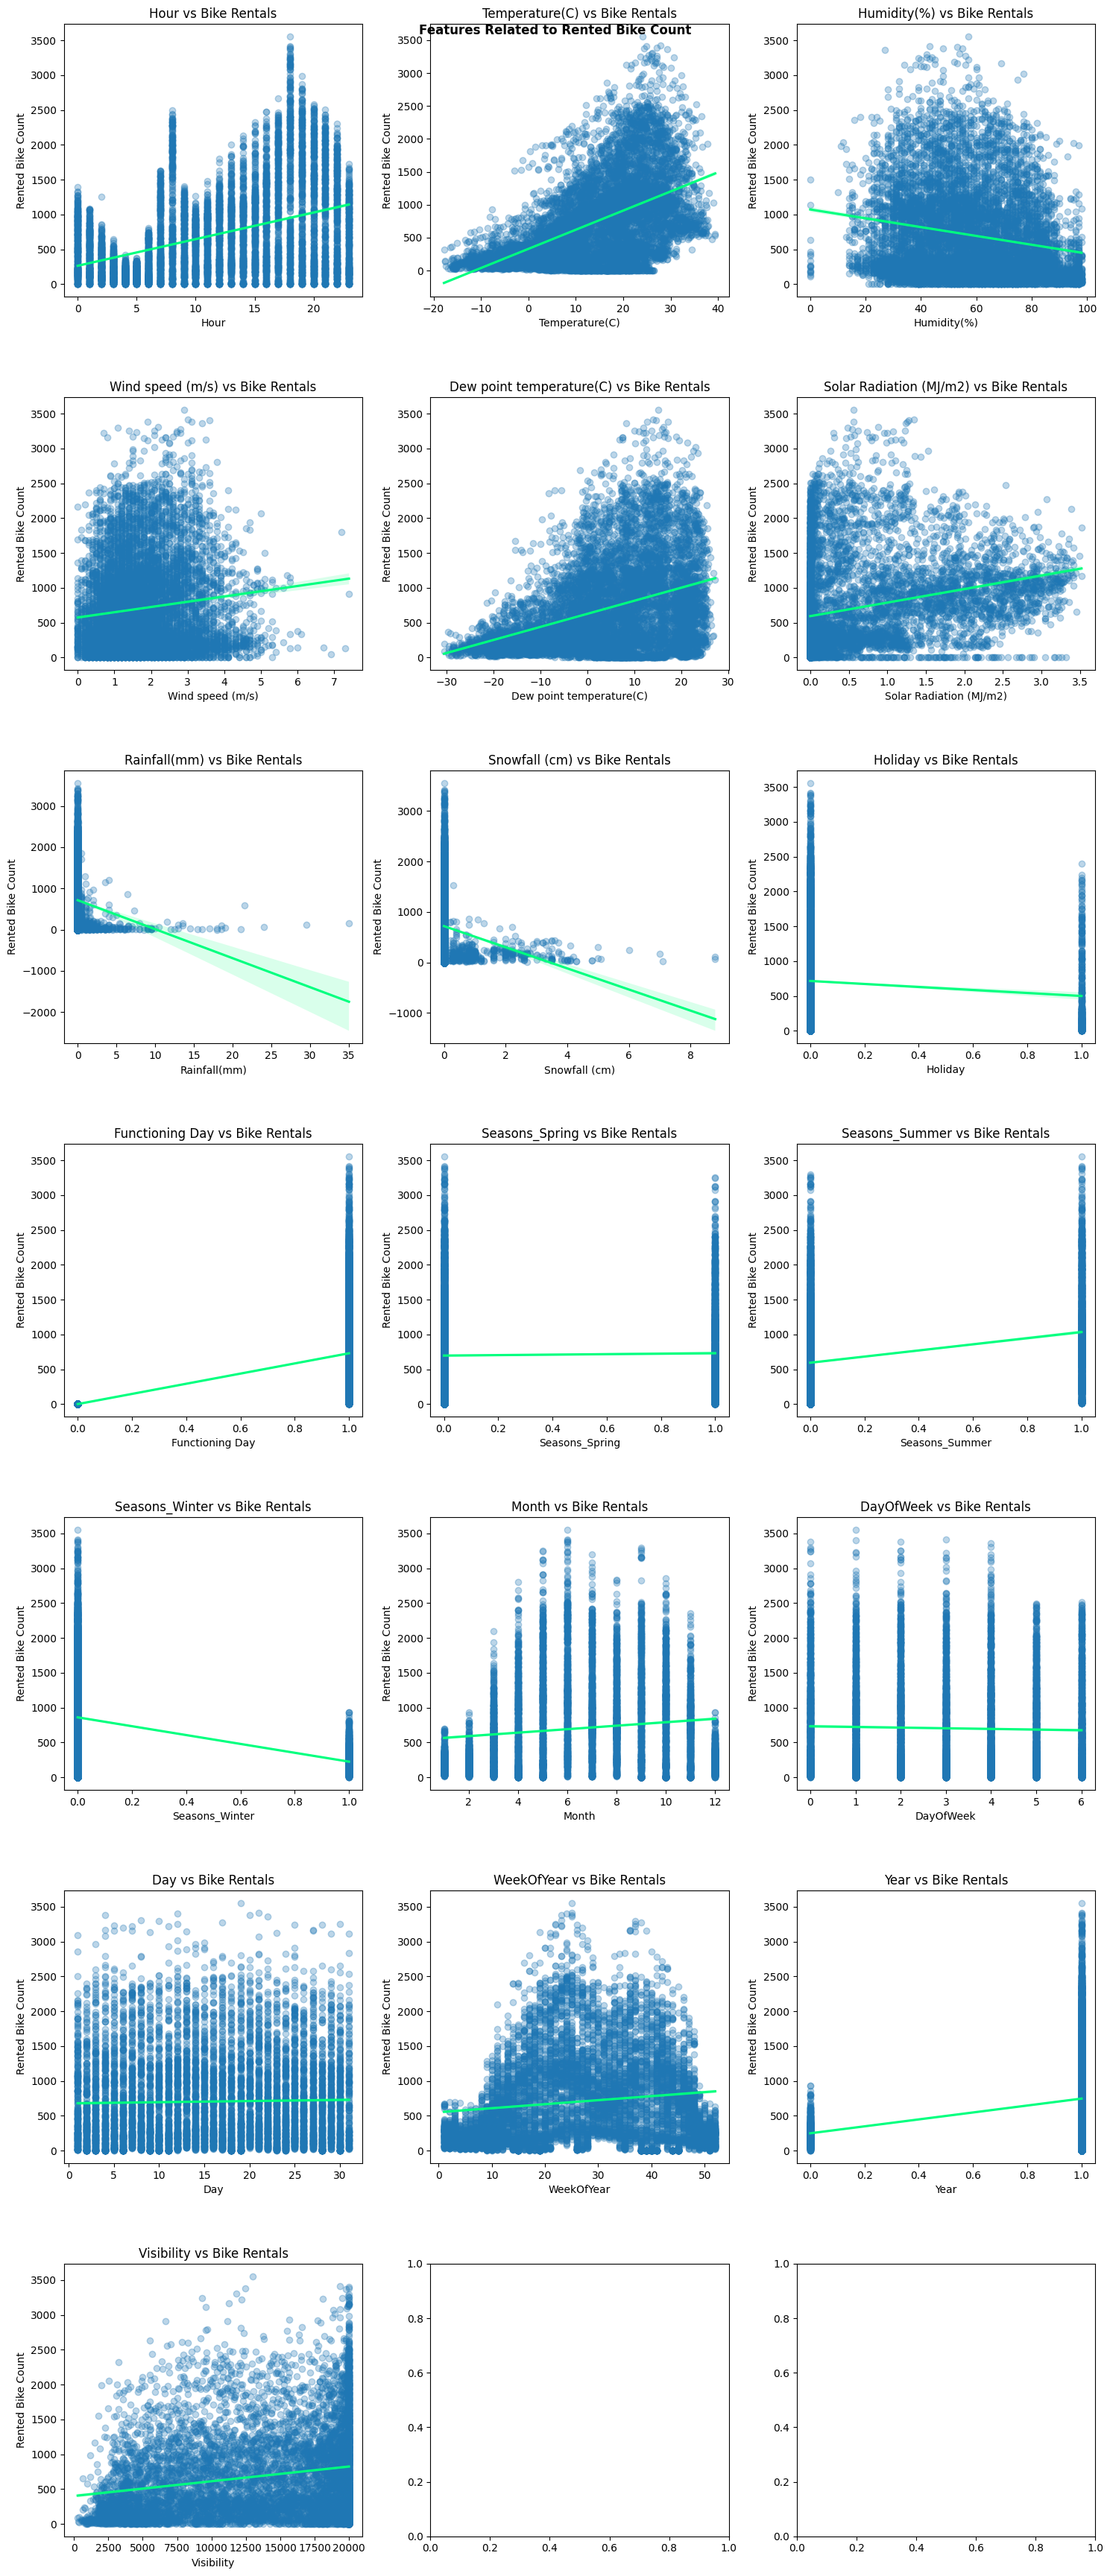

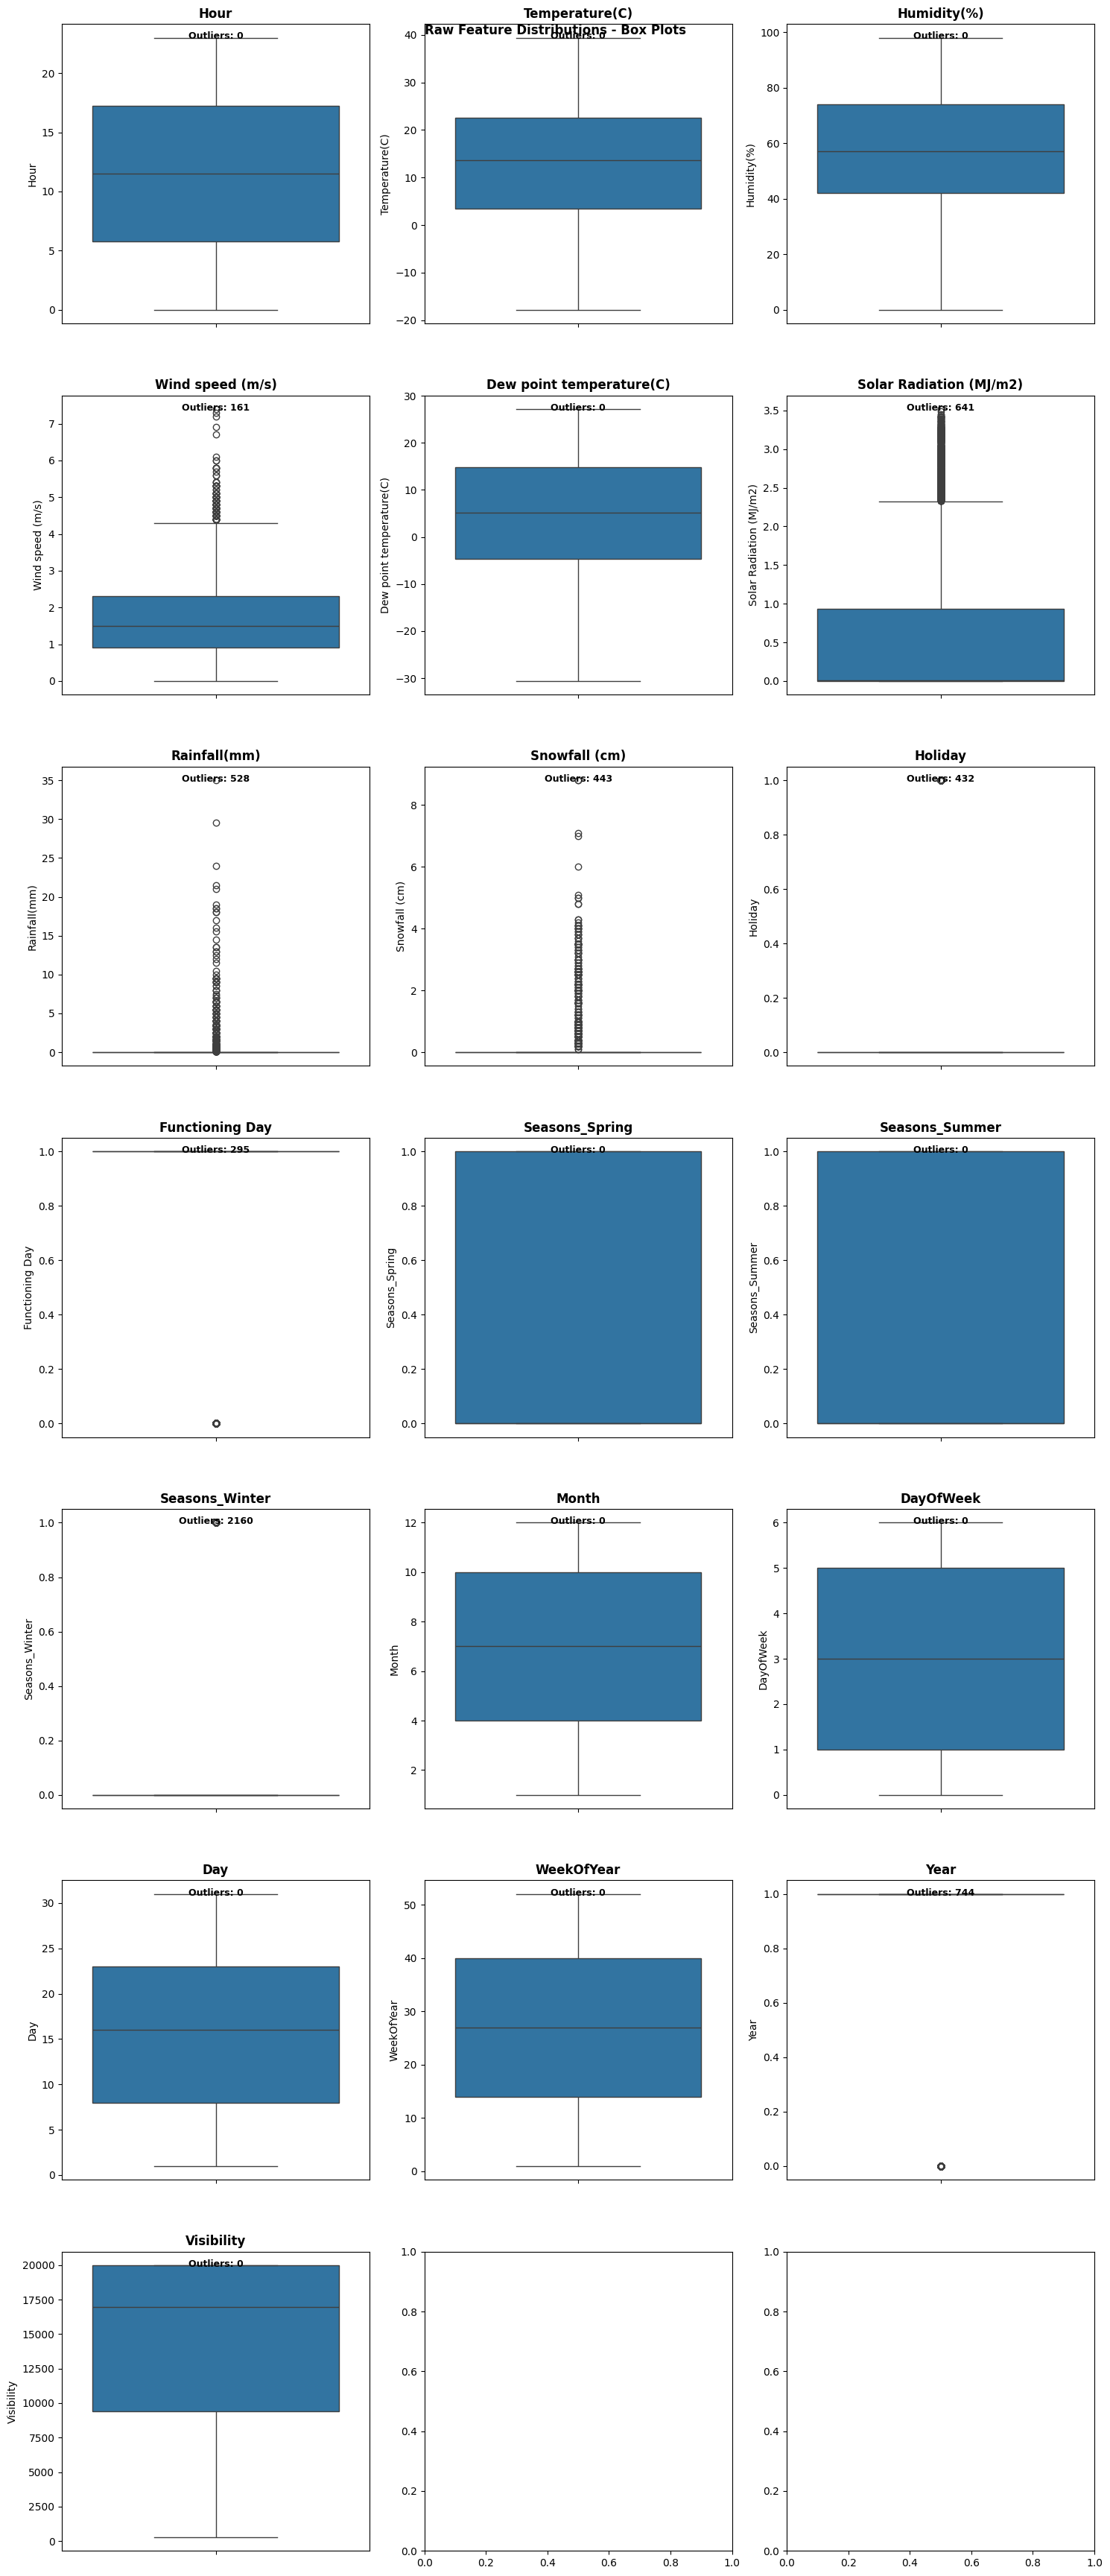

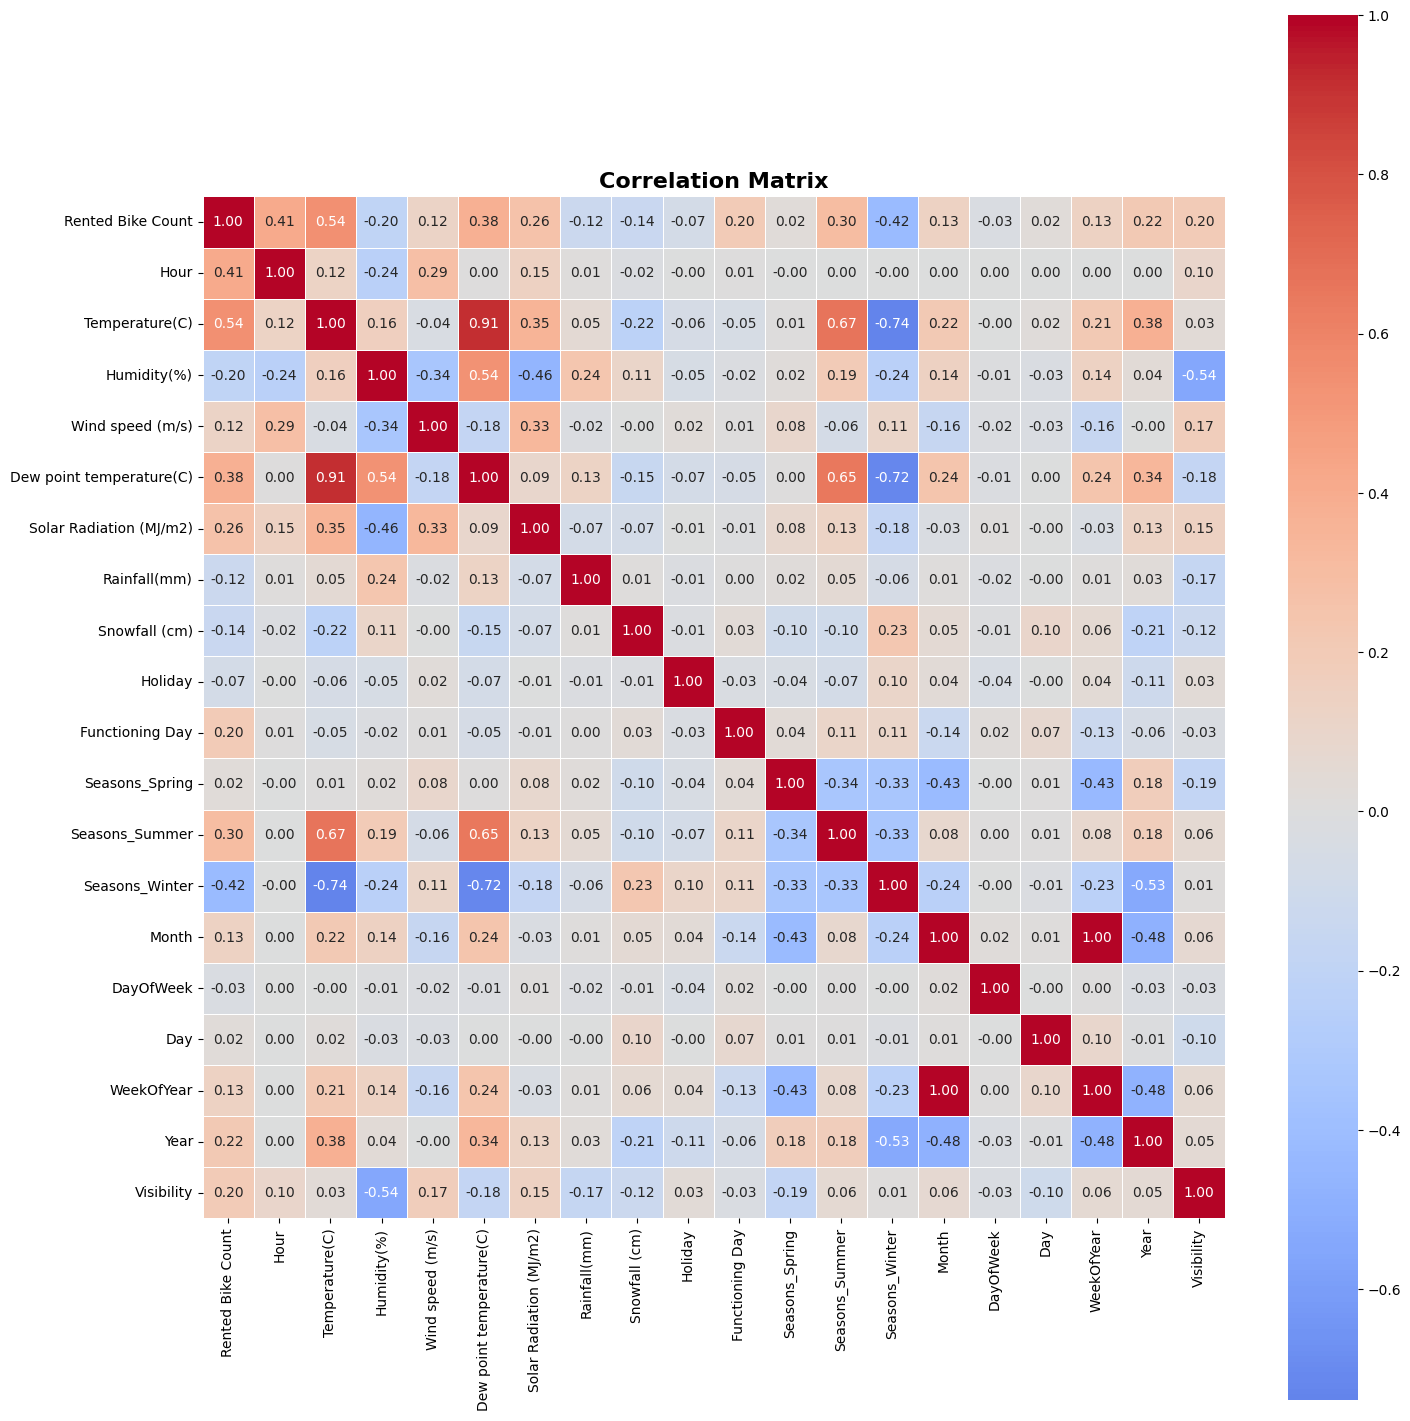

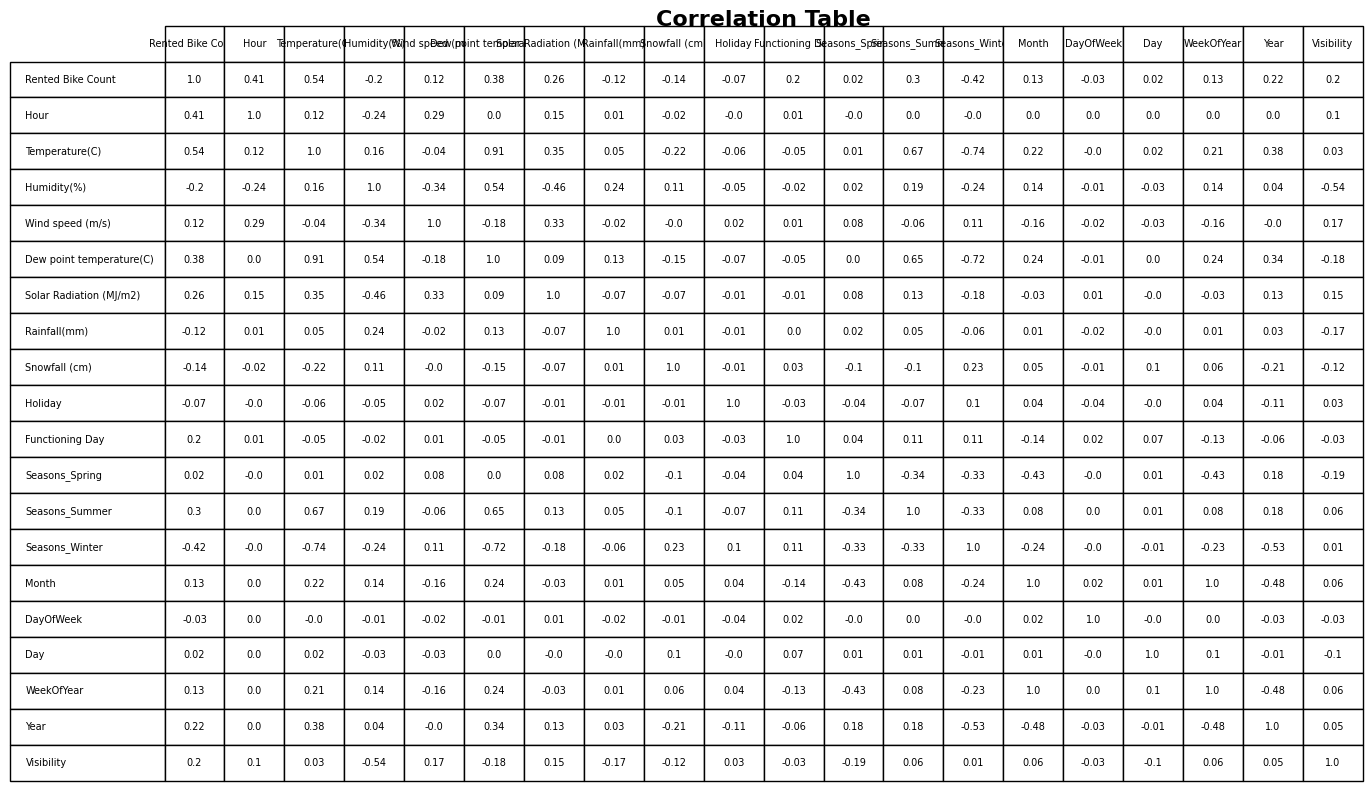

In [10]:
#
# Features to Bike Rentals Correlations
#
def PlotBoxPlotsToViewDistributions(df_target):

    columns = df_target.select_dtypes(include='number').columns.drop('Rented Bike Count').tolist()
    n_cols = len(columns)

    fig, axes = plt.subplots(nrows=(n_cols + 2) // 3, ncols=3, figsize=(15, 5 * ((n_cols + 2) // 3)))
    axes = axes.flatten()

    plt.suptitle('Raw Feature Distributions - Box Plots', fontweight='bold')
    plt.tight_layout(rect=[0, 0, 1, 0.90])  # Leave space at top

    #Iterate over each numeric column and plot a historgram
    for i, col in enumerate(columns):
        sns.boxplot(data=df_target, y=col, ax=axes[i])    
        axes[i].set_title(col, fontweight='bold')

        # Optional: Add count of outliers
        Q1 = df_target[col].quantile(0.25)
        Q3 = df_target[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        outlier_count = len(df_target[(df_target[col] < lower) | 
                                            (df_target[col] > upper)])
        axes[i].text(0.5, 0.95, f'Outliers: {outlier_count}', 
                    transform=axes[i].transAxes, ha='center', fontsize=9, fontweight='bold')

    # Make plots more readable and add space
    plt.tight_layout(h_pad=5)
    plt.show() 

def DisplayCorrelationMatrixPlots(df_target):
        corr = df_target.corr()
        # print(type(corr))
        # print(corr)

        # Create heatmap
        plt.figure(figsize=(15, 15))
        sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm', center=0,
                    square=True, linewidths=0.5)
        plt.title('Correlation Matrix', fontsize=16, fontweight='bold')
        plt.tight_layout()
        plt.show()

        print()
        print()    
        
        # Table
        plt.figure(figsize=(14, 8))
        plt.axis('off')
        table = plt.table(
            cellText=corr.round(2).values,
            rowLabels=corr.index,
            colLabels=corr.columns,
            cellLoc='center',
            loc='center'
        )
        table.auto_set_font_size(False)
        table.set_fontsize(7)
        table.scale(1.2, 1.8)
        plt.title('Correlation Table', fontweight='bold', fontsize=16)
        plt.tight_layout()
        plt.show()

def DisplayFeatureCorrelationInfo(df_target, display_box_plots=True, display_correlation_matrix=True):
    
    columns = df_target.columns.drop('Rented Bike Count').tolist()
    n_cols = len(columns)

    fig, axes = plt.subplots(nrows=(n_cols + 2) // 3, ncols=3, figsize=(15, 5 * ((n_cols + 2) // 3)))
    axes = axes.flatten()

    plt.tight_layout(rect=[0, 0, 1, 0.90])  # Leave space at top
    plt.suptitle('Features Related to Rented Bike Count', fontweight='bold')

    for i, col in enumerate(columns):
        sns.regplot(data=df_target, x=col, y='Rented Bike Count', 
                    scatter_kws={'alpha': 0.3}, ax=axes[i],
                    line_kws={'color': 'springgreen'})
        axes[i].set_title(f'{col} vs Bike Rentals')

    # Make plots more readable and add space
    plt.tight_layout(h_pad=5)
    plt.show()  
    print()
    print()

    if display_box_plots == True:
        PlotBoxPlotsToViewDistributions(df_target)

    if display_correlation_matrix == True:
        DisplayCorrelationMatrixPlots(df_target)

DisplayFeatureCorrelationInfo(df_floridabikerentals_new)


#### <b>Additional Potential Data Issues from Imported Data</b> ####
Examining Features for potential issues - (missing values?)
### ###
    Humidity(%)               8760.0     58.226256    20.362413    0.0    42.00     57.00     74.00     98.00
    Wind speed (m/s)          8760.0      1.724909     1.036300    0.0     0.90      1.50      2.30      7.40
    Dew point temperature(C)  8760.0      4.073813    13.060369  -30.6    -4.70      5.10     14.80     27.20
    Solar Radiation (MJ/m2)   8760.0      0.569111     0.868746    0.0     0.00      0.01      0.93      3.52

    Wind Speed - Its possible to have a totally calm day with absolutely no wind. We can't discern between real calm
    days and instances of missing/bad data. Leave it as it is.

    Solar Radiation - It's possible to have zero (0) Solar Radiation - night time. We can't discern between night time
    (legitimate) and missing data. Leave it as is.

    Humidity - Zero (0) percent humidity is extremely rare (even in desert climates). These values should be considered
    suspicious and treated as missing data. We should either treat as missing values or establish a reasonable threshold 
    and apply it to the feature. Given this data set originates from Florida, exceedingly now humidity is highly improbable.
    Establish a reasonable lower bounds threshold.

    Dew Point Temperature - a dew point temeprature of -30.6 degrees is highly unlikely and should be treated as 
    bad/suspicious data, especially given that our data set is Florida based, which is typically a hot/warm/humid evironment.
    We should establish a reasonable threshold and apply it to the feature.

#### <b>Histogram plots of Humidity and Dew Point</b> ####

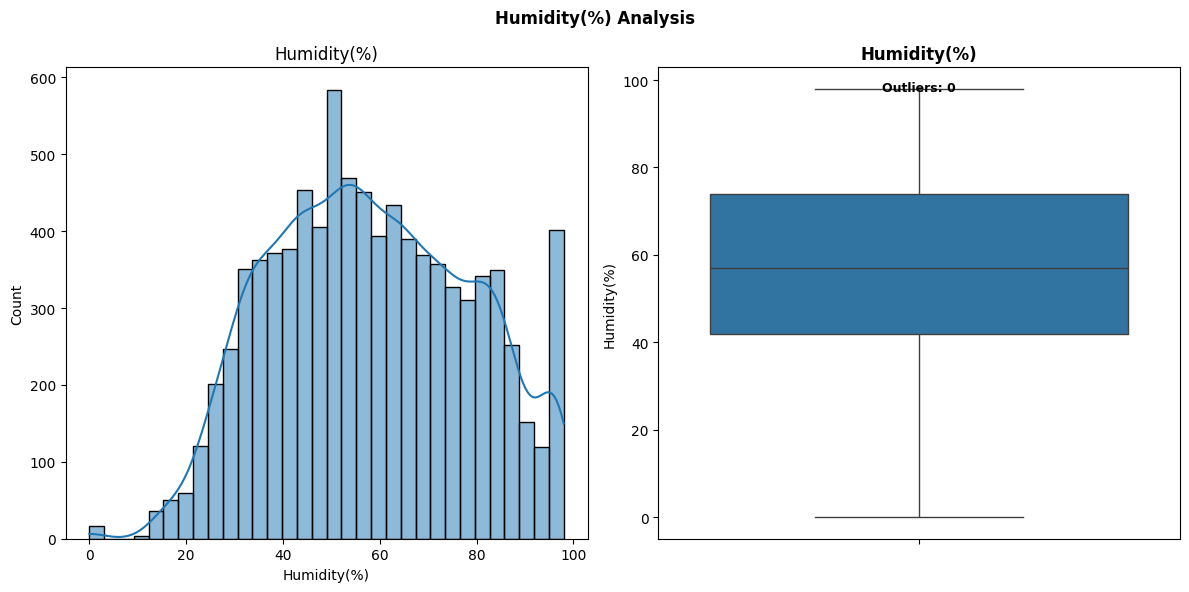

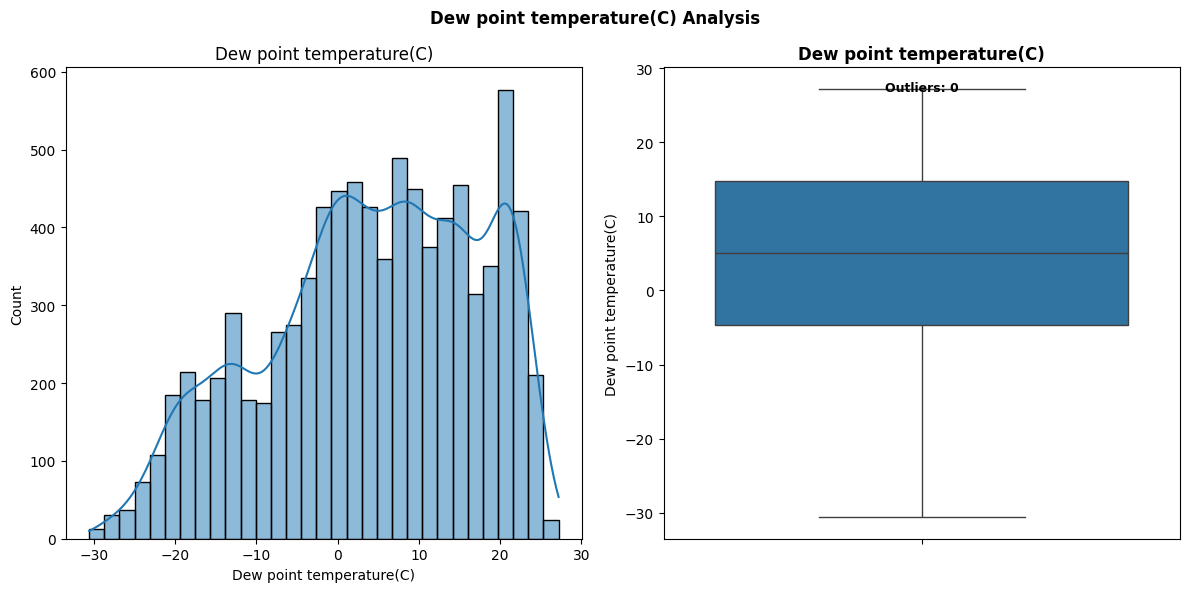

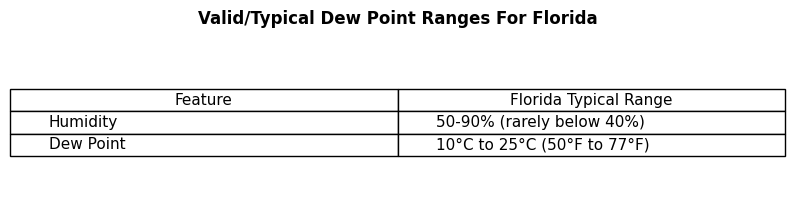



Number of rows in the data set:8760
Humidity below 30%:641
Percentage of DataSet with Humidity Data Issues:7.32%
Dew Point below 0°C: 3138
Percentage of DataSet with Dew Point Data Issues:35.82%


In [11]:

columns = ['Humidity(%)','Dew point temperature(C)']

for i, col in enumerate(columns):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,6))
    axes = axes.flatten()

    plt.tight_layout(rect=[0, 0, 1, 0.90])  # Leave space at top
    plt.suptitle(f'{col} Analysis', fontweight='bold')

    # Histogram
    iPlot = 0
    sns.histplot(data=df_floridabikerentals_new, x=col, ax=axes[iPlot], kde=True)
    axes[iPlot].set_title(col)
    iPlot += 1

    # BoxPlot
    sns.boxplot(data=df_floridabikerentals_new, y=col, ax=axes[iPlot])    
    axes[iPlot].set_title(col, fontweight='bold')

    # Optional: Add count of outliers
    Q1 = df_floridabikerentals_new[col].quantile(0.25)
    Q3 = df_floridabikerentals_new[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    outlier_count = len(df_floridabikerentals_new[(df_floridabikerentals_new[col] < lower) | 
                                        (df_floridabikerentals_new[col] > upper)])
    axes[iPlot].text(0.5, 0.95, f'Outliers: {outlier_count}', 
                transform=axes[iPlot].transAxes, ha='center', fontsize=9, fontweight='bold')

    # Make plots more readable and add space
    plt.tight_layout(h_pad=5)
    plt.show()  
    print()
    print()

print()
print()

fig, ax = plt.subplots(figsize=(8, 2))
ax.axis('off')

plt.suptitle(f'Valid/Typical Dew Point Ranges For Florida', fontweight='bold')

table_data = [
    ['Humidity', '50-90% (rarely below 40%)'],
    ['Dew Point', '10°C to 25°C (50°F to 77°F)']
]

table = ax.table(
    cellText=table_data,
    colLabels=['Feature', 'Florida Typical Range'],
    loc='center',
    cellLoc='left'
)

table.auto_set_font_size(False)
table.set_fontsize(11)
table.scale(1.2, 1.5)

plt.tight_layout(h_pad=5)
plt.show()   
print()
print()

print(f'Number of rows in the data set:{len(df_floridabikerentals_new)}')
bad_values = (df_floridabikerentals_new['Humidity(%)'] < 30).sum()
print(f"Humidity below 30%:{bad_values}")
percentage_of_errors = (bad_values/len(df_floridabikerentals_new)) * 100
print(f'Percentage of DataSet with Humidity Data Issues:{percentage_of_errors:.2f}%')

bad_values = (df_floridabikerentals_new['Dew point temperature(C)'] < 0).sum()
print(f"Dew Point below 0°C: {bad_values}" )
percentage_of_errors = (bad_values/len(df_floridabikerentals_new)) * 100
print(f'Percentage of DataSet with Dew Point Data Issues:{percentage_of_errors:.2f}%')

#### <b>Humidity and Dew Point Plot Analysis</b> ####
    First, there don't appear to be any outliers for Dew Point or Humidity.
    
    Examining the typical Humidity/Dew Point ranges as they relate to our data set, 
    we see substantial values which are outside of the expected range (on the negative side).
    
    Humidity - approximately 7% of the data values are below expected norms. Clip the data.

    Dew Point - 36% of the data is outside the expected norms. Is there a strong direct correlation between humidity and bike rentals?
        Options include:
            - Drop the feature - 36% of it looks questionable
            - Keep it as is 
            - Select a new less restrictive threshold.
            
    Course of action - drop the column. We can always come back and re-evaluate this.

    

In [12]:
#
# Clip Humidity
#
df_floridabikerentals_new['Humidity(%)'] = df_floridabikerentals_new['Humidity(%)'].clip(lower=30)

#
# Drop Humidity
#
df_floridabikerentals_new = df_floridabikerentals_new.drop('Dew point temperature(C)', axis=1)


#### <b>Adding New (Complex/Combination) New Features to DataSet</b> ####

##### <b>Add Features</b> #####
    Create new features:
        - Normalized (Ratio)
        - Difference Features
        - Tranformed (log/sqrt)
        - Free Form Features

c:\Users\jxbma\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


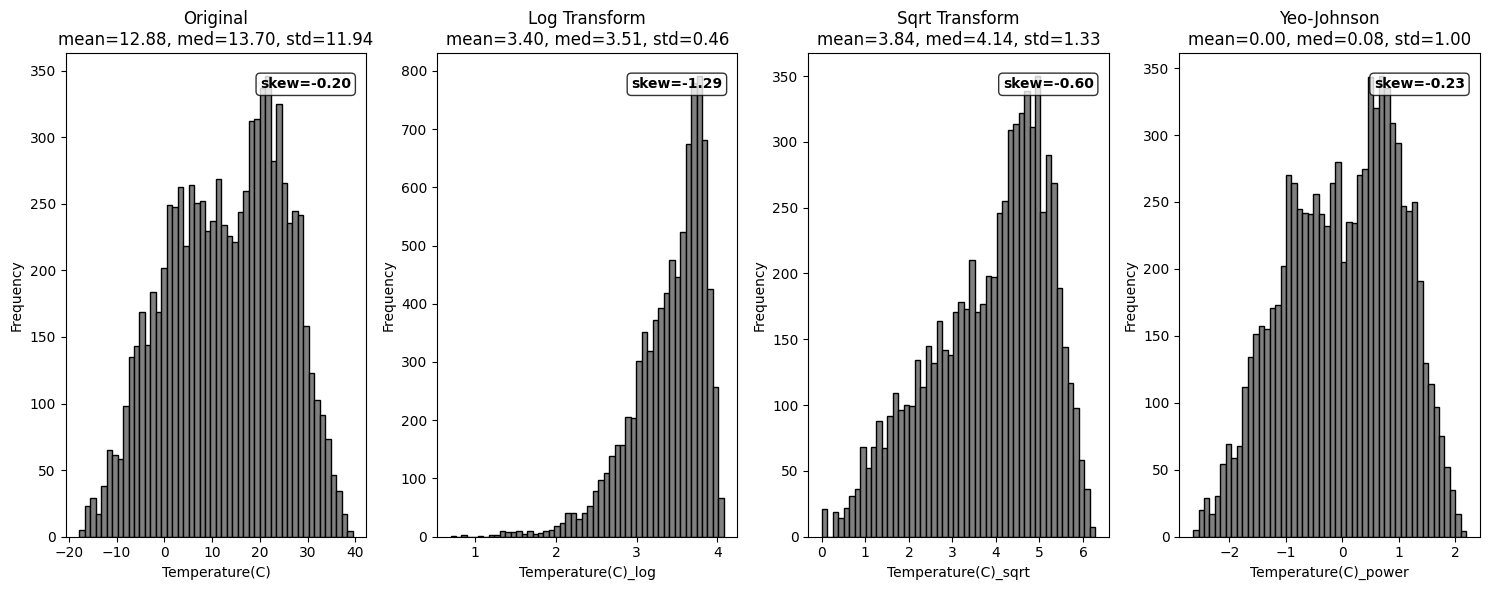

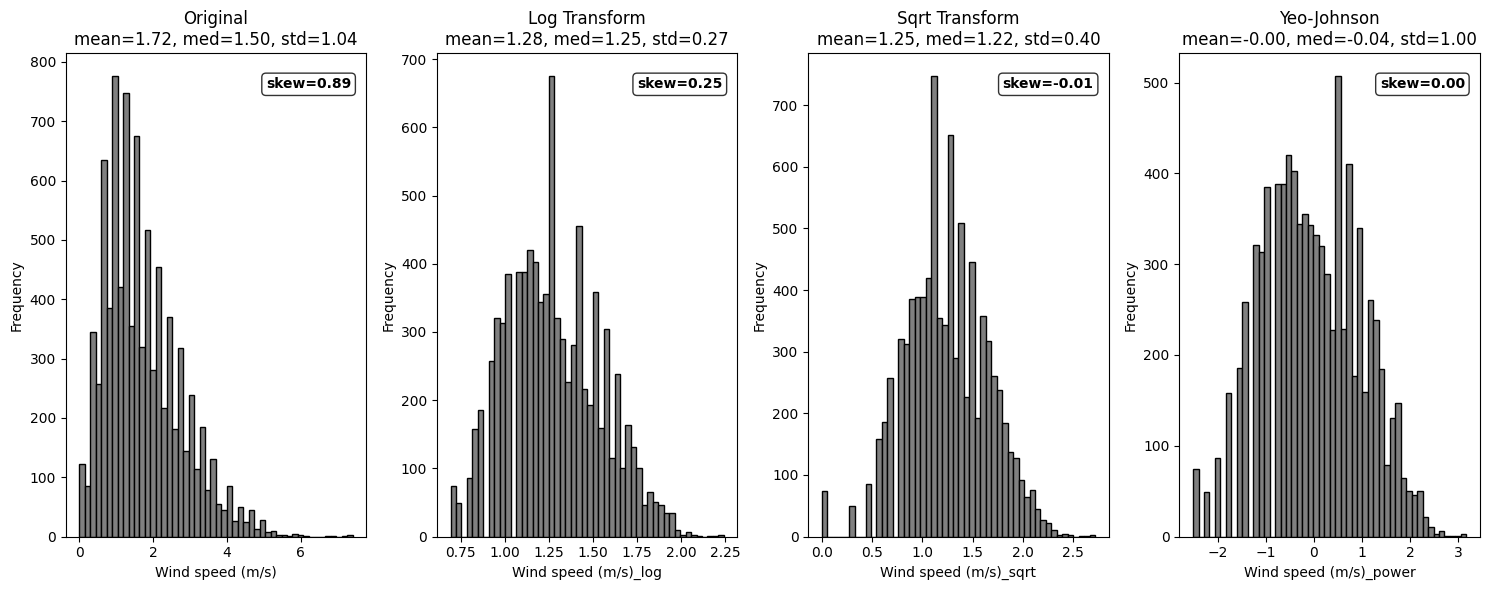

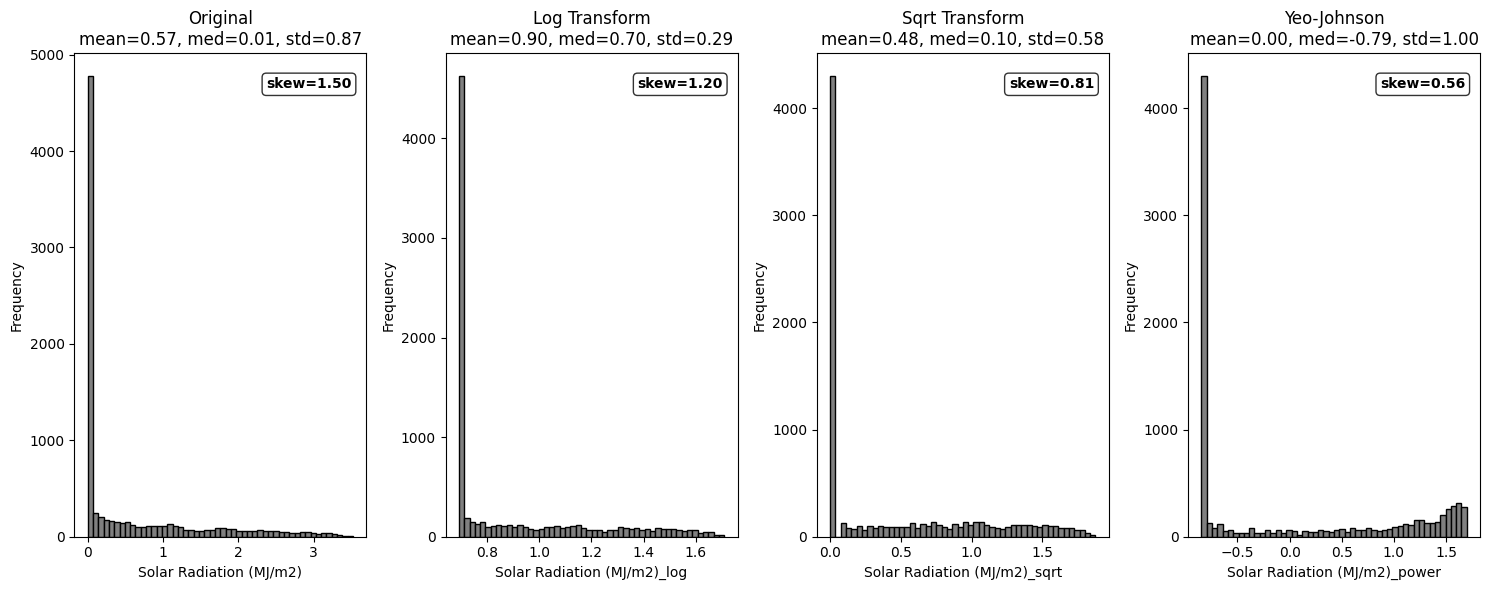

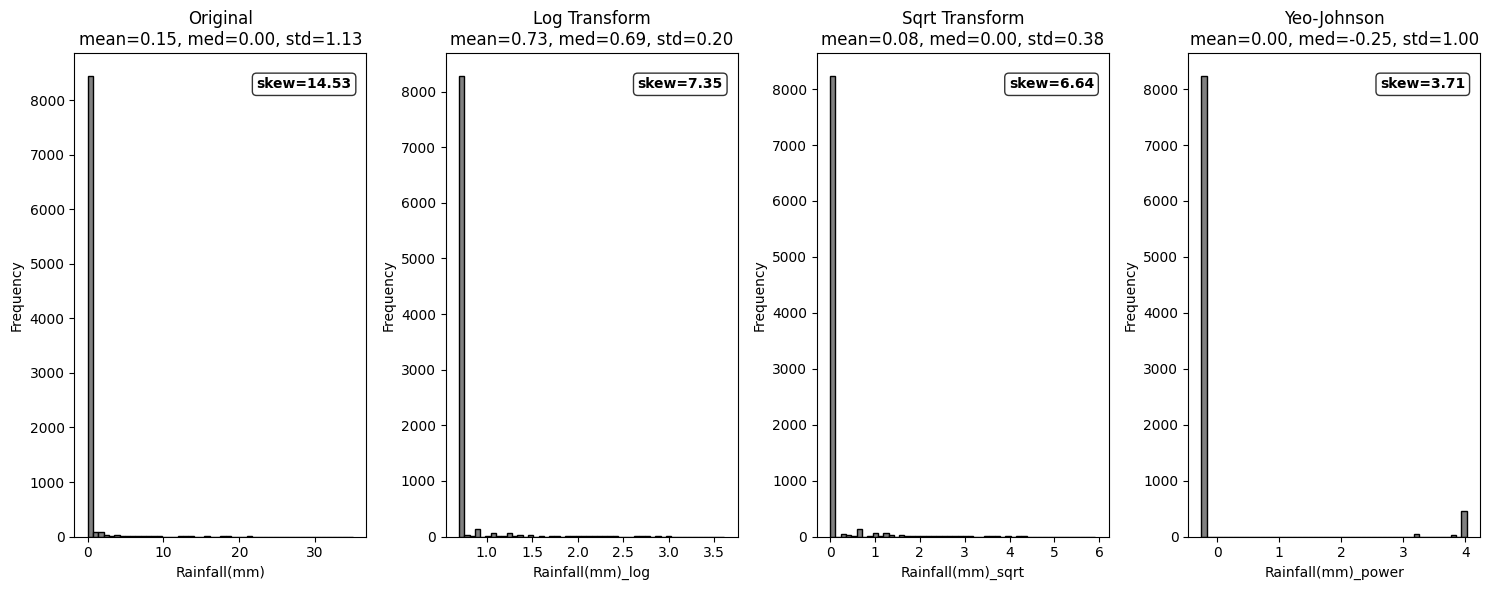

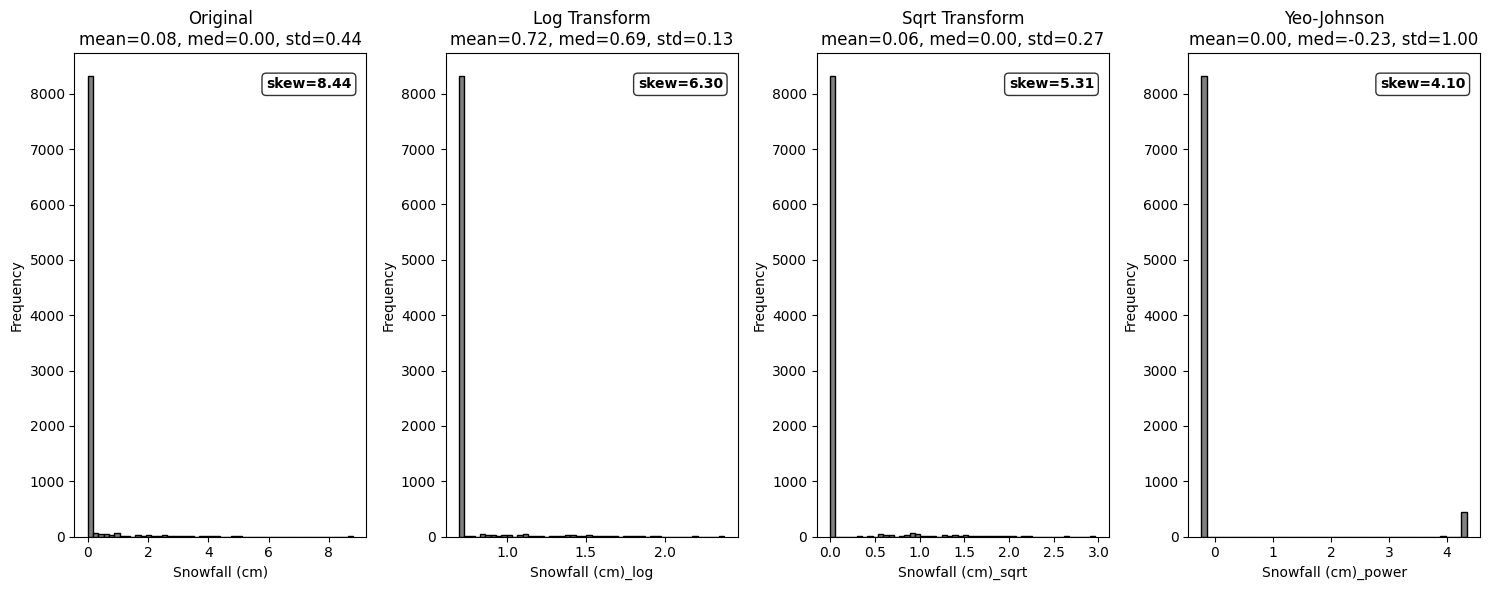

c:\Users\jxbma\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


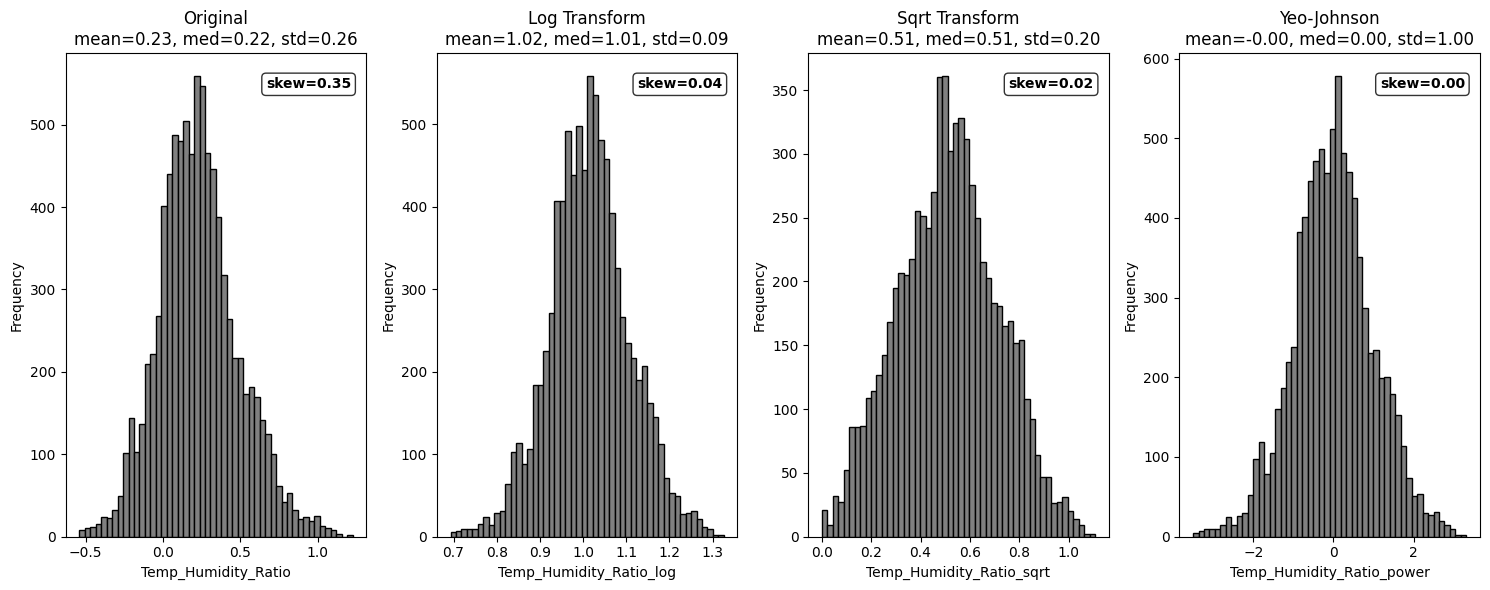

c:\Users\jxbma\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


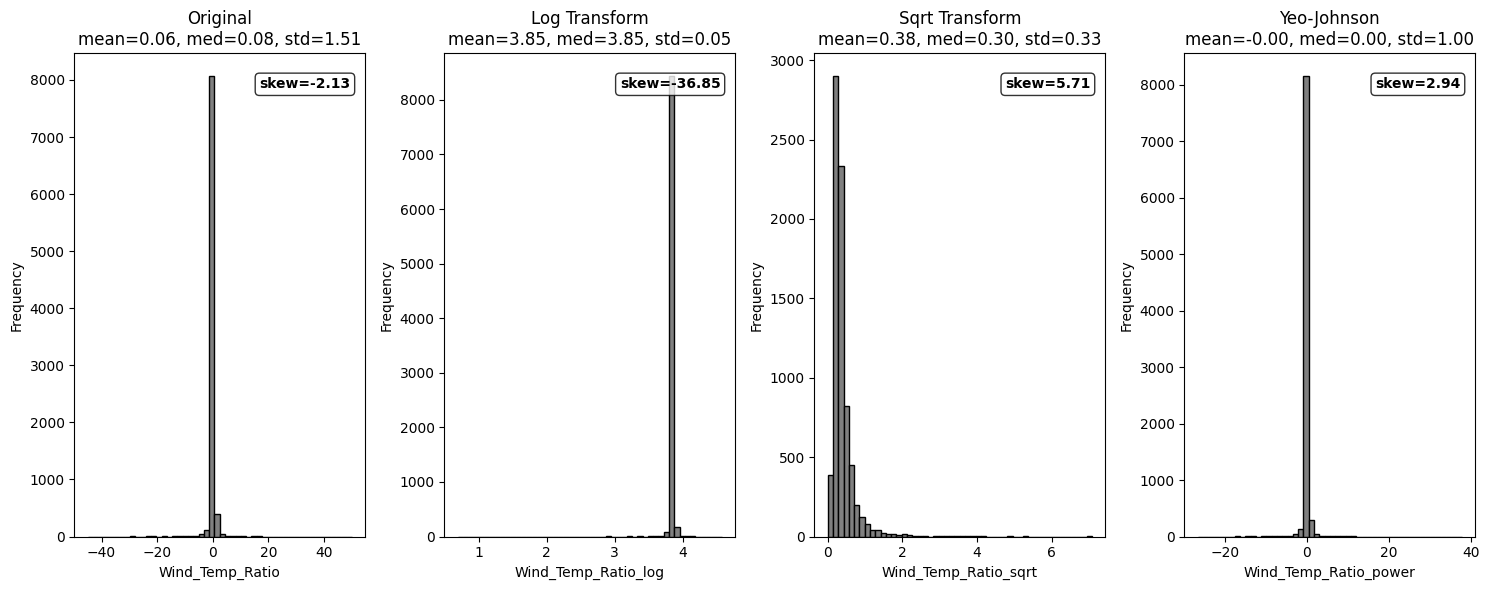

c:\Users\jxbma\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


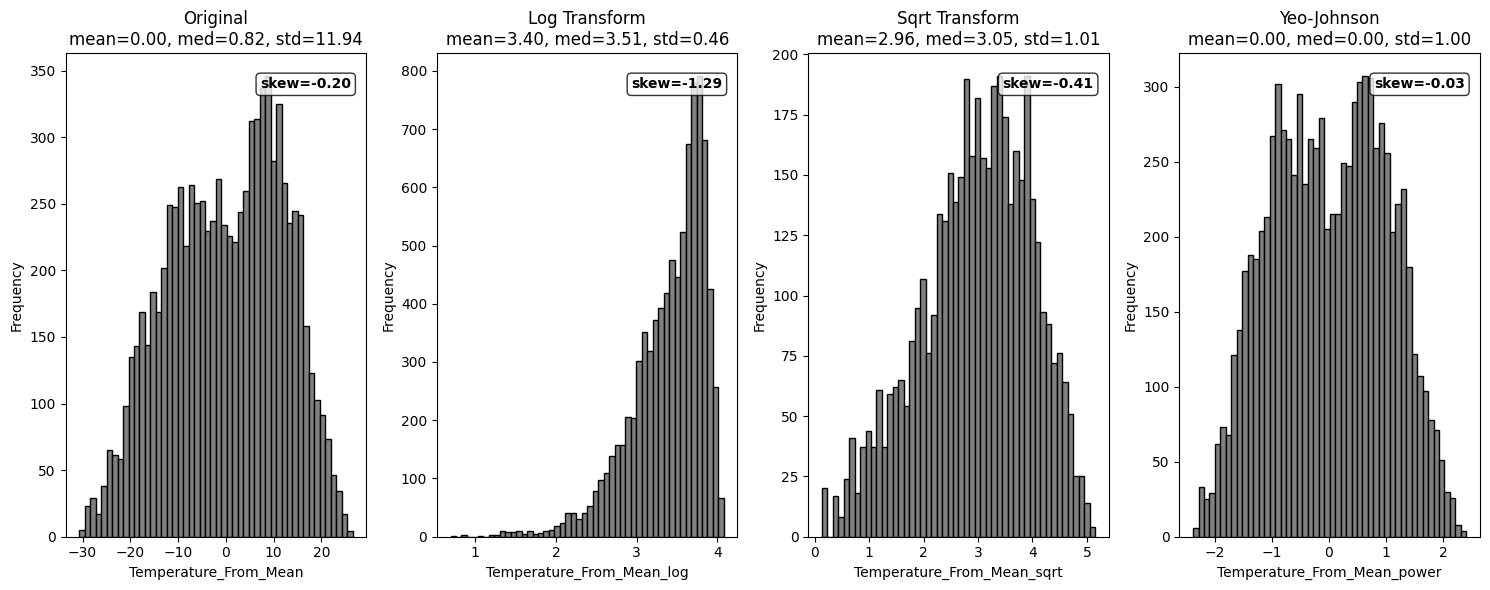

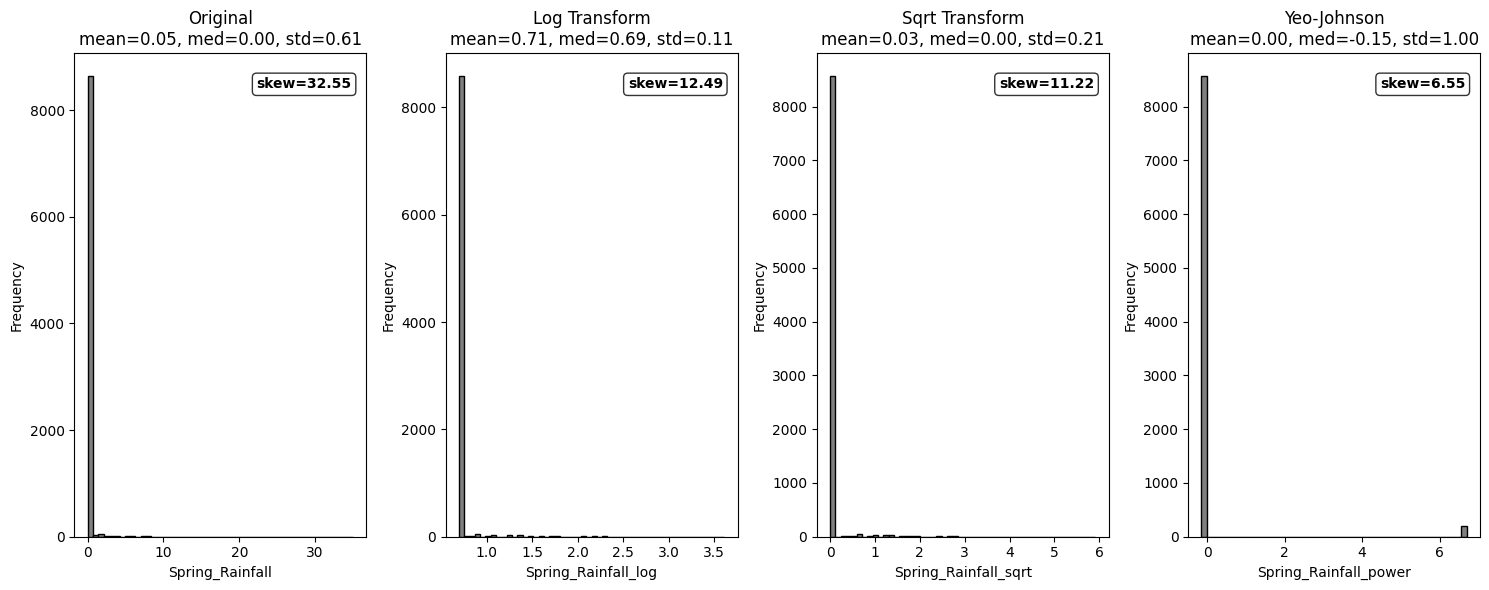

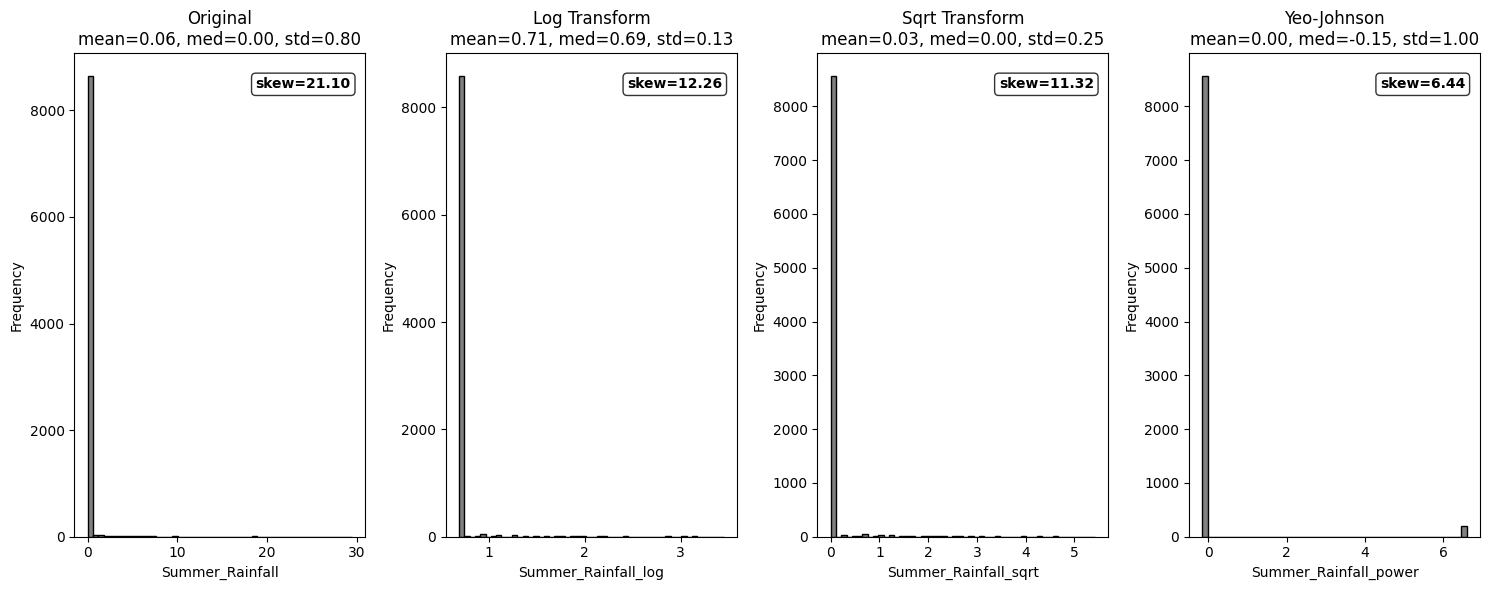

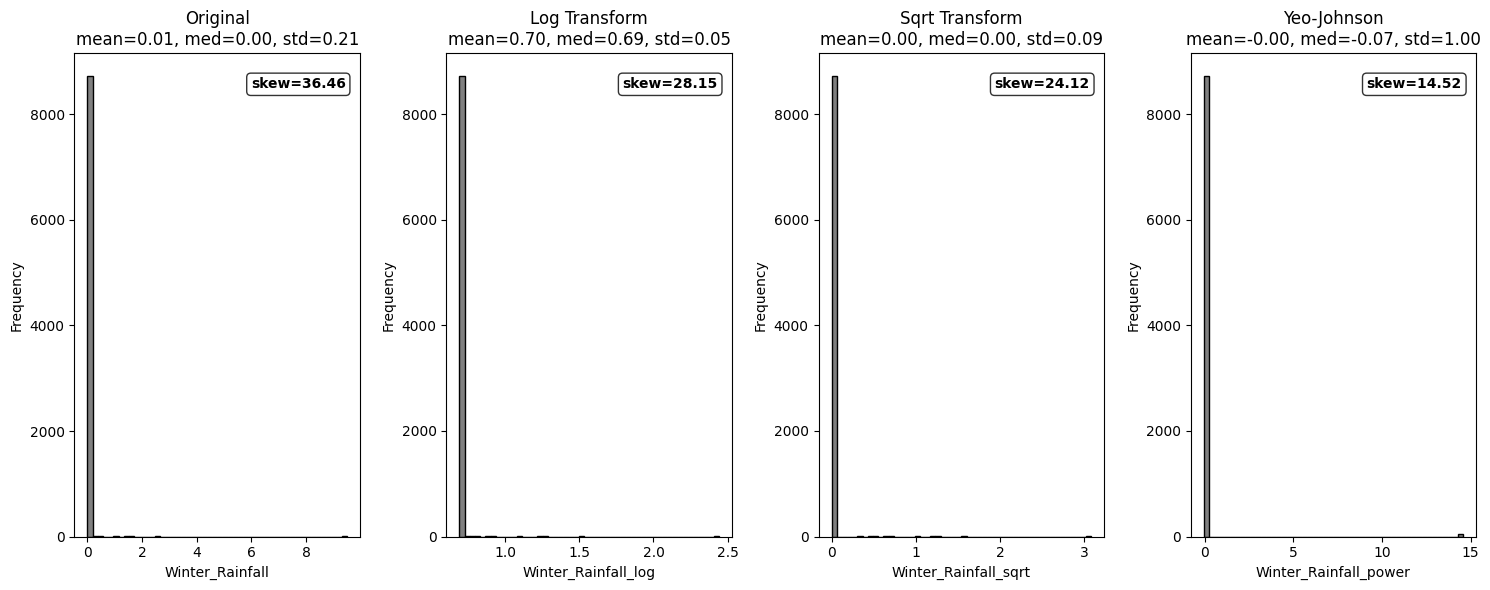

In [13]:
# Normalized/Ratio Features

# Temperature relative to humidity
df_floridabikerentals_new['Temp_Humidity_Ratio'] = df_floridabikerentals_new['Temperature(C)'] / df_floridabikerentals_new['Humidity(%)']

# Wind chill factor (simplified)
df_floridabikerentals_new['Wind_Temp_Ratio'] = df_floridabikerentals_new['Wind speed (m/s)'] / (df_floridabikerentals_new['Temperature(C)'] + 1)

# Difference Features - Temperature from Mean
df_floridabikerentals_new['Temperature_From_Mean'] = df_floridabikerentals_new['Temperature(C)'] - df_floridabikerentals_new['Temperature(C)'].mean()

# Add Free Form Features
# Spring interactions
df_floridabikerentals_new['Spring_Rainfall'] = df_floridabikerentals_new['Seasons_Spring'] * df_floridabikerentals_new['Rainfall(mm)']
df_floridabikerentals_new['Spring_Humidity'] = (df_floridabikerentals_new['Seasons_Spring'] * df_floridabikerentals_new['Humidity(%)']).astype('int16')

# Summer interactions
df_floridabikerentals_new['Summer_Rainfall'] = df_floridabikerentals_new['Seasons_Summer'] * df_floridabikerentals_new['Rainfall(mm)']
df_floridabikerentals_new['Summer_Humidity'] = (df_floridabikerentals_new['Seasons_Summer'] * df_floridabikerentals_new['Humidity(%)']).astype('int16')

# Winter interactions
df_floridabikerentals_new['Winter_Rainfall'] = df_floridabikerentals_new['Seasons_Winter'] * df_floridabikerentals_new['Rainfall(mm)']
df_floridabikerentals_new['Winter_Humidity'] = (df_floridabikerentals_new['Seasons_Winter'] * df_floridabikerentals_new['Humidity(%)']).astype('int16')


# Transformed Features
# Apply to continuous (float64) Featres only
continuous_cols = df_floridabikerentals_new.select_dtypes(include='float64').columns.tolist()

# Make a copy of the DataFrame to test with
df_test = df_floridabikerentals_new.copy(deep=True)

# Apply power transformation using Yeo-Johnson (handles positive and negative values)
transformer = PowerTransformer(method='yeo-johnson')

# Iterate over continuous columns and compare original/transformed feature
for i, col in enumerate(continuous_cols):

    # Apply log transformation (using log1p to handle zeros)
    # Option 2: Shift data to positive before log
    # Error: ValueError: supplied range of [0.6931, inf] is not finite
    # Clean the column first
    df_test[col] = df_test[col].replace([np.inf, -np.inf], np.nan)
    df_test[col] = df_test[col].fillna(df_test[col].median())

    # Now transform
    min_val = df_test[col].min()
    df_test[f'{col}_log'] = np.log1p(df_test[col] - min_val + 1)
    #df_test[f'{col}_log'] = np.log1p(df_test[col])

    # Apply square root transformation
    df_test[f'{col}_sqrt'] = np.sqrt(df_test[col])

    # Fit and transform
    # Error: ValueError: Input X contains infinity or a value too large for dtype('float64').
    # Remove infinit Values
    df_test[col] = df_test[col].replace([np.inf, -np.inf], np.nan)
    df_test[col] = df_test[col].fillna(df_test[col].median())
    df_test[f'{col}_power'] = transformer.fit_transform(df_test[[col]])

    # Visualize
    fig, axes = plt.subplots(1, 4, figsize=(15, 6))

    # Plot Statistics in the Title
    orig_data = df_test[col]
    axes[0].set_title(f'Original\nmean={orig_data.mean():.2f}, med={orig_data.median():.2f}, std={orig_data.std():.2f}')
    axes[0].hist(df_test[col], bins=50, edgecolor='black', color='grey')
    axes[0].set_xlabel(col)
    axes[0].set_ylabel('Frequency')

    # Display skew as label in the plot
    axes[0].text(0.95, 0.95, f'skew={orig_data.skew():.2f}', 
             transform=axes[0].transAxes, 
             ha='right', va='top',
             fontsize=10, fontweight='bold',
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
 
    #print(f'{col}_log')
    log_data = df_test[f'{col}_log']
    axes[1].set_title(f'Log Transform\nmean={log_data.mean():.2f}, med={log_data.median():.2f}, std={log_data.std():.2f}')
    axes[1].hist(df_test[f'{col}_log'], bins=50, edgecolor='black', color='grey')
    axes[1].set_xlabel(f'{col}_log')
    axes[1].set_ylabel('Frequency')

    # Display skew as label in the plot
    axes[1].text(0.95, 0.95, f'skew={log_data.skew():.2f}', 
             transform=axes[1].transAxes, 
             ha='right', va='top',
             fontsize=10, fontweight='bold',
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

    sqrt_data = df_test[f'{col}_sqrt']
    axes[2].set_title(f'Sqrt Transform\nmean={sqrt_data.mean():.2f}, med={sqrt_data.median():.2f}, std={sqrt_data.std():.2f}')
    axes[2].hist(df_test[f'{col}_sqrt'], bins=50, edgecolor='black', color='grey')
    axes[2].set_xlabel(f'{col}_sqrt')
    axes[2].set_ylabel('Frequency')

    # Display skew as label in the plot
    axes[2].text(0.95, 0.95, f'skew={sqrt_data.skew():.2f}', 
             transform=axes[2].transAxes, 
             ha='right', va='top',
             fontsize=10, fontweight='bold',
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))    

    power_data = df_test[f'{col}_power']
    axes[3].set_title(f'Yeo-Johnson\nmean={power_data.mean():.2f}, med={power_data.median():.2f}, std={power_data.std():.2f}')
    axes[3].hist(df_test[f'{col}_power'], bins=50, edgecolor='black', color='grey')
    axes[3].set_xlabel(f'{col}_power')
    axes[3].set_ylabel('Frequency')

    # Display skew as label in the plot
    axes[3].text(0.95, 0.95, f'skew={power_data.skew():.2f}', 
             transform=axes[3].transAxes, 
             ha='right', va='top',
             fontsize=10, fontweight='bold',
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    plt.tight_layout()
    plt.show()


##### <b>Choose Best Transform For Each Feature</b> #####
    Examine the skew for each Feature/Transform combination and determine the best one to use

In [14]:
def get_best_transform(df, col):
    
    results = {}
    
    # Original
    results['original'] = df[col].skew()
    
    # Log (only if all values can be made positive)
    min_val = df[col].min()
    log_data = np.log1p(df[col] - min_val + 1)
    results['log'] = log_data.skew()
    
    # Sqrt (only if all values can be made positive)
    sqrt_data = np.sqrt(df[col] - min_val + 1)
    results['sqrt'] = sqrt_data.skew()
    
    # Yeo-Johnson
    transformer = PowerTransformer(method='yeo-johnson')
    power_data = transformer.fit_transform(df[[col]]).flatten()
    results['yeo-johnson'] = pd.Series(power_data).skew()
    
    # Find best (closest to 0)
    best_transform = min(results, key=lambda k: abs(results[k]))
    
    return best_transform, results

for col in continuous_cols:
    best, all_skews = get_best_transform(df_test, col)
    print(f"{col}:")
    print(f"  Skews: {', '.join([f'{k}={v:.3f}' for k, v in all_skews.items()])}")
    print(f"  Best: {best}")
    print()

Temperature(C):
  Skews: original=-0.198, log=-1.295, sqrt=-0.657, yeo-johnson=-0.234
  Best: original

Wind speed (m/s):
  Skews: original=0.891, log=0.253, sqrt=0.445, yeo-johnson=0.001
  Best: yeo-johnson

Solar Radiation (MJ/m2):
  Skews: original=1.504, log=1.196, sqrt=1.266, yeo-johnson=0.563
  Best: yeo-johnson

Rainfall(mm):
  Skews: original=14.533, log=7.348, sqrt=9.115, yeo-johnson=3.714
  Best: yeo-johnson

Snowfall (cm):
  Skews: original=8.441, log=6.298, sqrt=6.743, yeo-johnson=4.103
  Best: yeo-johnson

Temp_Humidity_Ratio:
  Skews: original=0.346, log=0.038, sqrt=0.104, yeo-johnson=0.002
  Best: yeo-johnson

Wind_Temp_Ratio:
  Skews: original=-2.135, log=-36.850, sqrt=-15.056, yeo-johnson=2.941
  Best: original

Temperature_From_Mean:
  Skews: original=-0.198, log=-1.295, sqrt=-0.657, yeo-johnson=-0.028
  Best: yeo-johnson

Spring_Rainfall:
  Skews: original=32.554, log=12.489, sqrt=16.803, yeo-johnson=6.550
  Best: yeo-johnson

Summer_Rainfall:
  Skews: original=21.09

##### <b>Choose and Apply Best Transform to New DataFrame</b> #####
    Temperature(C): Skews: original=-0.198 ==> Best: original - Do Nothing
    Wind speed (m/s):Skews: yeo-johnson=0.001 ==> Best: yeo-johnson
    Solar Radiation (MJ/m2): Skews: yeo-johnson=0.563 ==> Best: yeo-johnson
    Rainfall(mm): Skews:yeo-johnson=3.714 ==> Best: yeo-johnson
    Snowfall (cm): Skews: yeo-johnson=4.103 ==> Best: yeo-johnson
    Temp_Humidity_Ratio: Skews: yeo-johnson=0.002  ==> Best: yeo-johnson
    Wind_Temp_Ratio:Skews: original=-2.135 ==> Best: original - Do Nothing
    Temperature_From_Mean: Skews: yeo-johnson=-0.028 =+> Best: yeo-johnson

    Attempt made to combine columns - Seasons/Rainfall - Seasons/Humidity
    Skew for these new features are incredibly high. It does not make sense 
    to include them when building the model.

In [15]:
# Drop highly skewed newly created features..
# Spring
df_floridabikerentals_new.info()
df_floridabikerentals_new = df_floridabikerentals_new.drop('Spring_Rainfall', axis=1)
df_floridabikerentals_new = df_floridabikerentals_new.drop('Spring_Humidity', axis=1)

# Summer 
df_floridabikerentals_new = df_floridabikerentals_new.drop('Summer_Rainfall', axis=1)
df_floridabikerentals_new = df_floridabikerentals_new.drop('Summer_Humidity', axis=1)

# Winter 
df_floridabikerentals_new = df_floridabikerentals_new.drop('Winter_Rainfall', axis=1)
df_floridabikerentals_new = df_floridabikerentals_new.drop('Winter_Humidity', axis=1)

#
# Apply Suggested Transforms
#
def ApplyYeoJohnsonTransform(df_target, col):
    # Fit and transform
    # Error: ValueError: Input X contains infinity or a value too large for dtype('float64').
    # Remove infinit Values
    df_target[col] = df_target[col].replace([np.inf, -np.inf], np.nan)
    df_target[col] = df_target[col].fillna(df_target[col].median())
    df_target[f'{col}_power'] = transformer.fit_transform(df_target[[col]])

    # Drop Original column to avoid multicollinearity
    df_target = df_target.drop(col, axis=1)

    return df_target

columns_to_transform = ['Wind speed (m/s)', 'Solar Radiation (MJ/m2)', 'Rainfall(mm)', 
                        'Snowfall (cm)', 'Temp_Humidity_Ratio', 'Temperature_From_Mean']

for col in columns_to_transform:
    df_floridabikerentals_new = ApplyYeoJohnsonTransform(df_floridabikerentals_new, col)
                        

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 28 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Rented Bike Count        8760 non-null   int16  
 1   Hour                     8760 non-null   int8   
 2   Temperature(C)           8760 non-null   float64
 3   Humidity(%)              8760 non-null   int8   
 4   Wind speed (m/s)         8760 non-null   float64
 5   Solar Radiation (MJ/m2)  8760 non-null   float64
 6   Rainfall(mm)             8760 non-null   float64
 7   Snowfall (cm)            8760 non-null   float64
 8   Holiday                  8760 non-null   int8   
 9   Functioning Day          8760 non-null   int8   
 10  Seasons_Spring           8760 non-null   int8   
 11  Seasons_Summer           8760 non-null   int8   
 12  Seasons_Winter           8760 non-null   int8   
 13  Month                    8760 non-null   int8   
 14  DayOfWeek               

##### <b>Apply Scaling to the DataSet</b> #####
Apply scaling to the DataSet using StandardScaler
### ###
    There is some confusion here on my part.
    Examples I found that use StandardScaler do the following:

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=315)

        # Scale AFTER split
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
    
    I'm applying it to then entire data set, which according to what I've read could cause some data leakage.
    This needs to be revisited so I can figure out where it properly fits in the process (including once pipelines are used.)

    !!!! Andrew  .... Thoughts !!!!

In [16]:
#
# Apply Scaling to the Data Set
# Use StandardScaler
# scaler = StandardScaler()

# # Columns to NOT scale (binary/one-hot)
# cols_not_to_scale = ['Holiday', 'Functioning Day', 'Seasons_Spring', 
#                  'Seasons_Summer', 'Seasons_Winter', 'Weekend', 'Year']

# # Correct Data Errors
# # I got the following error when originally trying to scale:
# # ValueError: Input X contains infinity or a value too large for dtype('float64')
# # To fix this:

# # Replace infinities with NaN
# df_floridabikerentals_new = df_floridabikerentals_new.replace([np.inf, -np.inf], np.nan)

# # Fill NaN with median (or drop rows)
# df_floridabikerentals_new = df_floridabikerentals_new.fillna(df_floridabikerentals_new.median())

# # Columns to scale
df_floridabikerentals_scaled = df_floridabikerentals_new.copy(deep=True)

# cols_to_scale = [col for col in df_floridabikerentals_scaled.columns if col not in cols_not_to_scale]
# #print(cols_to_scale)

def ApplyStandardScalar(df_target):

    # Columns to NOT scale (binary/one-hot)
    cols_not_to_scale = ['Holiday', 'Functioning Day', 'Seasons_Spring', 
                    'Seasons_Summer', 'Seasons_Winter', 'Weekend', 'Year']

    # Correct Data Errors
    # I got the following error when originally trying to scale:
    # ValueError: Input X contains infinity or a value too large for dtype('float64')
    # To fix this:

    # Replace infinities with NaN
    df_target = df_target.replace([np.inf, -np.inf], np.nan)

    # Fill NaN with median (or drop rows)
    df_target = df_target.fillna(df_target.median())

    cols_to_scale = [col for col in df_target.columns if col not in cols_not_to_scale]
    #print(cols_to_scale)

    scaler = StandardScaler()

    # df_standard_scaled = pd.DataFrame(
    #     scaler.fit_transform(df_floridabikerentals_new[cols_to_scale]),
    #     columns=[f'{col}_standard' for col in cols_to_scale],
    #     index=df_floridabikerentals_new.index
    # )
    df_target[cols_to_scale] = scaler.fit_transform(df_target[cols_to_scale])

    df_target.head(20)
    df_target.sample(20)

    return df_target

df_floridabikerentals_scaled = ApplyStandardScalar(df_floridabikerentals_scaled)

# Save this for use later when performing Cross-Validation
df_floridabikeRentals_for_validation = df_floridabikerentals_scaled.copy(deep=True)

print()
print('Scaled Successfully')

# Save Feature Engineered/scaled DataFrame to File
df_floridabikerentals_scaled.to_csv('florida_bike_rentals.csv', index=True)
print(f'Scaled DataFrame successfully saved to: "bike_rental_features.csv"')


Scaled Successfully
Scaled DataFrame successfully saved to: "bike_rental_features.csv"


## <u>**3. Model Building**</u> ##
##### <b>Create Regression Models</b> #####
    Create the following Regression Modles:
        - Linear Regression
        - Ridge Regression (L2 Regularization)
        - Lasso Regression (L1 Regularization)
        - Elastic Net Regression

Model: InitialLinearRegression Train R²: 0.559283 Test R²: 0.538564 Train RMSE: 425.218302 Test RMSE: 449.343043 Train MAE: 317.695350 Test MAE: 336.188236
Model: LinearRegression Train R²: 0.577692 Test R²: 0.551370 Train RMSE: 0.645377 Test RMSE: 0.686963 Train MAE: 0.481202 Test MAE: 0.513727
Ridge Regression with Default Parameters
Model: RidgeRegression Train R²: 0.577661 Test R²: 0.551368 Train RMSE: 0.645401 Test RMSE: 0.686964 Train MAE: 0.480731 Test MAE: 0.513202
Lasso Regression with Default Parameters
Model: LassoRegression Train R²: 0.000000 Test R²: -0.003555 Train RMSE: 0.993114 Test RMSE: 1.027448 Train MAE: 0.799926 Test MAE: 0.820407
ElasticNet Regression with Default Parameters
Model: ElasticNet Train R²: 0.065704 Test R²: 0.059935 Train RMSE: 0.959934 Test RMSE: 0.994416 Train MAE: 0.767442 Test MAE: 0.787586


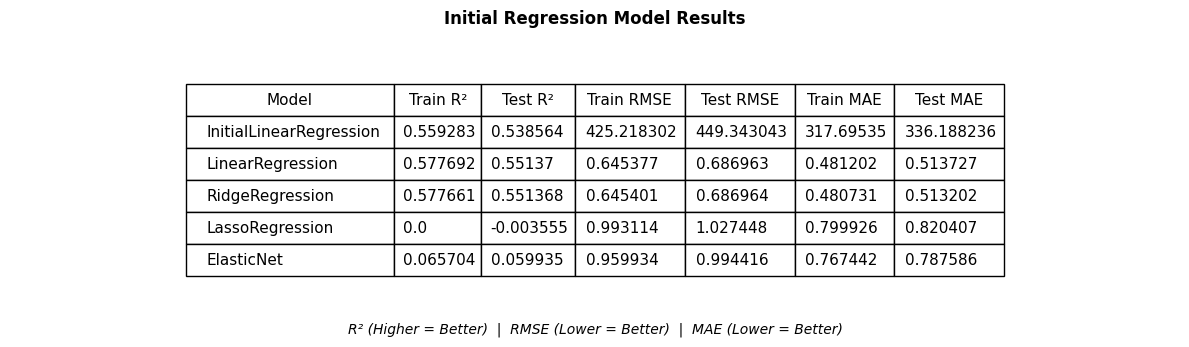

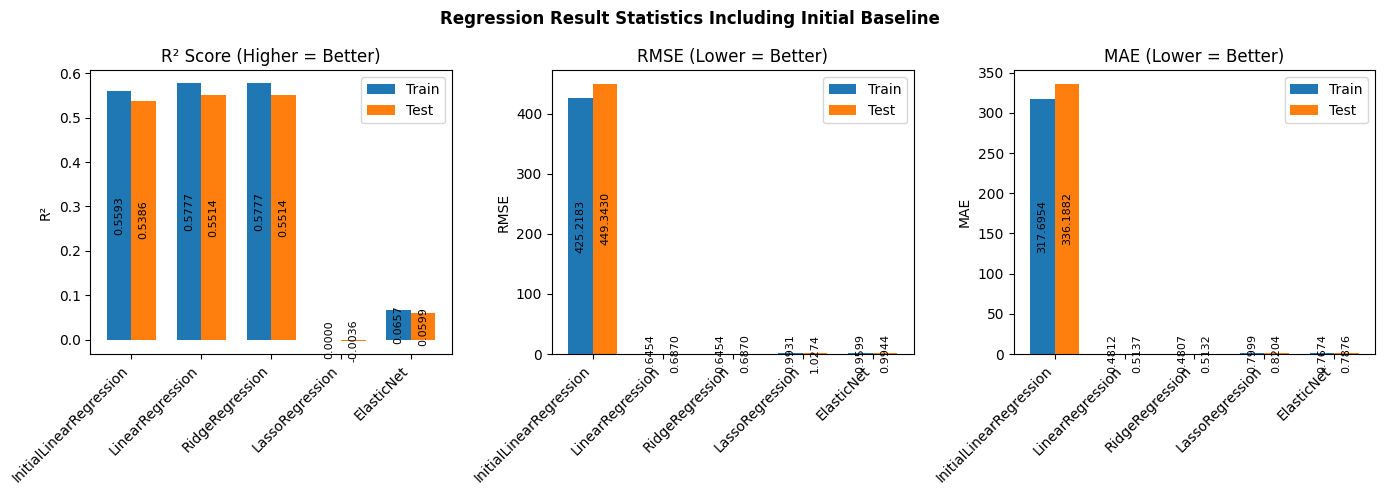

In [17]:
# Split into Train and Test Data


target_label = "Rented Bike Count"
X = df_floridabikerentals_new.drop(target_label, axis=1)  # DataFrame
y = df_floridabikerentals_new[target_label]               # Series

def EvaluateBaselineModel(y_true, y_pred, model_name):
    return {
        'Model': model_name,
        'R²': r2_score(y_true, y_pred),
        'RMSE': root_mean_squared_error(y_true, y_pred),
        'MAE': mean_absolute_error(y_true, y_pred)
    }

# Score Training and Test data for R², RMSE and MAE
def EvaluateModel(y_train, y_train_pred, y_test, y_test_pred, model_name):
    return {
        'Model': model_name,
        'Train R²': r2_score(y_train, y_train_pred),
        'Test R²': r2_score(y_test, y_test_pred),
        'Train RMSE': root_mean_squared_error(y_train, y_train_pred),
        'Test RMSE': root_mean_squared_error(y_test, y_test_pred),
        'Train MAE': mean_absolute_error(y_train, y_train_pred),
        'Test MAE': mean_absolute_error(y_test, y_test_pred)
    }

def PrintModelEvaluationResults(results):
    print(f'Model: {results['Model']} Train R²: {results['Train R²']:.6f} Test R²: {results['Test R²']:.6f} Train RMSE: {results['Train RMSE']:.6f} Test RMSE: {results['Test RMSE']:.6f} Train MAE: {results['Train MAE']:.6f} Test MAE: {results['Test MAE']:.6f}')

def CreateLinearRegression(X_train, X_test, y_train, y_test, model_name='LinearRegression'):

    # Fit linear model on training data
    model = LinearRegression()

    fit_result = model.fit(X_train, y_train)

    y_train_pred = model.predict(X_train)

    # Make predictions
    y_test_pred = model.predict(X_test)

    return EvaluateModel(y_train, y_train_pred, y_test, y_test_pred, model_name)

# def CreateLinearRegressionReturnModel(df_target):

#     # Split Feature Engineered Data into Training/Test => 80/20
#     #df_floridabikerentals_new = df_floridabikerentals_scaled.copy(deep=True)
#     # X = df_floridabikerentals_new.drop(columns=target_label)  # Features
#     # y = df_floridabikerentals_new[target_label]                # Target
#     X = df_target.drop(columns=target_label)  # Features
#     y = df_target[target_label]                # Target
#     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=315)

#     # Fit linear model on training data
#     model = LinearRegression()

#     fit_result = model.fit(X_train, y_train)

#     y_train_pred = model.predict(X_train)

#     # Make predictions
#     y_test_pred = model.predict(X_test)

#     return model

def CreateRidgeRegression(X_train, X_test, y_train, y_test, alpha=1.0, solver='auto'):

    model = Ridge(alpha=alpha, solver=solver)

    fit_result = model.fit(X_train, y_train)

    y_train_pred = model.predict(X_train)

    # Make predictions
    y_test_pred = model.predict(X_test)

    return EvaluateModel(y_train, y_train_pred, y_test, y_test_pred, 'RidgeRegression')

def CreateLassoRegression(X_train, X_test, y_train, y_test, alpha=1.0, max_iter=1000, selection='cyclic', tol=1e-4):

    model = Lasso(alpha=alpha, 
                max_iter=max_iter, 
                selection=selection, 
                tol=tol)

    fit_result = model.fit(X_train, y_train)

    y_train_pred = model.predict(X_train)

    # Make predictions
    y_test_pred = model.predict(X_test)

    return EvaluateModel(y_train, y_train_pred, y_test, y_test_pred, 'LassoRegression')

def CreateElasticNetRegression(X_train, X_test, y_train, y_test, alpha=1.0, l1_ratio=0.5, max_iter=1000, selection='cyclic', tol=1e-4):

    model = ElasticNet(alpha=alpha, 
                    l1_ratio=l1_ratio, 
                    max_iter=max_iter, 
                    selection=selection, 
                    tol=tol)

    fit_result = model.fit(X_train, y_train)

    y_train_pred = model.predict(X_train)

    # Make predictions
    y_test_pred = model.predict(X_test)

    return EvaluateModel(y_train, y_train_pred, y_test, y_test_pred, 'ElasticNet')

def DisplayResultsTableInPlot(table_title, df_target):

    # Dynamically adjust height based on rows
    fig_height = max(3, len(df_target) * 0.5 + 1)
    fig, ax = plt.subplots(figsize=(12, fig_height))
    ax.axis('off')

    plt.suptitle(table_title, fontweight='bold')

    table = ax.table(cellText=df_target.values,
                    colLabels=df_target.columns,
                    loc='center',
                    cellLoc='left'
                    )

    table.auto_set_font_size(False)
    table.set_fontsize(11)
    table.auto_set_column_width(col=list(range(len(df_target.columns))))  # Auto-fit columns
    table.scale(1.2, 2.0)

    # Add metric labels below the table
    ax.text(0.5, -0.05, 'R² (Higher = Better)  |  RMSE (Lower = Better)  |  MAE (Lower = Better)',
            ha='center', va='top', transform=ax.transAxes, fontsize=10, style='italic')

    plt.tight_layout(h_pad=5)
    plt.show()   
    print()
    print()

def PlotRegressionModelResultStatistics(plot_title, df_results, include_tuned_parameters=False, include_polynomial_parameters=False, display_bar_labels=True):
    
    if include_polynomial_parameters:
        # 6 bars: Default + Tuned + Poly
        fig, axes = plt.subplots(1, 3, figsize=(20, 6))

        models = df_results['Model']
        x = range(len(models))
        width = 0.13

        # R² (higher is better)
        bars1 = axes[0].bar([i - 2.5*width for i in x], df_results['Train R²'], width, label='Train Default')
        bars2 = axes[0].bar([i - 1.5*width for i in x], df_results['Test R²'], width, label='Test Default')
        bars3 = axes[0].bar([i - 0.5*width for i in x], df_results['Tuned Train R²'], width, label='Train Tuned')
        bars4 = axes[0].bar([i + 0.5*width for i in x], df_results['Tuned Test R²'], width, label='Test Tuned')
        bars5 = axes[0].bar([i + 1.5*width for i in x], df_results['Poly Train R²'], width, label='Train Poly')
        bars6 = axes[0].bar([i + 2.5*width for i in x], df_results['Poly Test R²'], width, label='Test Poly')

        if display_bar_labels:
            axes[0].bar_label(bars1, fmt='%.3f', label_type='center', fontsize=6, rotation=90)
            axes[0].bar_label(bars2, fmt='%.3f', label_type='center', fontsize=6, rotation=90)
            axes[0].bar_label(bars3, fmt='%.3f', label_type='center', fontsize=6, rotation=90)
            axes[0].bar_label(bars4, fmt='%.3f', label_type='center', fontsize=6, rotation=90)
            axes[0].bar_label(bars5, fmt='%.3f', label_type='center', fontsize=6, rotation=90)
            axes[0].bar_label(bars6, fmt='%.3f', label_type='center', fontsize=6, rotation=90)

        axes[0].set_ylabel('R²')
        axes[0].set_title('R² Score (Higher = Better)')
        axes[0].set_xticks(x)
        axes[0].set_xticklabels(models, rotation=45, ha='right')
        axes[0].legend(fontsize=7)

        # RMSE (lower is better)
        bars1 = axes[1].bar([i - 2.5*width for i in x], df_results['Train RMSE'], width, label='Train Default')
        bars2 = axes[1].bar([i - 1.5*width for i in x], df_results['Test RMSE'], width, label='Test Default')
        bars3 = axes[1].bar([i - 0.5*width for i in x], df_results['Tuned Train RMSE'], width, label='Train Tuned')
        bars4 = axes[1].bar([i + 0.5*width for i in x], df_results['Tuned Test RMSE'], width, label='Test Tuned')
        bars5 = axes[1].bar([i + 1.5*width for i in x], df_results['Poly Train RMSE'], width, label='Train Poly')
        bars6 = axes[1].bar([i + 2.5*width for i in x], df_results['Poly Test RMSE'], width, label='Test Poly')
        
        if display_bar_labels:
            axes[1].bar_label(bars1, fmt='%.3f', label_type='center', fontsize=6, rotation=90)
            axes[1].bar_label(bars2, fmt='%.3f', label_type='center', fontsize=6, rotation=90)
            axes[1].bar_label(bars3, fmt='%.3f', label_type='center', fontsize=6, rotation=90)
            axes[1].bar_label(bars4, fmt='%.3f', label_type='center', fontsize=6, rotation=90)
            axes[1].bar_label(bars5, fmt='%.3f', label_type='center', fontsize=6, rotation=90)
            axes[1].bar_label(bars6, fmt='%.3f', label_type='center', fontsize=6, rotation=90)

        axes[1].set_ylabel('RMSE')
        axes[1].set_title('RMSE (Lower = Better)')
        axes[1].set_xticks(x)
        axes[1].set_xticklabels(models, rotation=45, ha='right')
        axes[1].legend(fontsize=7)

        # MAE (lower is better)
        bars1 = axes[2].bar([i - 2.5*width for i in x], df_results['Train MAE'], width, label='Train Default')
        bars2 = axes[2].bar([i - 1.5*width for i in x], df_results['Test MAE'], width, label='Test Default')
        bars3 = axes[2].bar([i - 0.5*width for i in x], df_results['Tuned Train MAE'], width, label='Train Tuned')
        bars4 = axes[2].bar([i + 0.5*width for i in x], df_results['Tuned Test MAE'], width, label='Test Tuned')
        bars5 = axes[2].bar([i + 1.5*width for i in x], df_results['Poly Train MAE'], width, label='Train Poly')
        bars6 = axes[2].bar([i + 2.5*width for i in x], df_results['Poly Test MAE'], width, label='Test Poly')
    
        if display_bar_labels:
            axes[2].bar_label(bars1, fmt='%.3f', label_type='center', fontsize=6, rotation=90)
            axes[2].bar_label(bars2, fmt='%.3f', label_type='center', fontsize=6, rotation=90)
            axes[2].bar_label(bars3, fmt='%.3f', label_type='center', fontsize=6, rotation=90)
            axes[2].bar_label(bars4, fmt='%.3f', label_type='center', fontsize=6, rotation=90)
            axes[2].bar_label(bars5, fmt='%.3f', label_type='center', fontsize=6, rotation=90)
            axes[2].bar_label(bars6, fmt='%.3f', label_type='center', fontsize=6, rotation=90)
    
        axes[2].set_ylabel('MAE')
        axes[2].set_title('MAE (Lower = Better)')
        axes[2].set_xticks(x)
        axes[2].set_xticklabels(models, rotation=45, ha='right')
        axes[2].legend(fontsize=7)

    elif include_tuned_parameters:
        # 4 bars: Default + Tuned
        fig, axes = plt.subplots(1, 3, figsize=(18, 6))

        models = df_results['Model']
        x = range(len(models))
        width = 0.2

        # R² (higher is better)
        bars1 = axes[0].bar([i - 1.5*width for i in x], df_results['Train R²'], width, label='Train Default')
        bars2 = axes[0].bar([i - 0.5*width for i in x], df_results['Test R²'], width, label='Test Default')
        bars3 = axes[0].bar([i + 0.5*width for i in x], df_results['Tuned Train R²'], width, label='Train Tuned')
        bars4 = axes[0].bar([i + 1.5*width for i in x], df_results['Tuned Test R²'], width, label='Test Tuned')

        if display_bar_labels:
            axes[0].bar_label(bars1, fmt='%.4f', label_type='center', fontsize=7, rotation=90)
            axes[0].bar_label(bars2, fmt='%.4f', label_type='center', fontsize=7, rotation=90)
            axes[0].bar_label(bars3, fmt='%.4f', label_type='center', fontsize=7, rotation=90)
            axes[0].bar_label(bars4, fmt='%.4f', label_type='center', fontsize=7, rotation=90)

        axes[0].set_ylabel('R²')
        axes[0].set_title('R² Score (Higher = Better)')
        axes[0].set_xticks(x)
        axes[0].set_xticklabels(models, rotation=45, ha='right')
        axes[0].legend()

        # RMSE (lower is better)
        bars1 = axes[1].bar([i - 1.5*width for i in x], df_results['Train RMSE'], width, label='Train Default')
        bars2 = axes[1].bar([i - 0.5*width for i in x], df_results['Test RMSE'], width, label='Test Default')
        bars3 = axes[1].bar([i + 0.5*width for i in x], df_results['Tuned Train RMSE'], width, label='Train Tuned')
        bars4 = axes[1].bar([i + 1.5*width for i in x], df_results['Tuned Test RMSE'], width, label='Test Tuned')
        
        if display_bar_labels:
            axes[1].bar_label(bars1, fmt='%.4f', label_type='center', fontsize=7, rotation=90)
            axes[1].bar_label(bars2, fmt='%.4f', label_type='center', fontsize=7, rotation=90)
            axes[1].bar_label(bars3, fmt='%.4f', label_type='center', fontsize=7, rotation=90)
            axes[1].bar_label(bars4, fmt='%.4f', label_type='center', fontsize=7, rotation=90)

        axes[1].set_ylabel('RMSE')
        axes[1].set_title('RMSE (Lower = Better)')
        axes[1].set_xticks(x)
        axes[1].set_xticklabels(models, rotation=45, ha='right')
        axes[1].legend()

        # MAE (lower is better)
        bars1 = axes[2].bar([i - 1.5*width for i in x], df_results['Train MAE'], width, label='Train Default')
        bars2 = axes[2].bar([i - 0.5*width for i in x], df_results['Test MAE'], width, label='Test Default')
        bars3 = axes[2].bar([i + 0.5*width for i in x], df_results['Tuned Train MAE'], width, label='Train Tuned')
        bars4 = axes[2].bar([i + 1.5*width for i in x], df_results['Tuned Test MAE'], width, label='Test Tuned')
    
        if display_bar_labels:
            axes[2].bar_label(bars1, fmt='%.4f', label_type='center', fontsize=7, rotation=90)
            axes[2].bar_label(bars2, fmt='%.4f', label_type='center', fontsize=7, rotation=90)
            axes[2].bar_label(bars3, fmt='%.4f', label_type='center', fontsize=7, rotation=90)
            axes[2].bar_label(bars4, fmt='%.4f', label_type='center', fontsize=7, rotation=90)
    
        axes[2].set_ylabel('MAE')
        axes[2].set_title('MAE (Lower = Better)')
        axes[2].set_xticks(x)
        axes[2].set_xticklabels(models, rotation=45, ha='right')
        axes[2].legend()

    else:
        # Default: 2 bars per model
        fig, axes = plt.subplots(1, 3, figsize=(14, 5))

        models = df_results['Model']
        x = range(len(models))
        width = 0.35

        # R² (higher is better)
        bars1 = axes[0].bar([i - width/2 for i in x], df_results['Train R²'], width, label='Train')
        bars2 = axes[0].bar([i + width/2 for i in x], df_results['Test R²'], width, label='Test')

        if display_bar_labels:
            axes[0].bar_label(bars1, fmt='%.4f', label_type='center', fontsize=8, rotation=90)
            axes[0].bar_label(bars2, fmt='%.4f', label_type='center', fontsize=8, rotation=90)

        axes[0].set_ylabel('R²')
        axes[0].set_title('R² Score (Higher = Better)')
        axes[0].set_xticks(x)
        axes[0].set_xticklabels(models, rotation=45, ha='right')
        axes[0].legend()

        # RMSE (lower is better)
        bars1 = axes[1].bar([i - width/2 for i in x], df_results['Train RMSE'], width, label='Train')
        bars2 = axes[1].bar([i + width/2 for i in x], df_results['Test RMSE'], width, label='Test')

        if display_bar_labels:
            axes[1].bar_label(bars1, fmt='%.4f', label_type='center', fontsize=8, rotation=90)
            axes[1].bar_label(bars2, fmt='%.4f', label_type='center', fontsize=8, rotation=90)

        axes[1].set_ylabel('RMSE')
        axes[1].set_title('RMSE (Lower = Better)')
        axes[1].set_xticks(x)
        axes[1].set_xticklabels(models, rotation=45, ha='right')
        axes[1].legend()

        # MAE (lower is better)
        bars1 = axes[2].bar([i - width/2 for i in x], df_results['Train MAE'], width, label='Train')
        bars2 = axes[2].bar([i + width/2 for i in x], df_results['Test MAE'], width, label='Test')

        if display_bar_labels:
            axes[2].bar_label(bars1, fmt='%.4f', label_type='center', fontsize=8, rotation=90)
            axes[2].bar_label(bars2, fmt='%.4f', label_type='center', fontsize=8, rotation=90)

        axes[2].set_ylabel('MAE')
        axes[2].set_title('MAE (Lower = Better)')
        axes[2].set_xticks(x)
        axes[2].set_xticklabels(models, rotation=45, ha='right')
        axes[2].legend()

    plt.suptitle(plot_title, fontweight='bold')
    plt.tight_layout()
    plt.show()        
    
    print()
    print()

def RunRegressionModels(df_target, best_params=None):

    # Define this here so it has global scope
    global X_train, Xtest, y_train, y_test
    
    results = []

    #
    # Always run Baseline Linear Regression against orignal raw dataset
    #

    # Split Non-Feature Engineered Data into Training/Test => 80/20
    X = df_floridabikerentals_nonengineered.drop(columns=target_label)  # Features
    y = df_floridabikerentals_nonengineered[target_label]               # Target
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=315)

    # Linear Regression Baseline
    initial_linear_results = CreateLinearRegression(X_train, X_test, y_train, y_test, 'InitialLinearRegression')
    PrintModelEvaluationResults(initial_linear_results)
    results.append(initial_linear_results)

    # Split Feature Engineered Data into Training/Test => 80/20
    #df_floridabikerentals_new = df_floridabikerentals_scaled.copy(deep=True)
    # X = df_floridabikerentals_new.drop(columns=target_label)  # Features
    # y = df_floridabikerentals_new[target_label]                # Target
    X = df_target.drop(columns=target_label)  # Features
    y = df_target[target_label]                # Target
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=315)

    # Does this belong here so we don't get data leakage?
    # # Scale features
    # scaler = StandardScaler()
    # X_train_scaled = scaler.fit_transform(X_train)  # Fit on train, transform train
    # X_test_scaled = scaler.transform(X_test)        # Only transform test (no fit!)

    # Linear Regression
    linear_results = CreateLinearRegression(X_train, X_test, y_train, y_test)
    PrintModelEvaluationResults(linear_results)
    results.append(linear_results)

    # Ridge Regression
    ridge_results = None

    if best_params is not None and 'Ridge' in best_params:
        ridge_results = CreateRidgeRegression(X_train, X_test, y_train, y_test, 
                                              best_params['Ridge']['alpha'],
                                              best_params['Ridge']['solver'])
        print(f'Ridge Regression with Best Parameters: {best_params['Ridge']}')
    else:
        ridge_results = CreateRidgeRegression(X_train, X_test, y_train, y_test)
        print('Ridge Regression with Default Parameters')

    PrintModelEvaluationResults(ridge_results)
    results.append(ridge_results)

    # Lasso
    lasso_results = None

    if best_params is not None and 'Lasso' in best_params:
        lasso_results = CreateLassoRegression(X_train, X_test, y_train, y_test, 
                                              best_params['Lasso']['alpha'],
                                              best_params['Lasso']['max_iter'],
                                              best_params['Lasso']['selection'],
                                              best_params['Lasso']['tol'])
        print(f'Lasso Regression with Best Parameters: {best_params['Lasso']}')
    else:
        lasso_results = CreateLassoRegression(X_train, X_test, y_train, y_test)
        print('Lasso Regression with Default Parameters')

    PrintModelEvaluationResults(lasso_results)
    results.append(lasso_results)

    # ElasticNet
    ElasticNet_results = None

    if best_params is not None and 'ElasticNet' in best_params:
        elasticnet_results = CreateElasticNetRegression(X_train, X_test, y_train, y_test, 
                                              best_params['ElasticNet']['alpha'],
                                              best_params['ElasticNet']['l1_ratio'],
                                              best_params['ElasticNet']['max_iter'],
                                              best_params['ElasticNet']['selection'],
                                              best_params['ElasticNet']['tol'])
        print(f'ElasticNet Regression with Best Parameters: {best_params['ElasticNet']}')        
    else:
        elasticnet_results = CreateElasticNetRegression(X_train, X_test, y_train, y_test)        
        print('ElasticNet Regression with Default Parameters')

    PrintModelEvaluationResults(elasticnet_results)
    results.append(elasticnet_results)

    # Create DataFrame and round
    df_results = pd.DataFrame(results)
    df_results = df_results.round(6)

    DisplayResultsTableInPlot('Initial Regression Model Results', df_results)
    PlotRegressionModelResultStatistics('Regression Result Statistics Including Initial Baseline', df_results)

    return df_results


df_untuned_regression_results = RunRegressionModels(df_floridabikerentals_scaled)


##### <b>Initial Run of Model Comparison Plots For Regression Models</b> #####
    Initial Linear Regression Baseline skews the plot results so Linear, Ridge, Lasso and ElasticNet don't show useful information.
    Replot without initial baseline to get a clearer view of the plots against Feature Engineered data.

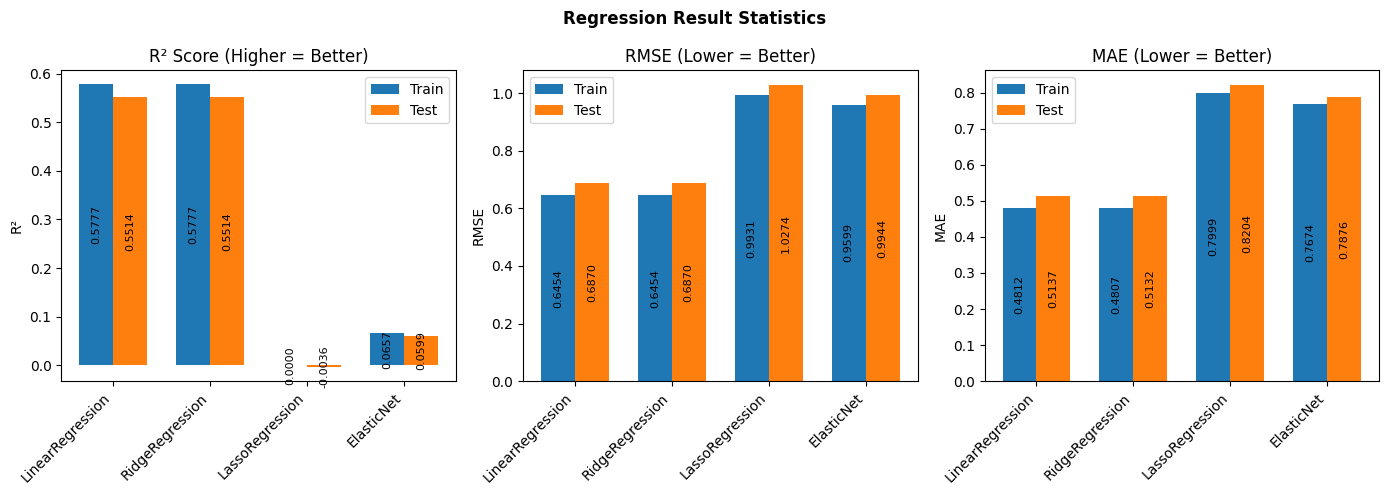

In [18]:
PlotRegressionModelResultStatistics('Regression Result Statistics', 
                                    df_untuned_regression_results[df_untuned_regression_results['Model'] != 'InitialLinearRegression'])

##### <b>Analysis of Initial runs of Linear, Ridge, Lasso Regressions and ElasticNet</b> #####
    Analysis is based on the following statistics criteria from the model Train and Test Predictions:
    R² (Higher = Better)  |  RMSE (Lower = Better)  |  MAE (Lower = Better)

    All regression models scored better that initial baseline for RMSE and MAE. 
    R² was relatively equal between baseline and regression models, with regression models performing just slightly better.

    Linear and Ridge Regression scored almost identically across Error Metrics.
    Lasso Regression and ElasticNet scored similarly for RMSE and MAE.
    Based on the plots and data table, Linear and Ridge Regression are the clear winners.
    R² was highest score wise, while RMSE and MAE had lowest scores.

    The next step is to apply Hyperparameter tuning to the models and compare what their optimum performnace looks like.

#### <b>Hyperparameter Tuning</b> ####
##### <b>Find Best Tuned Hyperparameters</b> #####

In [19]:
# Linear Regression
# No parameters to tune

# Ridge Regression
param_grid_ridge = {
    'alpha': [0.01, 0.1, 1, 10, 100],
    'solver': ['auto', 'svd', 'cholesky', 'lsqr', 'saga']
}

grid_search_ridge = GridSearchCV(Ridge(), param_grid_ridge, cv=5, scoring='r2')
grid_search_ridge.fit(X_train, y_train)

# Lasso Regression
# Increase max_iter from 1000 to 10000 to try to resolve ConvergenceWarnings
param_grid_lasso = {
    'alpha': [0.001, 0.01, 0.1, 1, 10],
    'max_iter': [1000, 5000, 10000],
    'tol': [1e-4, 1e-5],
    'selection': ['cyclic', 'random']
}

grid_search_lasso = GridSearchCV(Lasso(), 
                                 param_grid_lasso, cv=5, scoring='r2')
grid_search_lasso.fit(X_train, y_train)

# ElasticNet
param_grid_elastic = {
    'alpha': [0.001, 0.01, 0.1, 1, 10],
    'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9],
    'max_iter': [1000, 5000, 10000],
    'tol': [1e-4, 1e-5],
    'selection': ['cyclic', 'random']
}

# Increase max_iter from 1000 to 10000 to try to resolve ConvergenceWarnings
grid_search_elasticnet = GridSearchCV(ElasticNet(max_iter=10000), 
                                      param_grid_elastic, cv=5, scoring='r2')
grid_search_elasticnet.fit(X_train, y_train)

print('Completed Hyperparameter Tuning')
print(f'Ridge() Best Params:{grid_search_ridge.best_params_}')
print(f'Lasso() Best Params:{grid_search_lasso.best_params_}')
print(f'ElasticNet() Best Params:{grid_search_elasticnet.best_params_}')
print()

c:\Users\jxbma\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\jxbma\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\jxbma\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\jxbma\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\jxbma\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the 

Completed Hyperparameter Tuning
Ridge() Best Params:{'alpha': 0.01, 'solver': 'saga'}
Lasso() Best Params:{'alpha': 0.001, 'max_iter': 1000, 'selection': 'random', 'tol': 0.0001}
ElasticNet() Best Params:{'alpha': 0.001, 'l1_ratio': 0.1, 'max_iter': 1000, 'selection': 'cyclic', 'tol': 0.0001}



c:\Users\jxbma\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.950e+00, tolerance: 6.912e-01
  model = cd_fast.enet_coordinate_descent(


##### <b>Run Regression Models with Best Tuned Hyperparameters</b> #####
    After running GridSearchCV() for hyperparameter tuning, it was determined that these were the best parameter settings:
        - Ridge() Best Params:{'alpha': 0.01, 'solver': 'saga'}
        - Lasso() Best Params:{'alpha': 0.001, 'max_iter': 5000, 'selection': 'random', 'tol': 0.0001}
        - ElasticNet() Best Params:{'alpha': 0.001, 'l1_ratio': 0.1, 'max_iter': 1000, 'selection': 'cyclic', 'tol': 0.0001}
    The next step is to rerun the regression models with the tuned parameters and examine the results.

Model: InitialLinearRegression Train R²: 0.559283 Test R²: 0.538564 Train RMSE: 425.218302 Test RMSE: 449.343043 Train MAE: 317.695350 Test MAE: 336.188236
Model: LinearRegression Train R²: 0.577692 Test R²: 0.551370 Train RMSE: 0.645377 Test RMSE: 0.686963 Train MAE: 0.481202 Test MAE: 0.513727
Ridge Regression with Best Parameters: {'alpha': 0.01, 'solver': 'saga'}
Model: RidgeRegression Train R²: 0.577687 Test R²: 0.551297 Train RMSE: 0.645381 Test RMSE: 0.687019 Train MAE: 0.481015 Test MAE: 0.513541
Lasso Regression with Best Parameters: {'alpha': 0.001, 'max_iter': 1000, 'selection': 'random', 'tol': 0.0001}
Model: LassoRegression Train R²: 0.575419 Test R²: 0.550408 Train RMSE: 0.647111 Test RMSE: 0.687699 Train MAE: 0.479577 Test MAE: 0.511003
ElasticNet Regression with Best Parameters: {'alpha': 0.001, 'l1_ratio': 0.1, 'max_iter': 1000, 'selection': 'cyclic', 'tol': 0.0001}
Model: ElasticNet Train R²: 0.576940 Test R²: 0.551018 Train RMSE: 0.645952 Test RMSE: 0.687233 Train MA

c:\Users\jxbma\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.950e+00, tolerance: 6.912e-01
  model = cd_fast.enet_coordinate_descent(


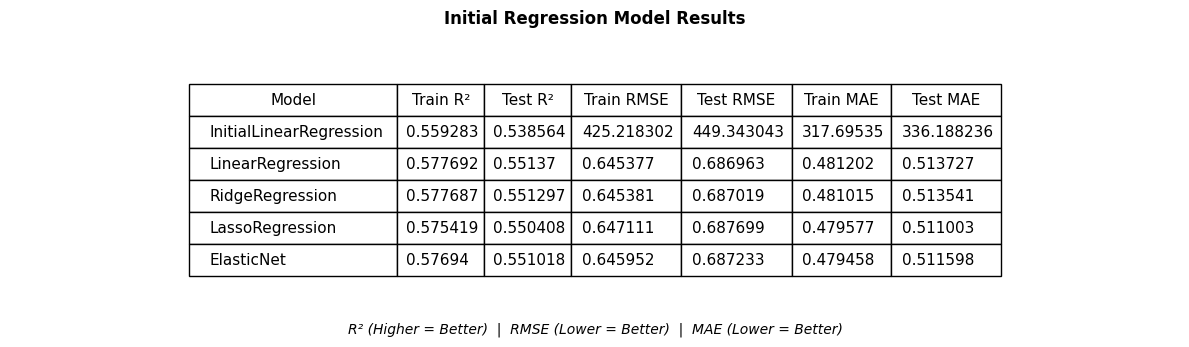

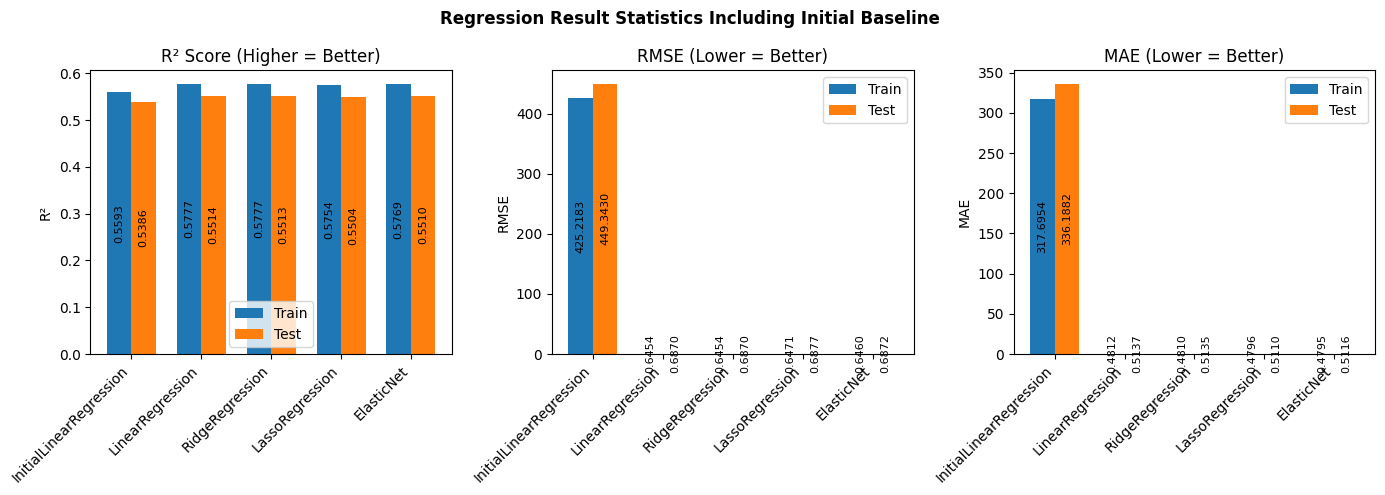



Completed Tuned Hyperparameter Regression Run



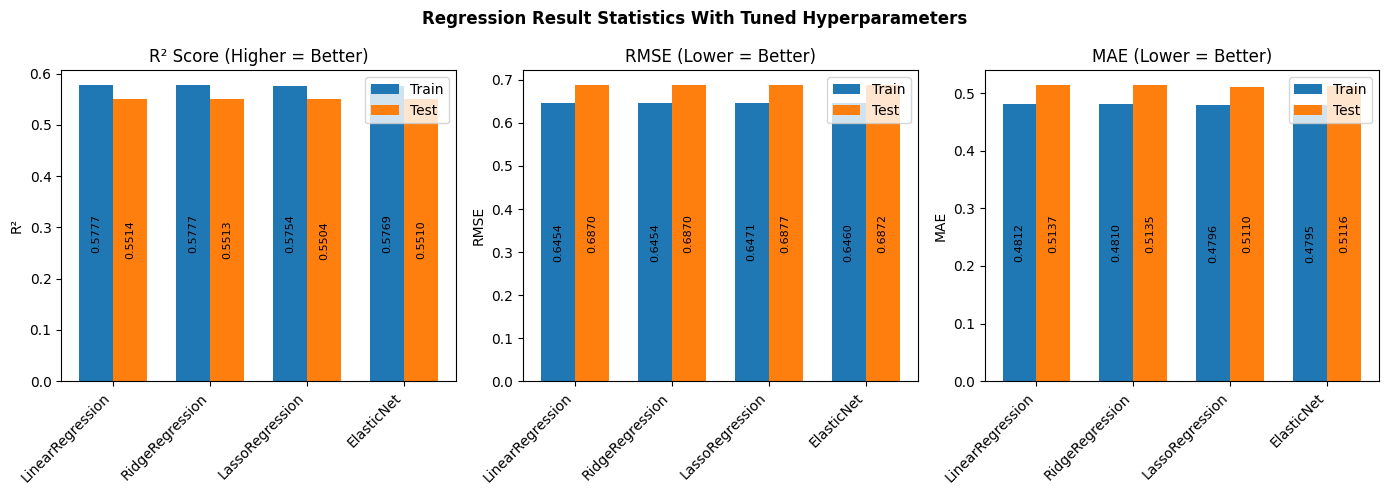





Compare the results for Tuned/Untuned runs


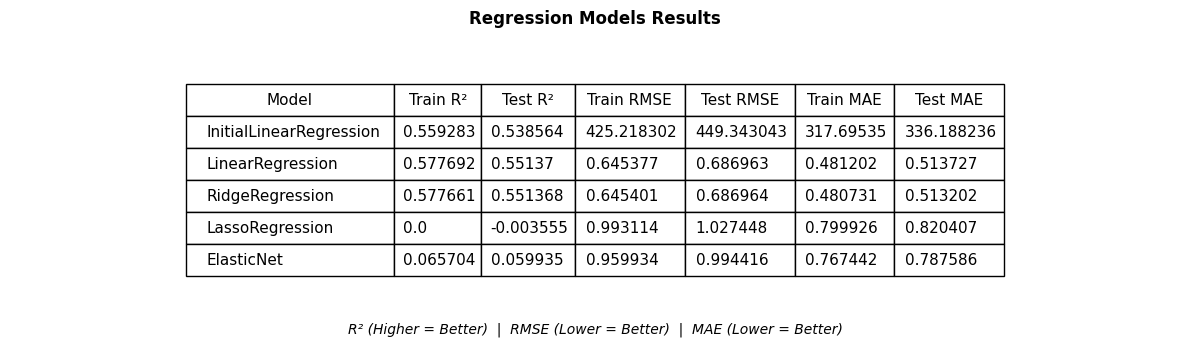

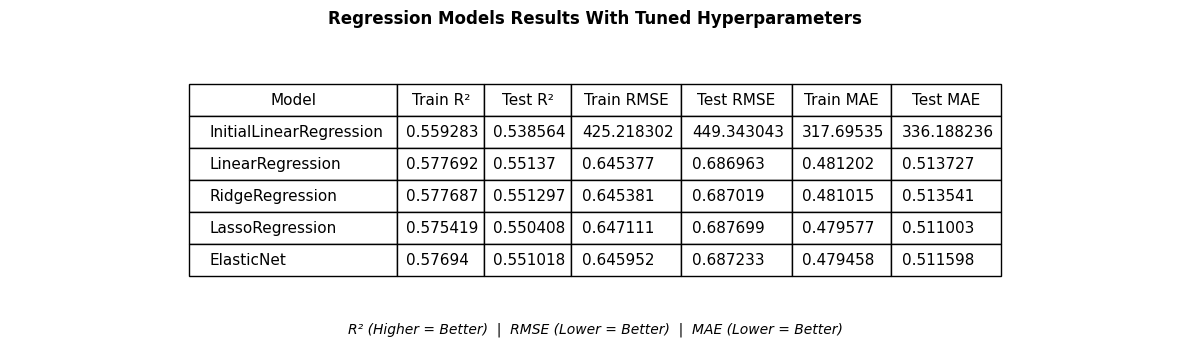

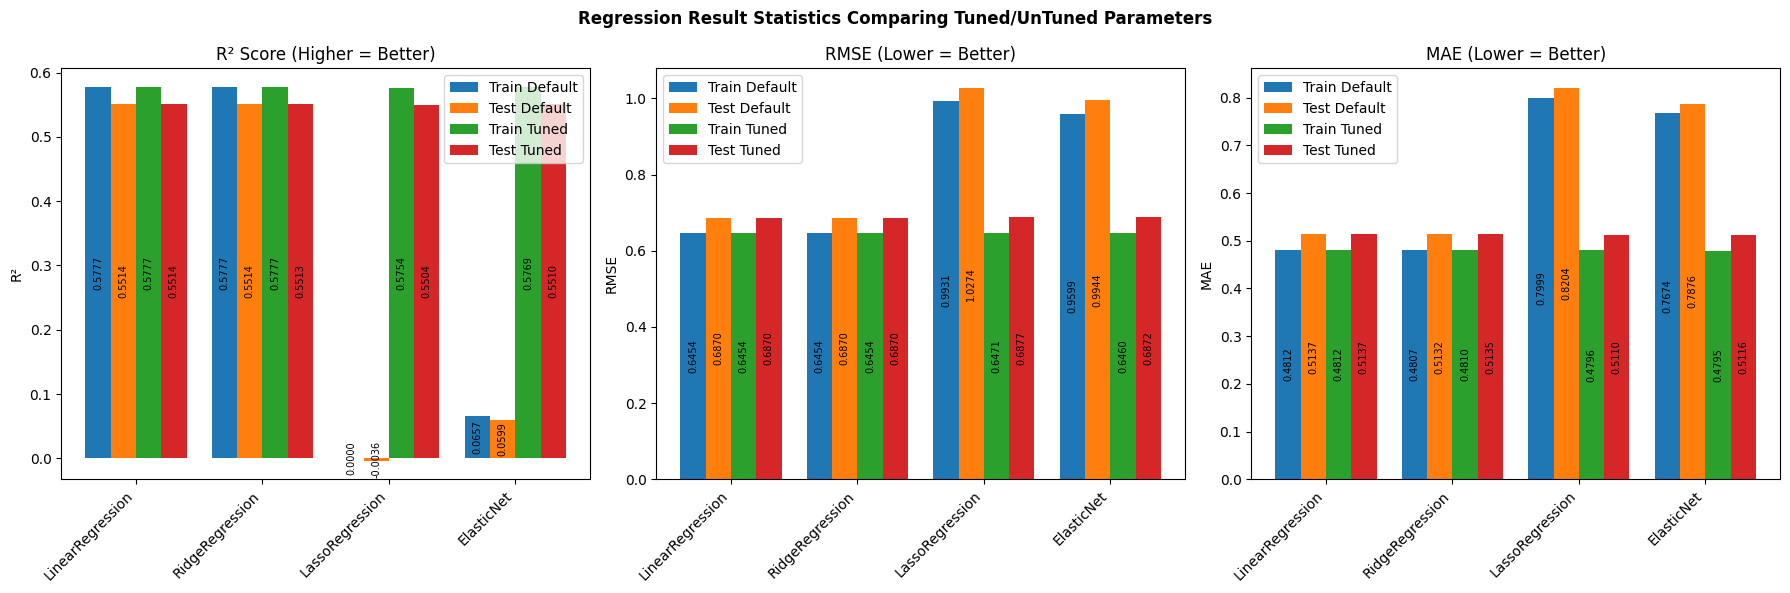

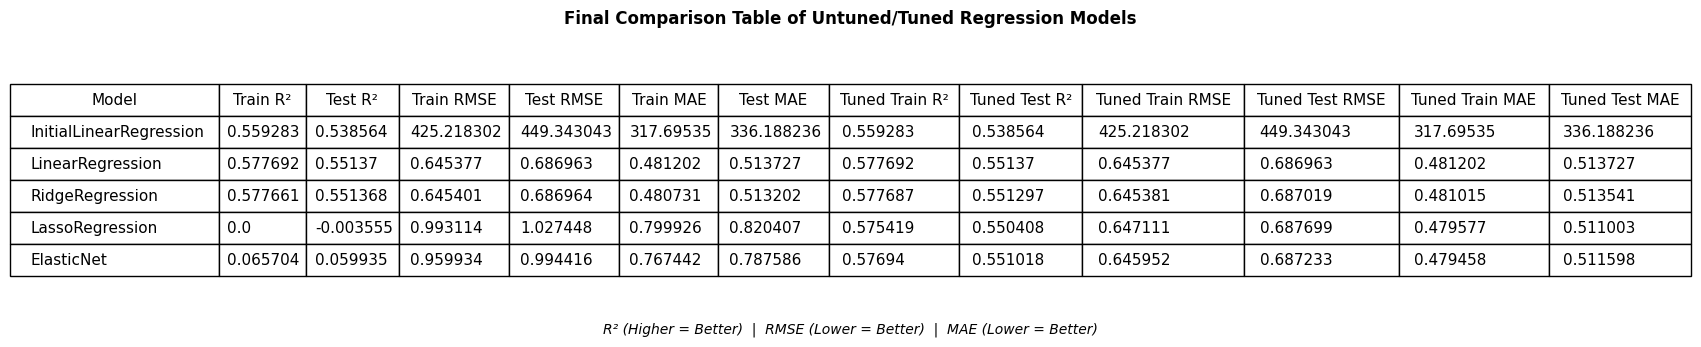

In [20]:
# Run Regression with best tuned Hyperparameters
best_params={}
best_params['Ridge'] = grid_search_ridge.best_params_
best_params['Lasso'] = grid_search_lasso.best_params_
best_params['ElasticNet'] = grid_search_elasticnet.best_params_

df_tuned_regression_results = RunRegressionModels(df_floridabikerentals_scaled, best_params)
print('Completed Tuned Hyperparameter Regression Run')
print()

PlotRegressionModelResultStatistics('Regression Result Statistics With Tuned Hyperparameters', 
                                    df_tuned_regression_results[df_tuned_regression_results['Model'] != 'InitialLinearRegression'])

print()
print()
print('Compare the results for Tuned/Untuned runs')
DisplayResultsTableInPlot('Regression Models Results', df_untuned_regression_results)
DisplayResultsTableInPlot('Regression Models Results With Tuned Hyperparameters', df_tuned_regression_results)
print()


df_comparison_results = df_untuned_regression_results.copy(deep=True)

# Make copy of tuned results and rename columns to have 'Tuned' prefix for plotting
df_tuned_renamed = df_tuned_regression_results.copy()
cols_to_rename = {col: f'Tuned {col}' for col in df_tuned_renamed.columns if col != 'Model'}
df_tuned_renamed.rename(columns=cols_to_rename, inplace=True)

# Merge UnTuned/Tuned results
df_comparison_results = df_untuned_regression_results.merge(df_tuned_renamed, on='Model')

# Plot for comparison
PlotRegressionModelResultStatistics('Regression Result Statistics Comparing Tuned/UnTuned Parameters', 
                                    df_comparison_results[df_comparison_results['Model'] != 'InitialLinearRegression'],
                                    include_tuned_parameters=True)

DisplayResultsTableInPlot('Final Comparison Table of Untuned/Tuned Regression Models', df_comparison_results)

##### <b>Final Observations and Analysis of Linear, Ridge, Lasso Regression and ElasticNet Models</b> #####
    
    **Caveat:: All analysis is based on Feature Engineering completed earlier in the notebook.
    There could very will be wrong/incorrect Feature strategies/methods/creations which would skew/make results unexpected.
    In a real world, the process would be an iterative one, but given the time restraints that was not the method employed.
    Additionally, there are (most probably) defects in the code which might have a negative effect on results.

    Analysis is based on the following statistics criteria from the model Train and Test Predictions:
    R² (Higher = Better)  |  RMSE (Lower = Better)  |  MAE (Lower = Better)

    All regression models scored better that initial baseline for RMSE and MAE. 
    For final comparison/analysis sake, the initial baseline linear regression was removed from the plots.

    Linear and Ridge Regression (both with tuned/untuned parameters) produced identical results.
    After further some further investigation, this is not an unusual situation.
    I don't fully understand it, but given the current data set, Ridge does not need regularization so it converges
    to a Linear Regression (from Claude Search).
    Since Ridge tends toward Linear Regression, hyperparameter tuning had little or no effect on the results.

    Hyperparameter Tuning (HPT) - had the largest effect on R² scores for Lasso Regression and ElasticNet with
    remarkable increases in scores. HPT also showed strong improvements in RMSE and MAE scores for Lasso and ElasticNet,
    though not as dramatic as R².
    
    There appears to be no major overfitting taking place.

    Once HPT was applied, score results for Ridge, Lasso, ElasticNet and Linear Regression were much more aligned in value,
    so they were in similar value ranges. The tuned models converged in score values and strongly mirror each other in the plots.
    Given the current dataset and the noted performance similarities, Linear Regression might be the model.

    Once again, I refer to my previously mentioned **Caveat. I also might have made some errors in observations/interpretations.

    


## <u>**4. Model Building with Polynomial Features**</u> ##
##### <b>Complete the following tasks:</b> #####
        - Create polynomial features for selected numerical columns
        - Train models with polynomial features to capture non-linear relationships
        - Compare results with linear models to assess improvements
        - Save the best-performing model

Number of Numeric Columns: 9
Index(['Rented Bike Count', 'Hour', 'Temperature(C)', 'Humidity(%)', 'Wind speed (m/s)', 'Visibility (10m)', 'Dew point temperature(C)', 'Solar Radiation (MJ/m2)', 'Rainfall(mm)', 'Snowfall (cm)'], dtype='object')
Number of Polynomial Features created:(8760, 219)
feature_corr type: <class 'pandas.core.frame.DataFrame'>
Model: InitialLinearRegression Train R²: 0.559283 Test R²: 0.538564 Train RMSE: 425.218302 Test RMSE: 449.343043 Train MAE: 317.695350 Test MAE: 336.188236
Model: LinearRegression Train R²: 0.776386 Test R²: 0.758210 Train RMSE: 0.469622 Test RMSE: 0.504323 Train MAE: 0.337416 Test MAE: 0.361684
Ridge Regression with Default Parameters
Model: RidgeRegression Train R²: 0.766367 Test R²: 0.747869 Train RMSE: 0.480027 Test RMSE: 0.514994 Train MAE: 0.341413 Test MAE: 0.365538
Lasso Regression with Default Parameters
Model: LassoRegression Train R²: 0.000000 Test R²: -0.003555 Train RMSE: 0.993114 Test RMSE: 1.027448 Train MAE: 0.799926 Test MAE:

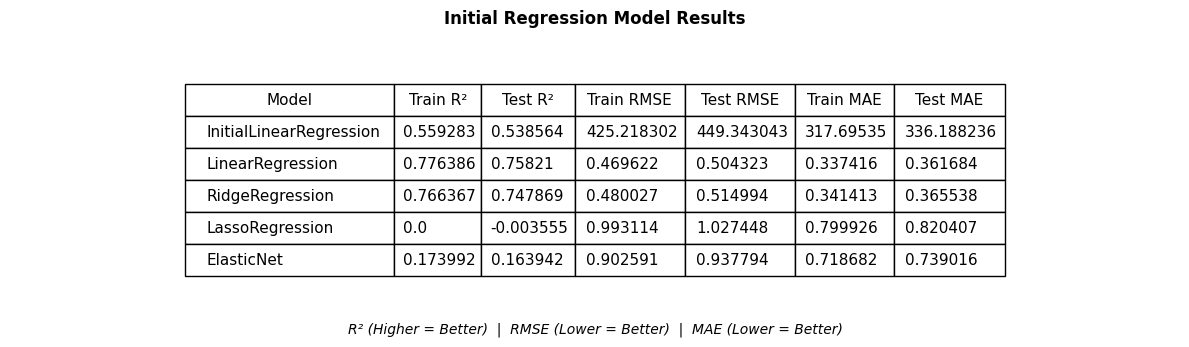

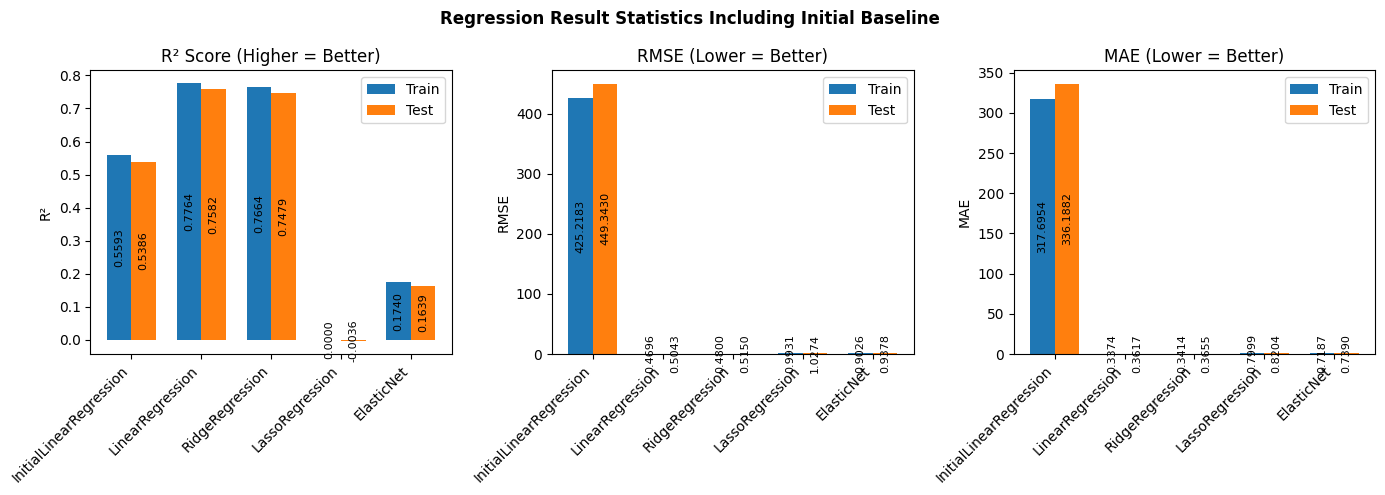

In [21]:
# Import data into DataFrame
# Renamed CSV file is assumed to live in same folder as my notebook
df_floridabikerentals = pd.read_csv("FloridaBikeRentals.csv")

# Print df Column Info
#PrintDataFrameStatus(df_floridabikerental)

# Get numeric columns
# Figure out the numeric columns
numeric_cols = df_floridabikerentals.select_dtypes(include=['number']).columns

cols_to_combine = df_floridabikerentals.select_dtypes(include=['number']).drop(target_label, axis=1).columns
number_of_numeric_cols = len(cols_to_combine)

print(f'Number of Numeric Columns: {number_of_numeric_cols}')
print(numeric_cols)

# Create polynomial features - 3 degrees
poly3 = PolynomialFeatures(degree=3, interaction_only=False, include_bias=False)
poly_features = poly3.fit_transform(df_floridabikerentals[cols_to_combine])
print(f'Number of Polynomial Features created:{poly_features.shape}')

#  Convert to DataFrame
df_floridabikerentals_poly = pd.DataFrame(
                                            poly_features,
                                            columns=poly3.get_feature_names_out(cols_to_combine),
                                            index=df_floridabikerentals.index
                                        )

# Filter by correlation threshold with target
threshold = 0.1
correlations = df_floridabikerentals_poly.corrwith(df_floridabikerentals[target_label]).abs() 

# print(f'Number of Correlated Features: {len(correlations)}')
# print(f'correlations type: {type(correlations)}')
#print(f'Correlated Features{correlations}')
good_features = correlations[correlations > threshold].index.tolist()
# print(f'good_features type: {type(good_features)}')
# print(f'Number of Correlated Features: {len(good_features)}')
#print(f'Good Correlated Features{good_features}')

feature_corr = pd.DataFrame({
                                'feature': good_features,
                                'correlation': [correlations[f] for f in good_features]
                            }).sort_values('correlation', ascending=False)
print(f'feature_corr type: {type(feature_corr)}')

# print(f"Features above threshold ({threshold}): {len(good_features)}")
# print("Sorted by correlation:")
# print(feature_corr.to_string(index=False))

# Make sure to remove remove original (degree 1) features before concatenation
original_cols = cols_to_combine.tolist()
good_features = [f for f in good_features if f not in original_cols]

# Add best features
df_floridabikerentals_final = pd.concat([df_floridabikerentals, df_floridabikerentals_poly[good_features]], axis=1)

# Encode Categoric Features
df_floridabikerentals_final = EncodeCategoricalFeatures(df_floridabikerentals_final)

# Display latest stats with new features
#PrintDataFrameStatus(df_floridabikerentals_final)

# Applying Scaling here so we can get comparable results
df_floridabikerentals_final = ApplyStandardScalar(df_floridabikerentals_final)

# Run Regression Models
df_poly_regression_results = RunRegressionModels(df_floridabikerentals_final)

### Replot Without Initial Linear Regression Baseline ###
    Baseline was note scaled, so replot without baseline for clearer comparisons

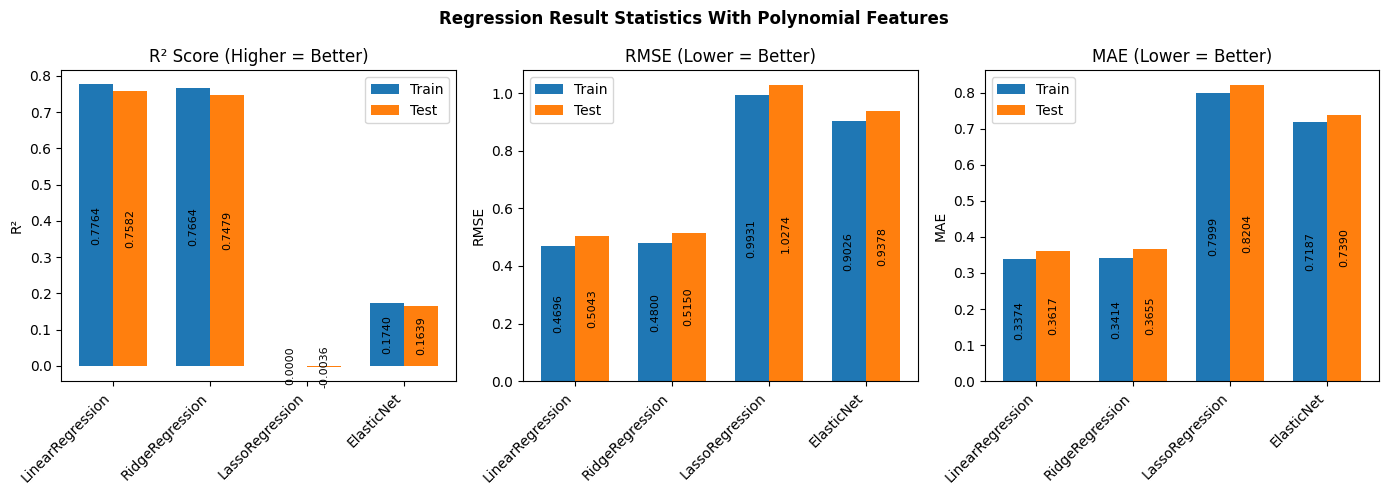

In [22]:
PlotRegressionModelResultStatistics('Regression Result Statistics With Polynomial Features', 
                                    df_poly_regression_results[df_poly_regression_results['Model'] != 'InitialLinearRegression'])

###  **Display Final Comparison** ###
    Display comparison of Linear, Ridge, Lasso, ElasticNet models with Tuned, Untuned and Polynomial Features

    Analysis is based on the following statistics criteria from the model Train and Test Predictions:
    R² (Higher = Better)  |  RMSE (Lower = Better)  |  MAE (Lower = Better)

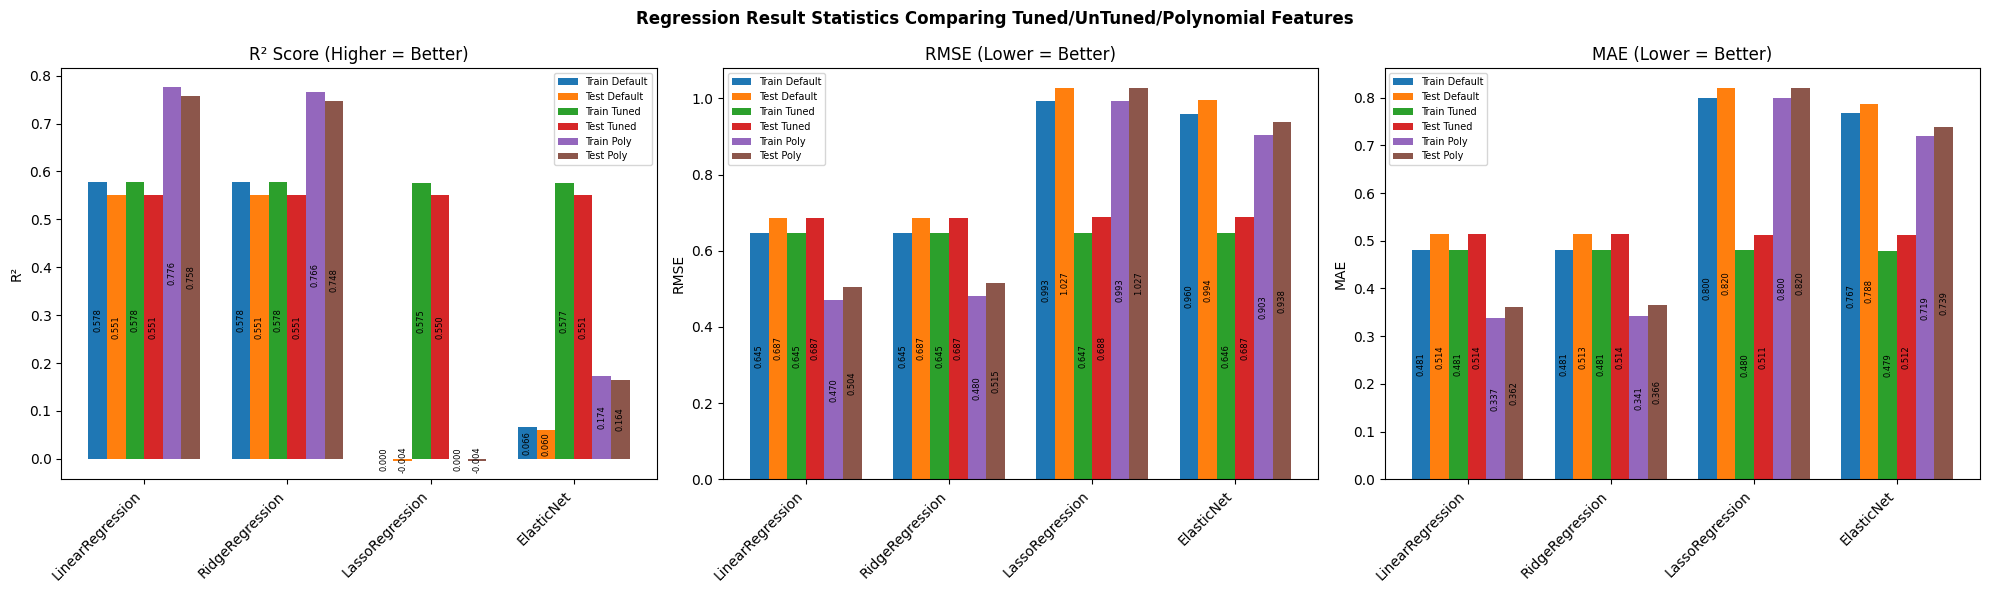

C:\Users\jxbma\AppData\Local\Temp\ipykernel_51536\1759803462.py:137: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout(h_pad=5)


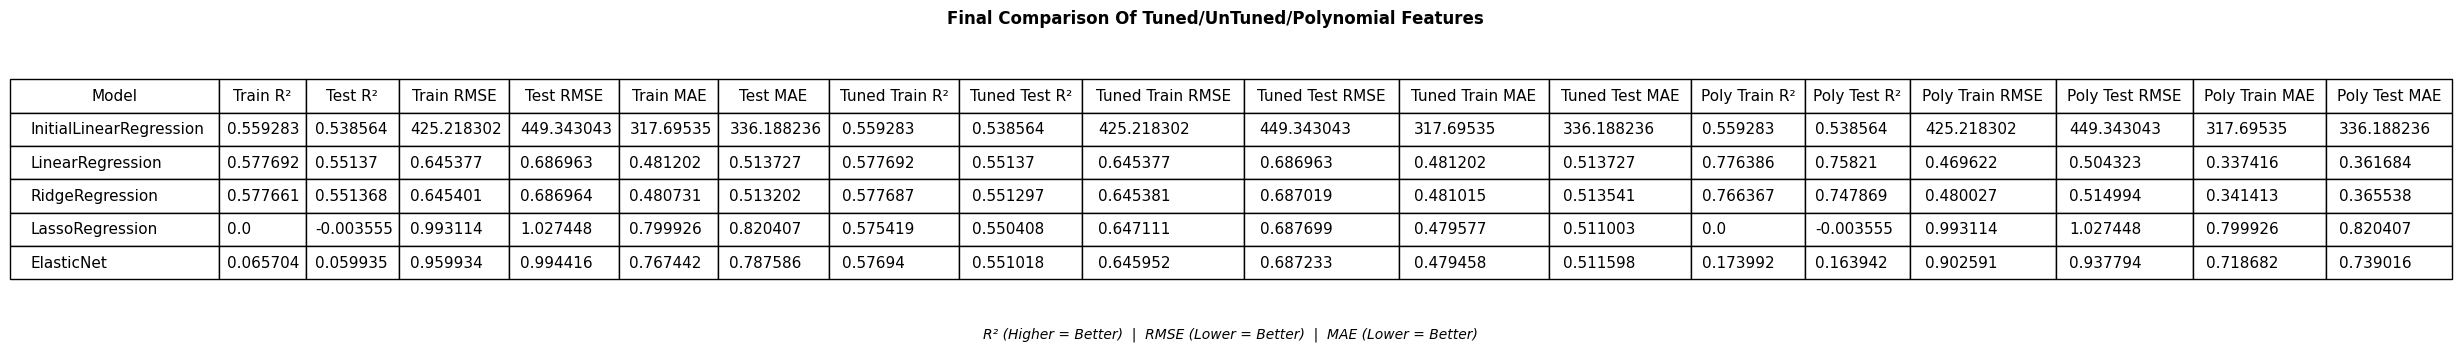

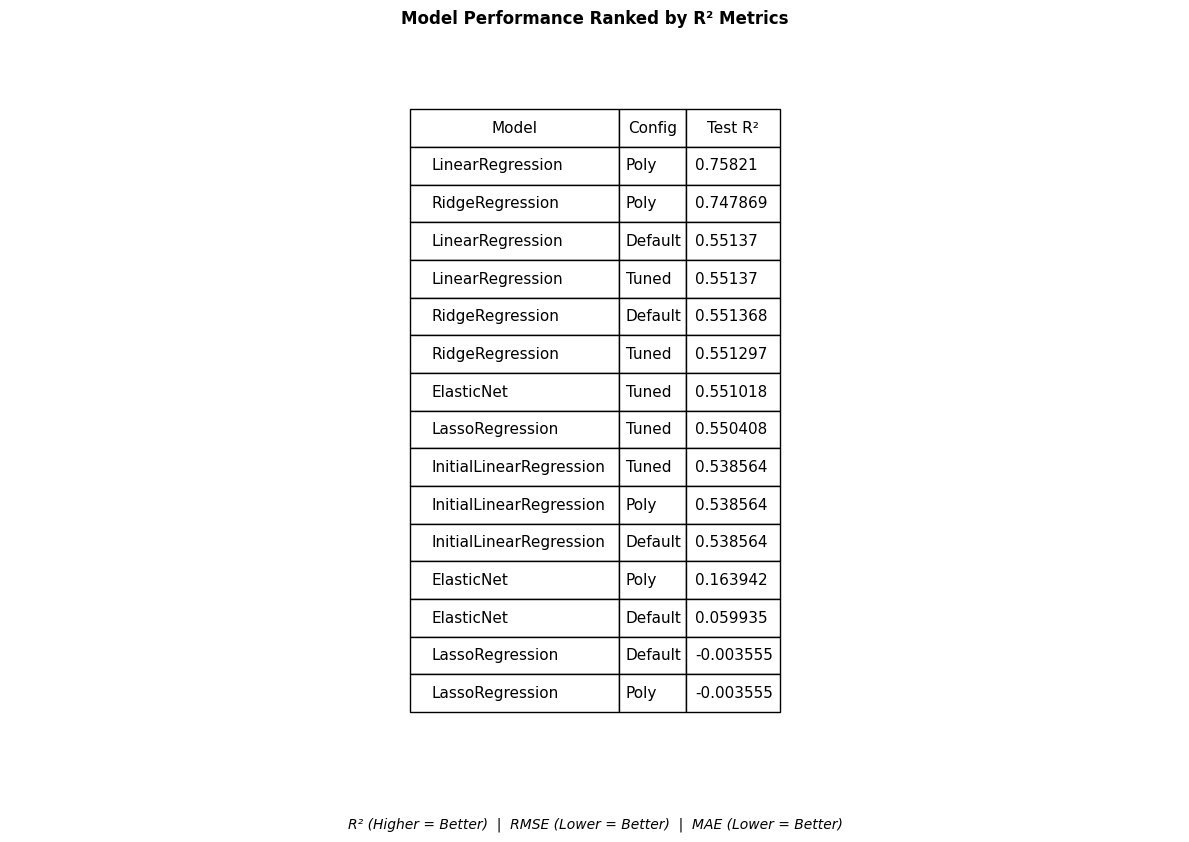

In [ ]:
# Make copy of tuned results and rename columns to have 'Tuned' prefix for plotting
df_poly_regression_results_renamed = df_poly_regression_results.copy()
cols_to_rename = {col: f'Poly {col}' for col in df_poly_regression_results_renamed.columns if col != 'Model'}
df_poly_regression_results_renamed.rename(columns=cols_to_rename, inplace=True)

# Merge UnTuned/Tuned results
df_comparison_final_results = df_comparison_results.merge(df_poly_regression_results_renamed, on='Model')

# Plot for comparison
PlotRegressionModelResultStatistics('Regression Result Statistics Comparing Tuned/UnTuned/Polynomial Features', 
                                    df_comparison_final_results[df_comparison_final_results['Model'] != 'InitialLinearRegression'],
                                    include_polynomial_parameters=True)

DisplayResultsTableInPlot('Final Comparison Of Tuned/UnTuned/Polynomial Features', df_comparison_final_results)

#df_comparison_final_results.head(20)

# Create empty list to store all model/config combinations
rankings = []

# Use R² as test for ranking models
# Loop through each row and pull out each R² column
for _, row in df_comparison_final_results.iterrows():
    model = row['Model']  # Get model name (e.g., 'LinearRegression')
    
    # Add Default config as its own entry
    rankings.append({
        'Model': model,
        'Config': 'Default',
        'Test R²': row['Test R²']
    })
    
    # Add Tuned config as its own entry
    rankings.append({
        'Model': model,
        'Config': 'Tuned',
        'Test R²': row['Tuned Test R²']
    })
    
    # Add Poly config as its own entry
    rankings.append({
        'Model': model,
        'Config': 'Poly',
        'Test R²': row['Poly Test R²']
    })

# Convert list of dictionaries to DataFrame
df_rankings = pd.DataFrame(rankings)

# Sort by Test R² (highest first)
df_rankings = df_rankings.sort_values('Test R²', ascending=False).reset_index(drop=True)

# Make rank start at 1 instead of 0
df_rankings.index = df_rankings.index + 1
DisplayResultsTableInPlot('Model Performance Ranked by R² Metrics', df_rankings)

### **Best Ranked Models** ####
    Based on the above summary plot and table here are the top 3 models based on R² (R-Squared)
                                                           Training Data      Test Data
        - Linear Regression Model with Polynomial Features   0.776        --   0.758
        - Ridge Regression Model with Polynomial Features    0.766        --   0.748
        - Linear/Ridge Tuned Regression Model                0.577        --   0.551

## <u>**5. Model Evaluation and Validation**</u> ##
##### <b>Complete the following tasks:</b> #####
        - Perform cross-validation techniques to validate model performance (on both models- With Polynomial Features and without Polynomial Features)
        - Assess models using test data
        - Compare results across different regression models
        - Summarize findings and key takeaways from the analysis
        - Discuss feature importance and business implications
        - Provide recommendations for further improvements

### Cross Validation ###
        Best Model with Polynomial Features -> Linear Regression
        Best Model without Polynomial Features -> Linear Regression Tuned

Linear Regression with Polynomials
Mean cross-validation RMSE: 0.4870 ± 0.0145
95% CI: 0.4725 to 0.5015
Train RMSE: 0.4696
Test RMSE: 0.5043


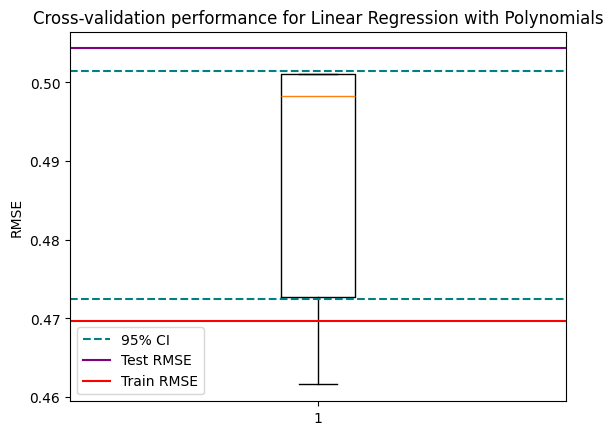



Tuned Linear Regression without Polynomials
Mean cross-validation RMSE: 0.6547 ± 0.0118
95% CI: 0.6429 to 0.6666
Train RMSE: 0.6454
Test RMSE: 0.6870


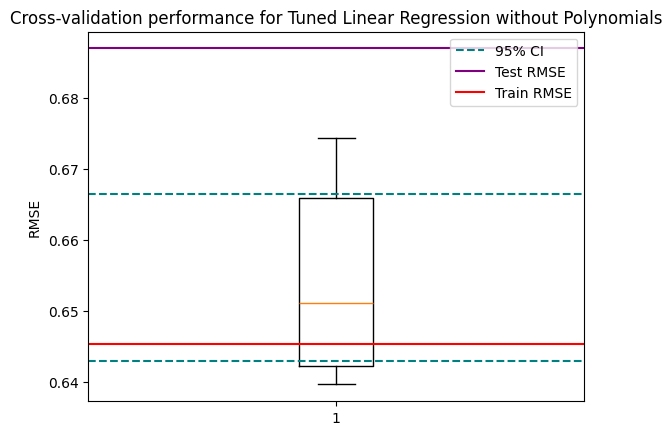

array([0.66602313, 0.67445851, 0.64233533, 0.63969211, 0.6512271 ])

In [ ]:
def ApplyCrossValidation(model, df_target, target_label, plot_label):

    X = df_target.drop(columns=target_label)
    y = df_target[target_label]

    # Split for train/test RMSE calculation
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=315)

    # Fit model and calculate train/test RMSE
    model.fit(X_train, y_train)
    train_rmse = root_mean_squared_error(y_train, model.predict(X_train))
    test_rmse = root_mean_squared_error(y_test, model.predict(X_test))

    kf = KFold(n_splits=5, shuffle=True, random_state=42)

    # Run cross-validation scoring
    cv_scores = cross_val_score(
                                model,
                                X,
                                y,
                                scoring='neg_root_mean_squared_error',
                                n_jobs=-1,
                                cv=kf
                                #cv=5
                            )

    # Need to flip the sign - cross-validation used negative RMSE 
    cv_scores = -cv_scores

    # Get mean and standard deviation, construct 95% CI
    rmse_mean = np.mean(cv_scores)
    rmse_std = np.std(cv_scores)
    moe_95 = 1.96 * rmse_std / np.sqrt(len(cv_scores))

    print(plot_label)
    print(f'Mean cross-validation RMSE: {rmse_mean:.4f} ± {moe_95:.4f}')
    print(f'95% CI: {rmse_mean - moe_95:.4f} to {rmse_mean + moe_95:.4f}')
    print(f'Train RMSE: {train_rmse:.4f}')
    print(f'Test RMSE: {test_rmse:.4f}')

    plt.title(f'Cross-validation performance for {plot_label}')
    plt.boxplot(cv_scores)
    plt.axhline(rmse_mean - moe_95, linestyle='--', color='teal', label='95% CI')
    plt.axhline(rmse_mean + moe_95, linestyle='--', color='teal')
    plt.axhline(test_rmse, color='purple', label='Test RMSE')
    plt.axhline(train_rmse, color='red', label='Train RMSE')
    plt.ylabel('RMSE')
    plt.xlabel('')
    plt.legend(loc='best')
    plt.show()

    print()
    print()

    return cv_scores



# Linear Regression with Polynomials
# For better or worse, we've identified LinearRegression as top model
model = LinearRegression()
#PrintDataFrameStatus(df_floridabikerentals_final)
ApplyCrossValidation(model, df_floridabikerentals_final, 'Rented Bike Count', 'Linear Regression with Polynomials')

# print('------------------------------------------')
# print('Check for Duplicates')
# print(df_floridabikeRentals_for_validation.columns[df_floridabikeRentals_for_validation.columns.duplicated()])

# Ridge Regression Tuned
# Ridge() Best Params:{'alpha': 0.01, 'solver': 'saga'}
#PrintDataFrameStatus(df_tuned_regression_results)
model = Ridge(alpha=0.01, solver='saga')
ApplyCrossValidation(model, df_floridabikeRentals_for_validation, 'Rented Bike Count', 'Tuned Linear Regression without Polynomials')

#### Analysis And Take Aways from Cross-Validation ####
    1.Linear Regression with Polynomials (#1)
    2.Tuned Linear Regression without Polynomials (#1)

    Initially tried using cv=5(folds) for cross_val_score. I was getting some strange looking plots.
    I did a little research and it was suggested that perhaps I had a bad fold which affected my results.
    So I switched over to cv=KFold and the results look much better.
    I will rebase my analysis on that.

    #1 (Poly) Spread between Train and Test RMSE = Test - Train = .5043 - .4696 = .0347
    #2 (Tuned) Spread between Train and Test RMSE = Test - Train = .6870 - .6454 = .0416

    Possible Overfitting on #1 - based on gap between train (higher) and test (lower)
    We might want to reduce the number of features in our model (overfitting is common occurance in PolynomialFeatures)

    Does #2 suffer from slight underfitting? Is the model TOO simple?

    Outliers are not an issue for either model - there are no points plotted outside the min/max whiskers.

    Note:: Still not entirely clear on how to read and truly understand the details of these plots.
           Some one on one office time might make things clearer.

    Based on spread (difference) between train/test data, #1(Poly) is the best model.
    It is a smaller train/test spread ≈ .0347

    #1 (Poly) Mean cross-validation RMSE: 0.4870
    #2 (Tuned) Mean cross-validation RMSE: 0.6547
    Difference Between the two => 0.65 − 0.49 = 0.16

    #1 (Poly) > #2 (Tuned) (0.6547 > 0.4870)
    #1 (Poly) - smaller errors, more accurate

    #1 (Poly) is .016 lower than #2 (Tuned)
    Percentage Improvement => Difference/#2 (Tuned) => .16/.65 ≈ .25
    #1 (Poly) is roughly 25% better than #2 (Tuned)

    #1(Poly) is the better choice

    

### **Final Thoughts and Recap** ###
In general I tried to sprinkle explanations and analysis through the workbook.
#### Initial load and EDA analysis uncovering the following initial observations: ####
    - We have 8.760 rows of data
    - The dataset contains 13 columns (features)
    - I did not see any obvious instances of missing data (empty/null/nan) values
    - There are some unreasonable negative skewed values fo Temperature (C) and Dew Point Temperature
      It is especially confusing since the data set exists in Florida.
      Florida rarely experiences temperatures far below freezing.
      Florida is also a humid (tropic) environment and would not experience exceedingly dry conditions (dry even for deserts)
      This can only be concluded as being bad data. We can either ignore it, adjust it, or just use it as.
    - Date (object) => should be translated to be a Date datatype
    - For efficency/performance we should consider the following features from float64 to ints

    - The following observations can be made through histogram plots of the original features:
        Rented Bike Count           - Right Skewed Distribution
        Hour                        - Looks like a Tri-Modal Distribution, as it has 3 peaks (1 at each end, and 1 in the middle)
                                    - Possibly related to high use times (morning/evening rush hour/high demand, mid-day high demand)
        Temperature(C)              - Looks "like" a Normalish Distribution
        Humidity(%)                 - Looks "like" a Normalish Distribution - looks like it's got an outlier at the high end
                                    - Could be considered Bimodal Distribution with 2 definite peaks
        Wind speed (m/s)            - Right Skewed Distribution
        Visibility (10m)            - Left Skewed Distribution
        Dew point temperature(C)    - Looks "like" a Normalish Distribution - or Bi/Tri-Modal (there's 2-3 peaks)
                                    - Related to seasons?
        Solar Radiation (MJ/m2)     - Right Skewed Distribution
        Rainfall(mm)                - Right Skewed Distribution
        Snowfall (cm)               - Right Skewed Distribution

    - Observations across categoric features:
        Date                        - There is an even distribution across all dates
        Seasons                     - Looks like there is an even distribution of seasons
        Holiday                     - Many more "No Holiday" days than "Holidays"
        Functioning Day             - Many more bikes rented on "Functioning Days" than non

    - Initial Histograms show that several of the features do not have normal distributions
    - The following features showed outliers - wind speed, rainfall, snowfall

    - Additional Observations:
        Wind Speed - Its possible to have a totally calm day with absolutely no wind. We can't discern between real calm
        days and instances of missing/bad data. Leave it as it is.

        Solar Radiation - It's possible to have zero (0) Solar Radiation - night time. We can't discern between night time
        (legitimate) and missing data. Leave it as is.

        Humidity - Zero (0) percent humidity is extremely rare (even in desert climates). These values should be considered
        suspicious and treated as missing data. We should either treat as missing values or establish a reasonable threshold 
        and apply it to the feature. Given this data set originates from Florida, exceedingly now humidity is highly improbable.
        Establish a reasonable lower bounds threshold.

        Dew Point Temperature - a dew point temeprature of -30.6 degrees is highly unlikely and should be treated as 
        bad/suspicious data, especially given that our data set is Florida based, which is typically a hot/warm/humid evironment.
        We should establish a reasonable threshold and apply it to the feature.

#### Data Wrangling ####
##### Encoding of Features #####
    - Seasons                   - One-Hot Encoding - create a column for each season
    - Holiday, Functioning Day  - Binary Encoding, since both Features can only be 1 of 2 values
##### Date Translation and slicing/encoding#####    
    - Translated to Date type and then broken into smaller/meaningful pieces - year, month, day, day of week
##### Address Invalid Data #####
    Temperature (C) and Dew Point Temperature had a wide range of values (neg skews) that are not in tune
    with the hot/warm/humid climate of Florida. Mentioned in detail above.
##### Mitigate the effect of extreme outliers #####
    None
##### Additional Data Fixes #####
    Visibility was in 10m increments. I normalized by mulitply the feature by 10 to get true distance in meters
##### Binning Exploration #####
    I chose not to do binning. It requires some more investigation. Some features might fare well with binning:
    Rental times (morning-commute, mid-day rush, evening-commute,other)

#### Feature Engineering ####
##### Data Encoding #####
    I performed One-Hot Encoding (), Ordinal Encoding() and Label Encoding()
##### Data Type Conversion #####
    Except for Income, float64 types were converted to integers for overall model performance improvements
##### Handling erroneous data features #####
    Course of action - drop the column(s). We can always come back and re-evaluate this.
##### Created Additional Feature Columns #####
    Create new features:
        - Normalized (Ratio)
        - Difference Features
        - Tranformed (log/sqrt)
        - Free Form Features
    Examining the dataset, I created some multi-column features which made sense given the context of our data.
    (visits per region.., and so on)
##### Polynomial Feature Creation #####
    This was a requirement of the assignment. Polynomial Features were compared and scored against non-Poly
    features to determine best model.
##### Feature Distribution Normalization #####
    Based on EDA, I determined that Yeo-Johnson transformation for normalization was the best option
##### Feature Scaling #####
    I applied Standard Scaling as it is best suited to deal with Right Skewness and extreme outliers.
    I had some concern that I applied scaling to the entire dataset which could result in some data loss

##### Model Building and Investigation #####
    Analysis is based on the following statistics criteria from the model Train and Test Predictions:
    R² (Higher = Better)  |  RMSE (Lower = Better)  |  MAE (Lower = Better)

    All regression models scored better that initial baseline for RMSE and MAE. 
    R² was relatively equal between baseline and regression models, with regression models performing just slightly better.

    Linear and Ridge Regression scored almost identically across Error Metrics.
    Lasso Regression and ElasticNet scored similarly for RMSE and MAE.
    Based on the plots and data table, Linear and Ridge Regression are the clear winners.
    R² was highest score wise, while RMSE and MAE had lowest scores.

    All regression models scored better that initial baseline for RMSE and MAE. 
    For final comparison/analysis sake, the initial baseline linear regression was removed from the plots.

    Linear and Ridge Regression (both with tuned/untuned parameters) produced identical results.
    After further some further investigation, this is not an unusual situation.
    I don't fully understand it, but given the current data set, Ridge does not need regularization so it converges
    to a Linear Regression (from Claude Search).
    Since Ridge tends toward Linear Regression, hyperparameter tuning had little or no effect on the results.

    Hyperparameter Tuning (HPT) - had the largest effect on R² scores for Lasso Regression and ElasticNet with
    remarkable increases in scores. HPT also showed strong improvements in RMSE and MAE scores for Lasso and ElasticNet,
    though not as dramatic as R².
    
    There appears to be no major overfitting taking place.

    Once HPT was applied, score results for Ridge, Lasso, ElasticNet and Linear Regression were much more aligned in value,
    so they were in similar value ranges. The tuned models converged in score values and strongly mirror each other in the plots.
    Given the current dataset and the noted performance similarities, Linear Regression might be the model.

##### Some Random Thoughts, Comments and Observations #####
    - I probably spent 80% of my time on EDA and Data Wrangling (Data Prep).
    - Even though I built this incrementally, as things got more involved, it became harder to identify, 
      track and correct potential errors/bugs
    - The further you go on the process, early errors can cause abnormal/weird/unusual results whose
      cause can be difficult to track down.
    - I think probably as experience increases in EDA and Data Wrangling will make it easier to
      identify/track issues in the future
    - I need to get better and markup formating to make cleaner/tighter markups